In [23]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy


In [2]:
np.random.seed(0)

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
def add_noise_vector(vector, desired_snr_db=20):
    """
    Ajoute du bruit gaussien à un melspectrogramme ou un vecteur aplati tout en respectant un SNR donné.

    :param vector: Le vecteur brut (aplati).
    :param desired_snr_db: Rapport signal/bruit (en dB).
    :return: Le vecteur bruité.
    """
    signal_power = np.mean(vector ** 2)
    
    noise_power = signal_power / (10 ** (desired_snr_db / 10))
    noise_std_dev = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std_dev, vector.shape)
    
    # Ajout du bruit au 
    noisy_vector = vector + noise
    
    return noisy_vector  # Éviter les valeurs négatives
def time_shift_vector(vector, shift_pct=0.2):
    """
    Décale les colonnes d'un melspectrogramme aplati (vecteur brut).

    :param vector: Le vecteur brut (aplati).
    :param shift_pct: Pourcentage de décalage (positif ou négatif).
    :return: Le vecteur décalé.
    """
    # Dimensions du melspectrogramme (par défaut 20x20, à adapter si nécessaire)
    nmel, ncol = 20, 20  # Assurez-vous que ces dimensions correspondent à vos données
    matrix = vector.reshape((nmel, ncol))  # Reformater en matrice

    # Calcul du décalage en colonnes
    shift_amt = int(shift_pct * ncol)
    shifted_matrix = np.roll(matrix, shift_amt, axis=1)  # Décalage des colonnes

    return shifted_matrix.flatten()  # Reconvertir en vecteur aplati

def add_background_noise_vector(vector, desired_snr_db=20, nmel=20, ncol=20):
    """
    Ajoute un bruit de fond à un melspectrogramme ou un vecteur aplati tout en respectant un SNR donné.

    :param vector: Le vecteur brut (aplati) représentant un melspectrogramme.
    :param desired_snr_db: Rapport signal/bruit (en dB).
    :param nmel: Nombre de bandes Mel (hauteur du melspectrogramme).
    :param ncol: Nombre de colonnes du melspectrogramme (largeur).
    :return: Le vecteur avec bruit de fond.
    """
    bg_sig, sr = AudioUtil.open("src/classification/datasets/soundfiles/background.wav")
    if sr != 10200:
        bg_sig, sr = AudioUtil.resample((bg_sig, sr), newsr=10200)

    bg_melspec = AudioUtil.melspectrogram((bg_sig, sr), Nmel=nmel, Nft=512)

    if bg_melspec.shape[1] < ncol:
        raise ValueError("Le melspectrogramme de bruit de fond est trop petit pour être utilisé.")
    import random
    start_index = random.randint(0, bg_melspec.shape[1] - ncol)
    bg_melspec = bg_melspec[:, start_index:start_index + ncol]

    matrix = vector.reshape((nmel, ncol))

    signal_power = np.mean(matrix ** 2)
    noise_power = np.mean(bg_melspec ** 2)

    scaling_factor = np.sqrt(signal_power / (noise_power * 10 ** (desired_snr_db / 10)))

    scaled_bg_melspec = bg_melspec * scaling_factor

    noisy_melspec = matrix + scaled_bg_melspec

    return noisy_melspec.flatten()

In [6]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

18

In [34]:
from collections import Counter

# --- Paramètres ---

X = np.load(fm_dir + "feature_matrix_selected.npy")
y = np.load(fm_dir + "labels_selected.npy")

# Create a table of class occurrences in y
class_occurrences = Counter(y)
train_pct = 0.7

naudio_sum = 0
nclass = len(class_occurrences)
featveclen = X.shape[1]
nitems = len(y)
classnames = list(class_occurrences.keys())  # assure que classnames est bien défini

print("Class occurrences:")

for class_name, count in class_occurrences.items():
    
    naudio_sum += count
    print(f"{class_name}: {count}")
print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")


study = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_impurity_decrease': 0.0,
    'max_features': 'sqrt'
}

# Créer le modèle Random Forest avec les paramètres optimaux
rf_model = RandomForestClassifier(**study)
rf_model.fit(X, y)
# Enregistrer le modèle
with open(model_dir + "rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

Class occurrences:
chainsaw: 40
fire: 40
fireworks: 40
gun: 40
Shape of the feature matrix : (160, 400)
Number of labels : 160


gun


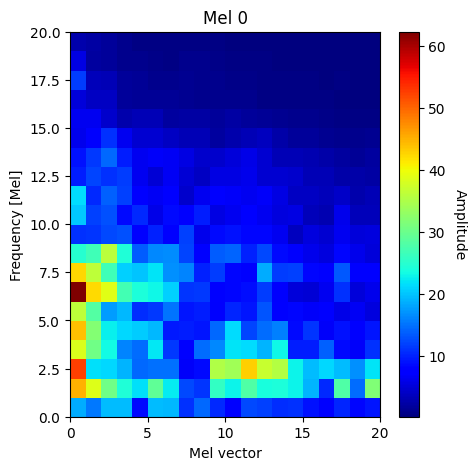

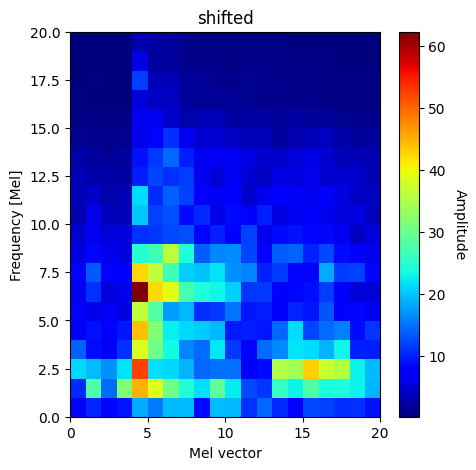

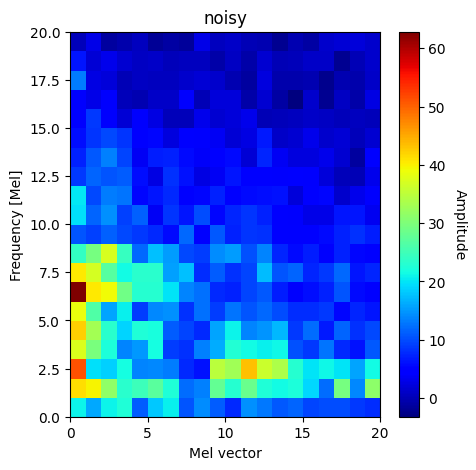

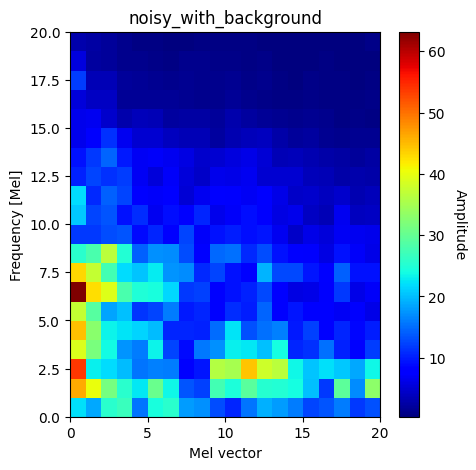

In [9]:
### Test des data augmentation --> Tests OK
# ----------------------------

vector = X[152]  
print(y[152])
fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    vector.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"Mel {0}",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)


# ----------------------------

shifted = time_shift_vector(vector, shift_pct=0.2)
fig, ax = plt.subplots(figsize=(5, 5))

plot_specgram(
    shifted.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"shifted",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)
noisy = add_noise_vector(vector, desired_snr_db=20)

fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    noisy.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)




noisy_with_background = add_background_noise_vector(vector)
fig, ax = plt.subplots(figsize=(5, 5))
plot_specgram(
    noisy_with_background.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy_with_background",  
    xlabel="Mel vector",
    amplitude_label="Amplitude"
)
plt.show()




In [13]:
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

shift_pcts = [0.2,0.4,0.6]

n_augmentations_per_vector = 1+1 + len(shift_pcts) * 2  # Original + (shift  + background noise) par shift_pct
total_train_aug = len(X_train) * n_augmentations_per_vector
print(n_augmentations_per_vector)
# Préallouer les tableaux pour le training set
X_train_aug = np.zeros((total_train_aug, X_train.shape[1]))
y_train_aug = np.zeros(total_train_aug, dtype=y_train.dtype)

# Remplir les tableaux préalloués pour le training set
index = 0
for vector, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augmentation du training set"):
    # Ajouter le vecteur original
    X_train_aug[index] = vector
    y_train_aug[index] = label
    # print(f"Index {index}: Original")

    index += 1
    
    # Ajouter le vecteur bruité avec bruit de fond
    noisy_with_bg_vector_base = add_background_noise_vector(vector, desired_snr_db=20)
    X_train_aug[index] = noisy_with_bg_vector_base
    y_train_aug[index] = label
    # print(f"Index {index}: Noisy + Background")
    index += 1
    

    # Appliquer les augmentations
    for shift_pct in shift_pcts:
        shifted_vector = time_shift_vector(vector, shift_pct=shift_pct)
        X_train_aug[index] = shifted_vector
        y_train_aug[index] = label
        # print(f"Index {index}: Shifted ({shift_pct*100}%)")
        index += 1

        noisy_with_bg_vector = add_background_noise_vector(shifted_vector, desired_snr_db=20)
        X_train_aug[index] = noisy_with_bg_vector
        y_train_aug[index] = label
        # print(f"Index {index}: Noisy + Background")
        index += 1

8


Augmentation du training set: 100%|██████████| 112/112 [14:43<00:00,  7.89s/it]


Augmentation du training set:   0%|          | 0/112 [00:00<?, ?it/s]

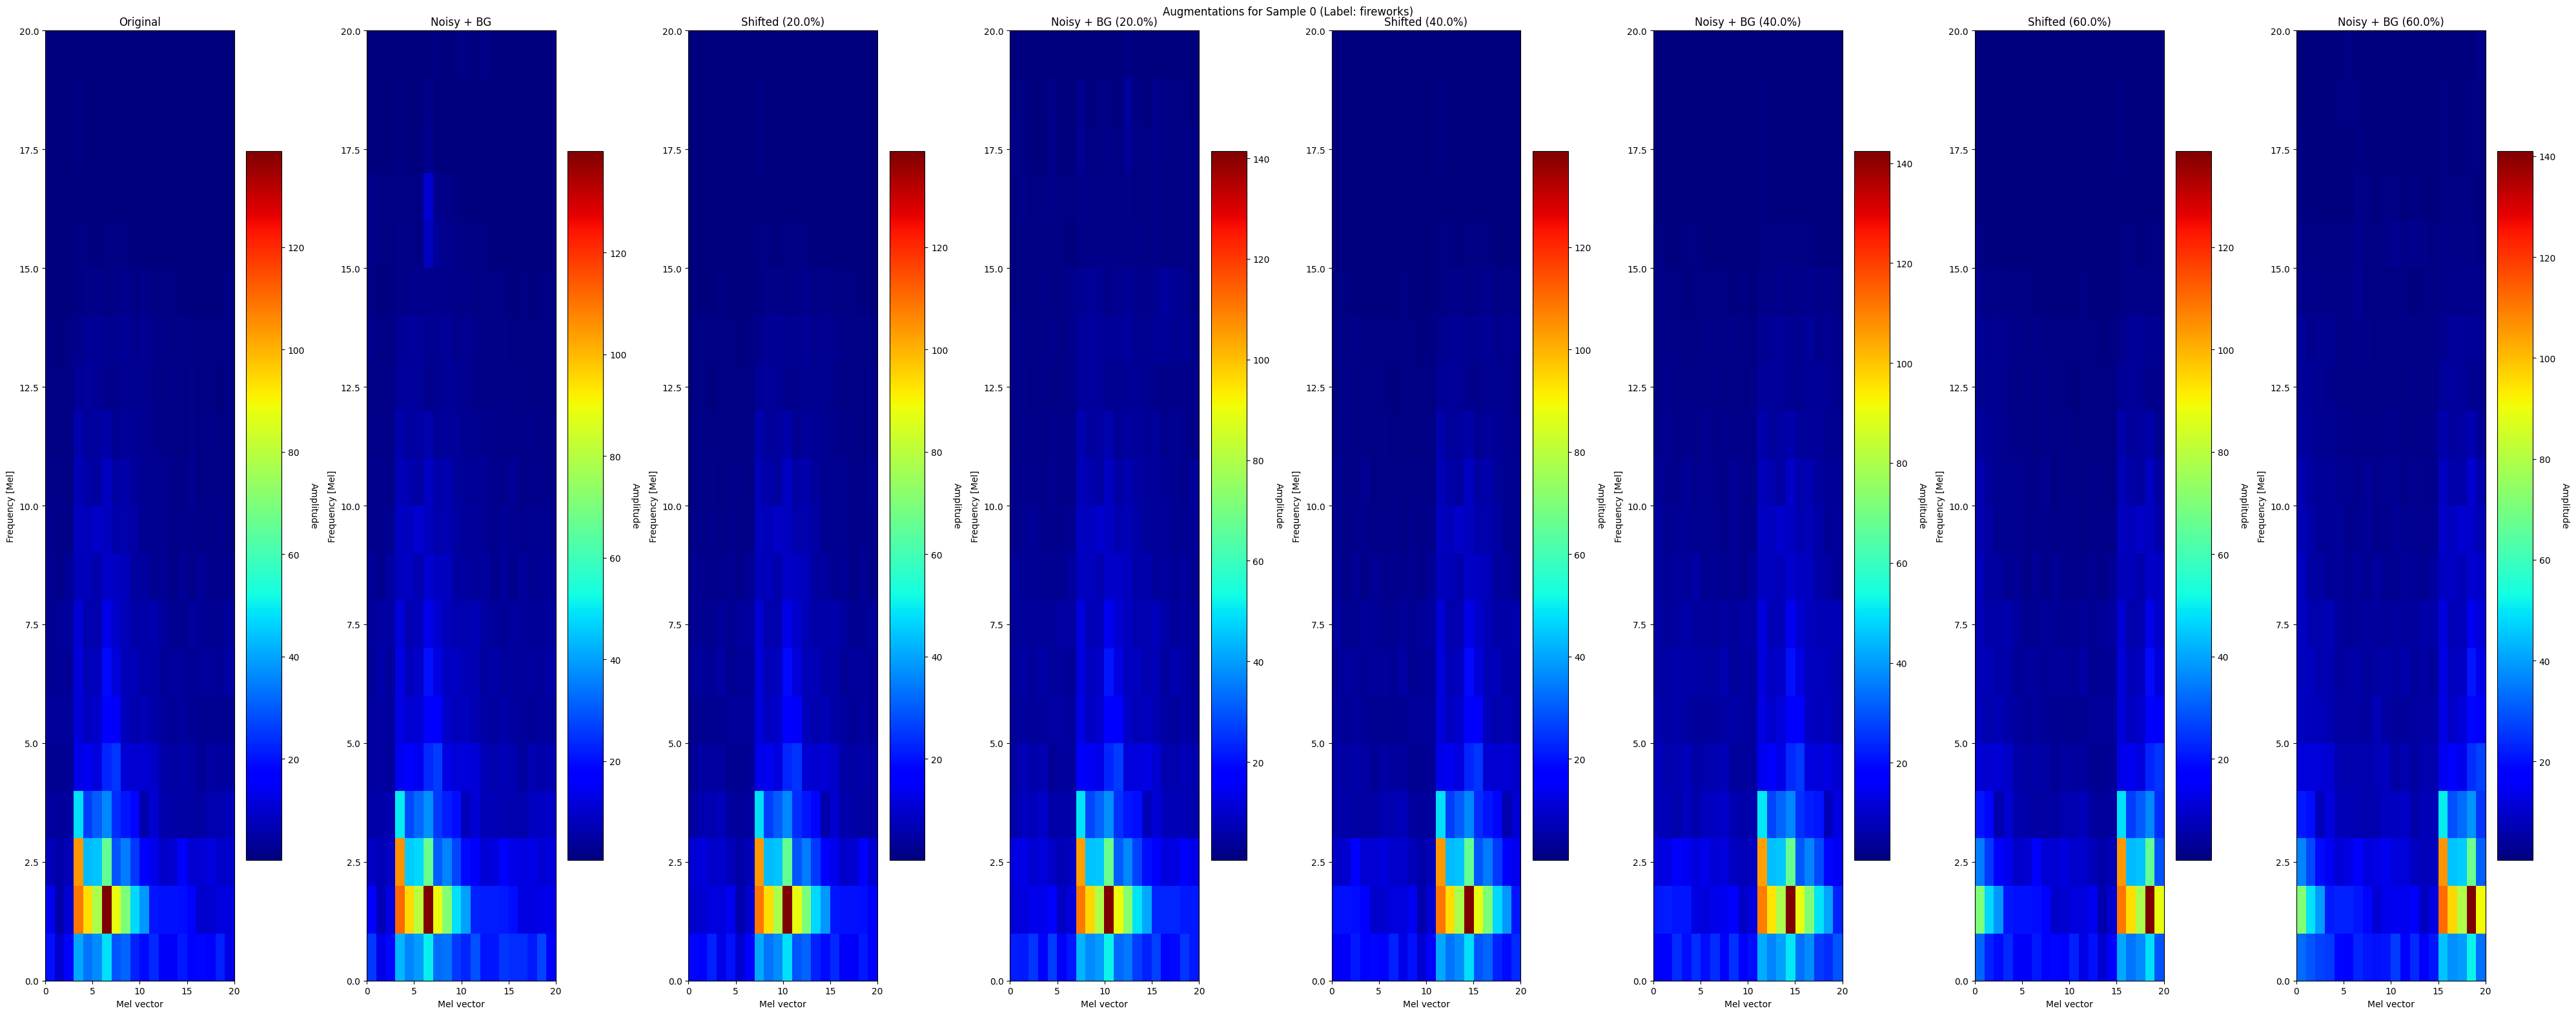

Augmentation du training set:   1%|          | 1/112 [00:10<18:38, 10.07s/it]

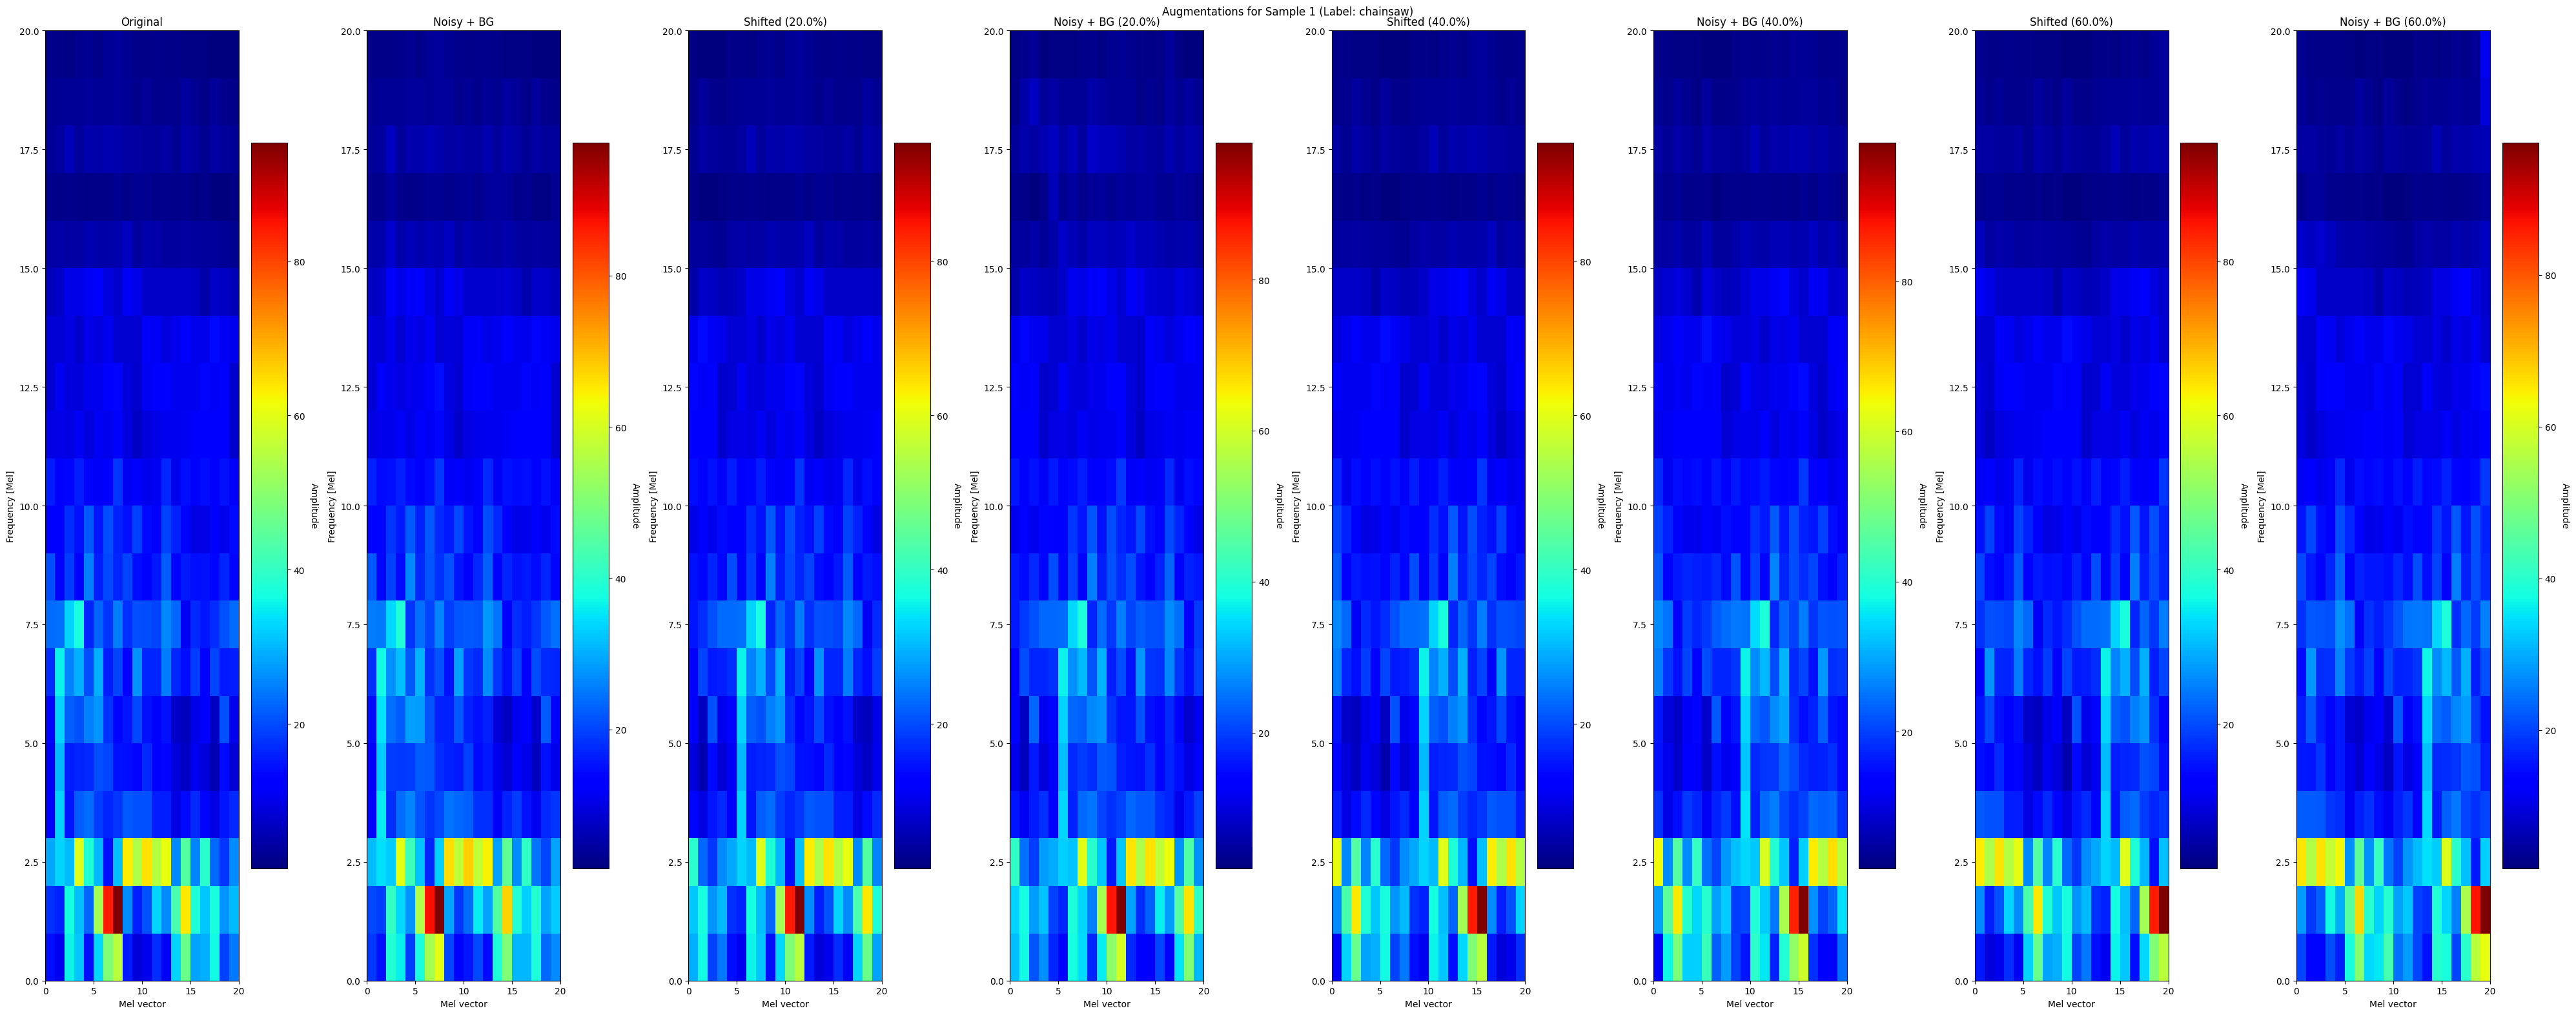

Augmentation du training set:   2%|▏         | 2/112 [00:16<14:54,  8.14s/it]

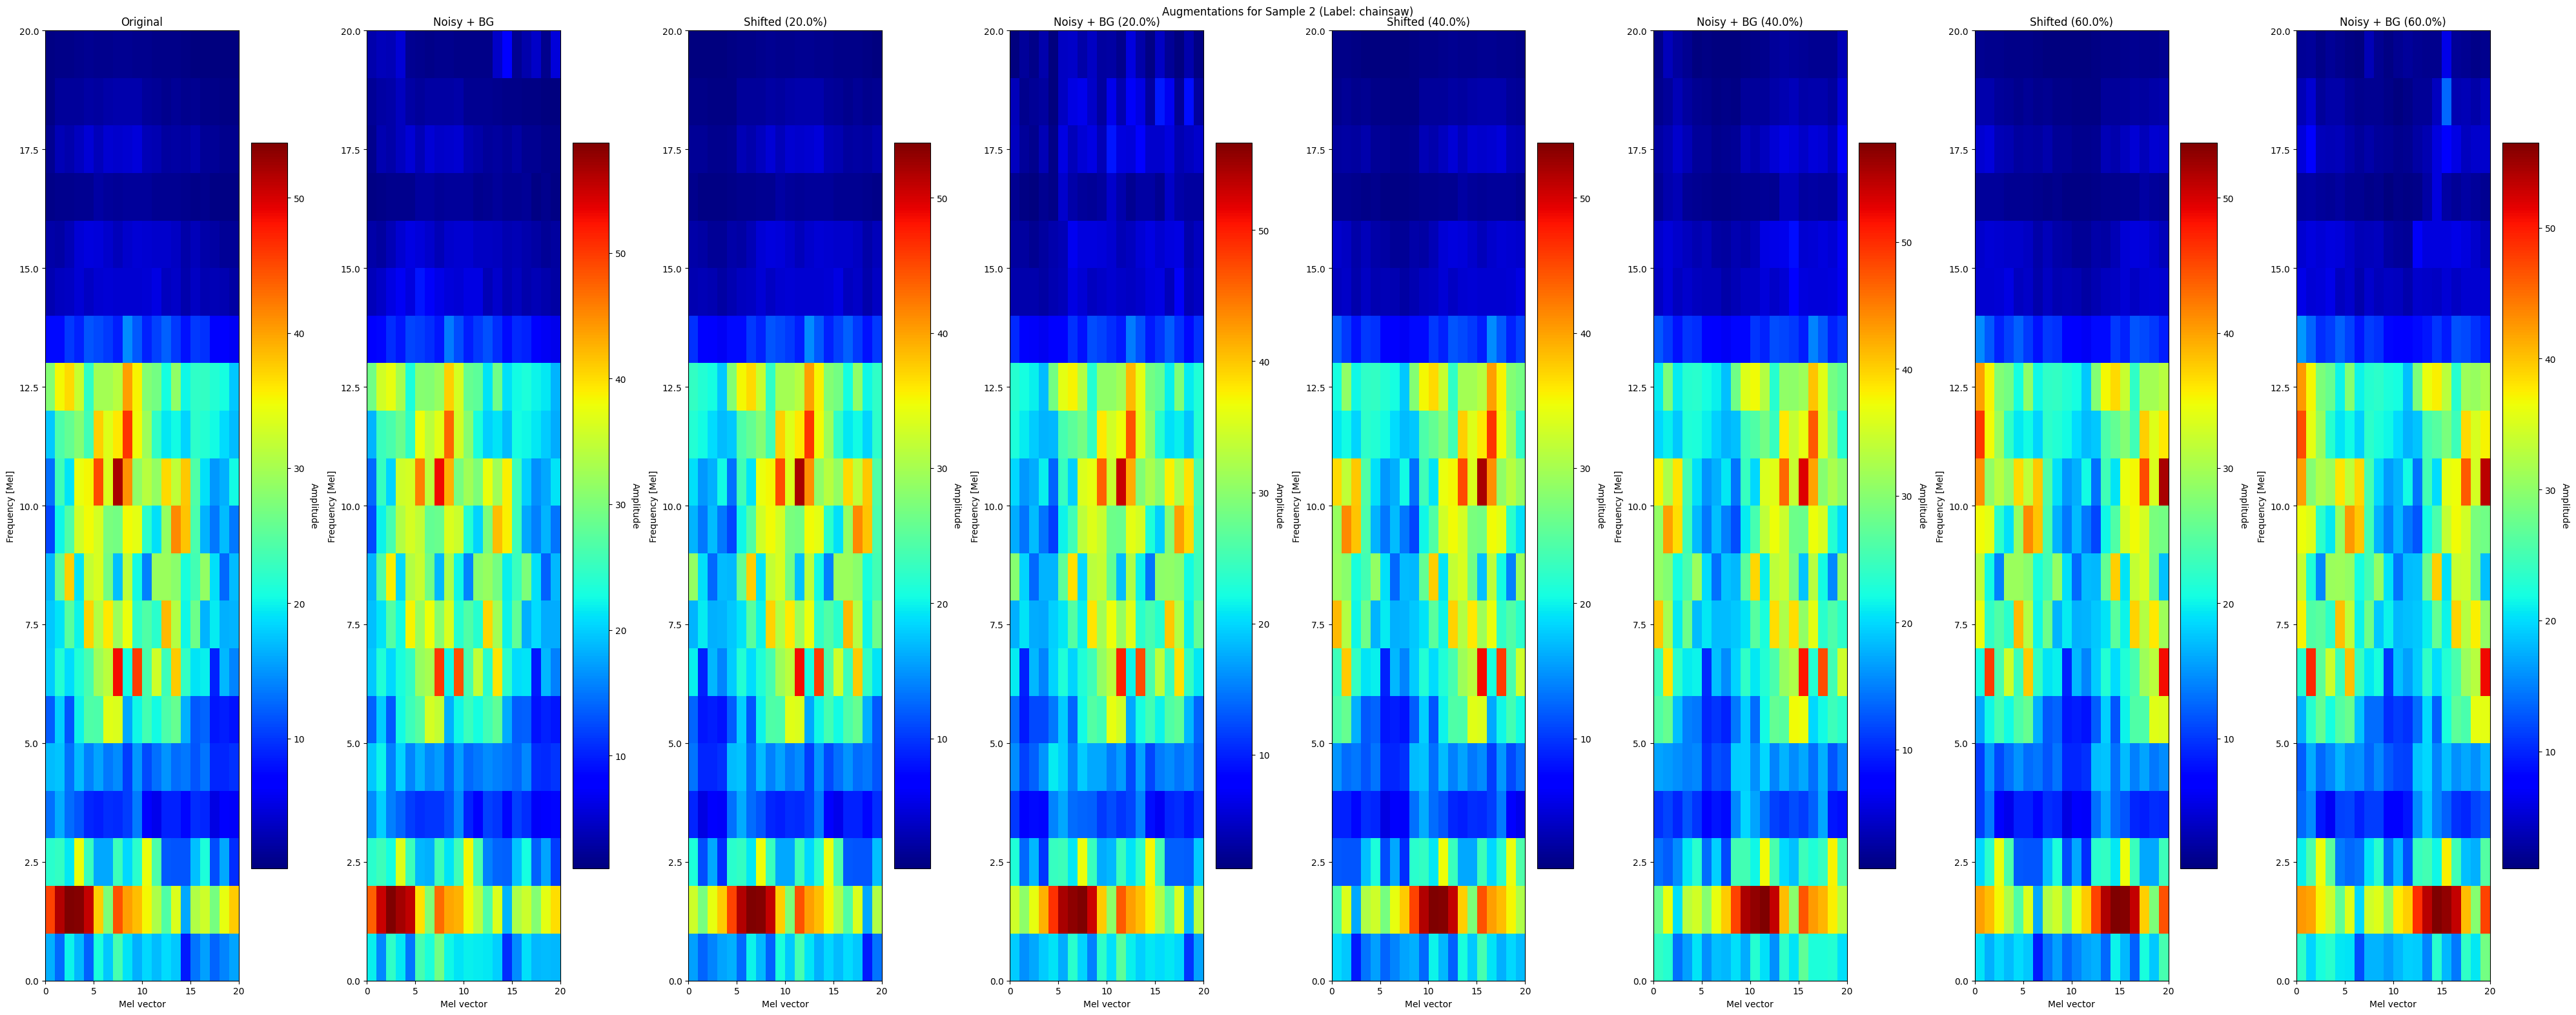

Augmentation du training set:   3%|▎         | 3/112 [00:23<13:35,  7.48s/it]

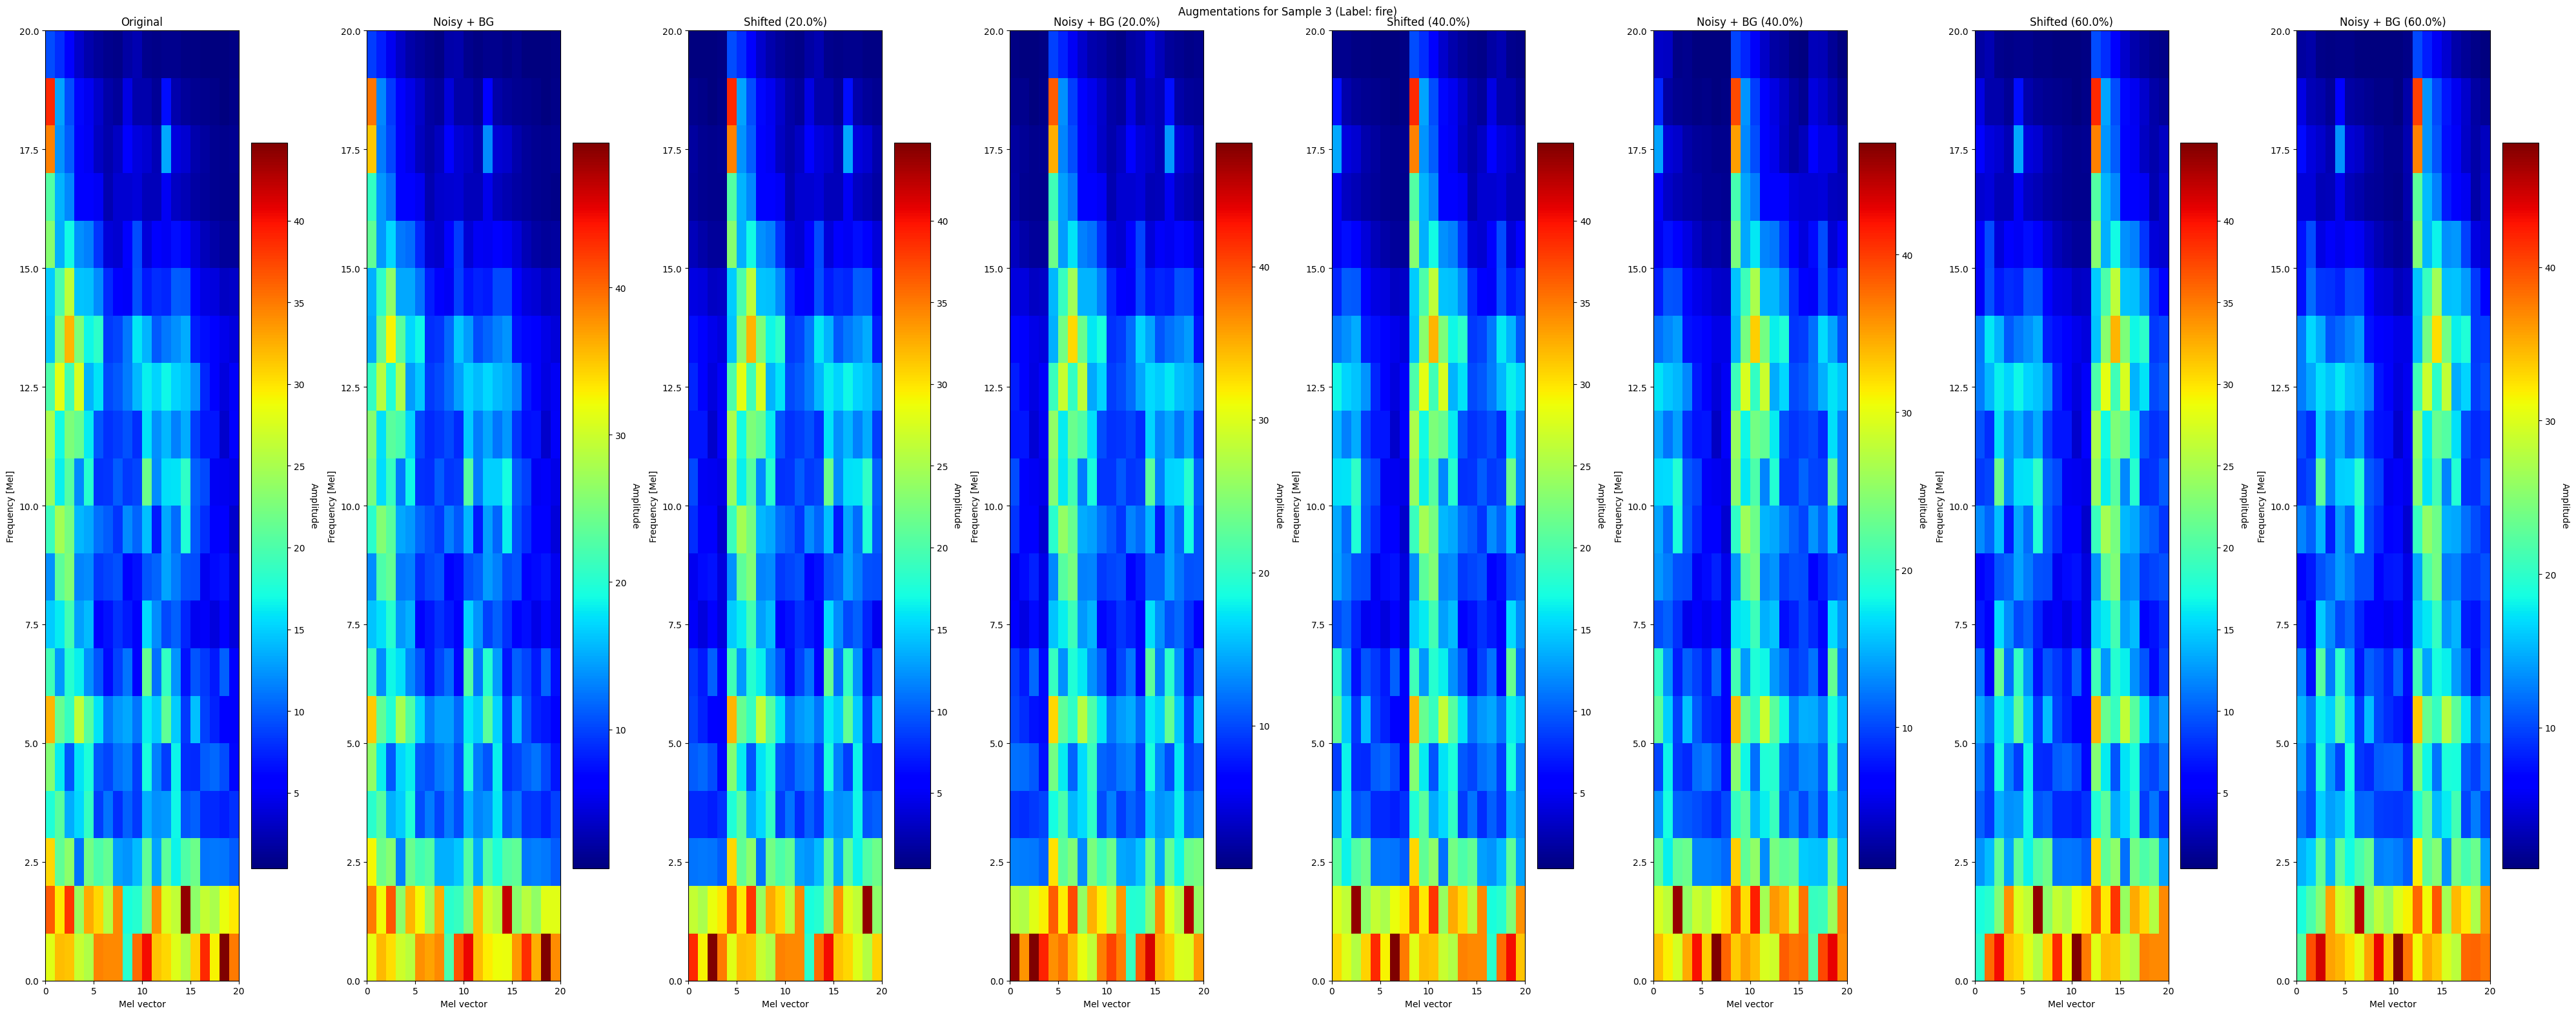

Augmentation du training set:   4%|▎         | 4/112 [00:30<13:06,  7.28s/it]

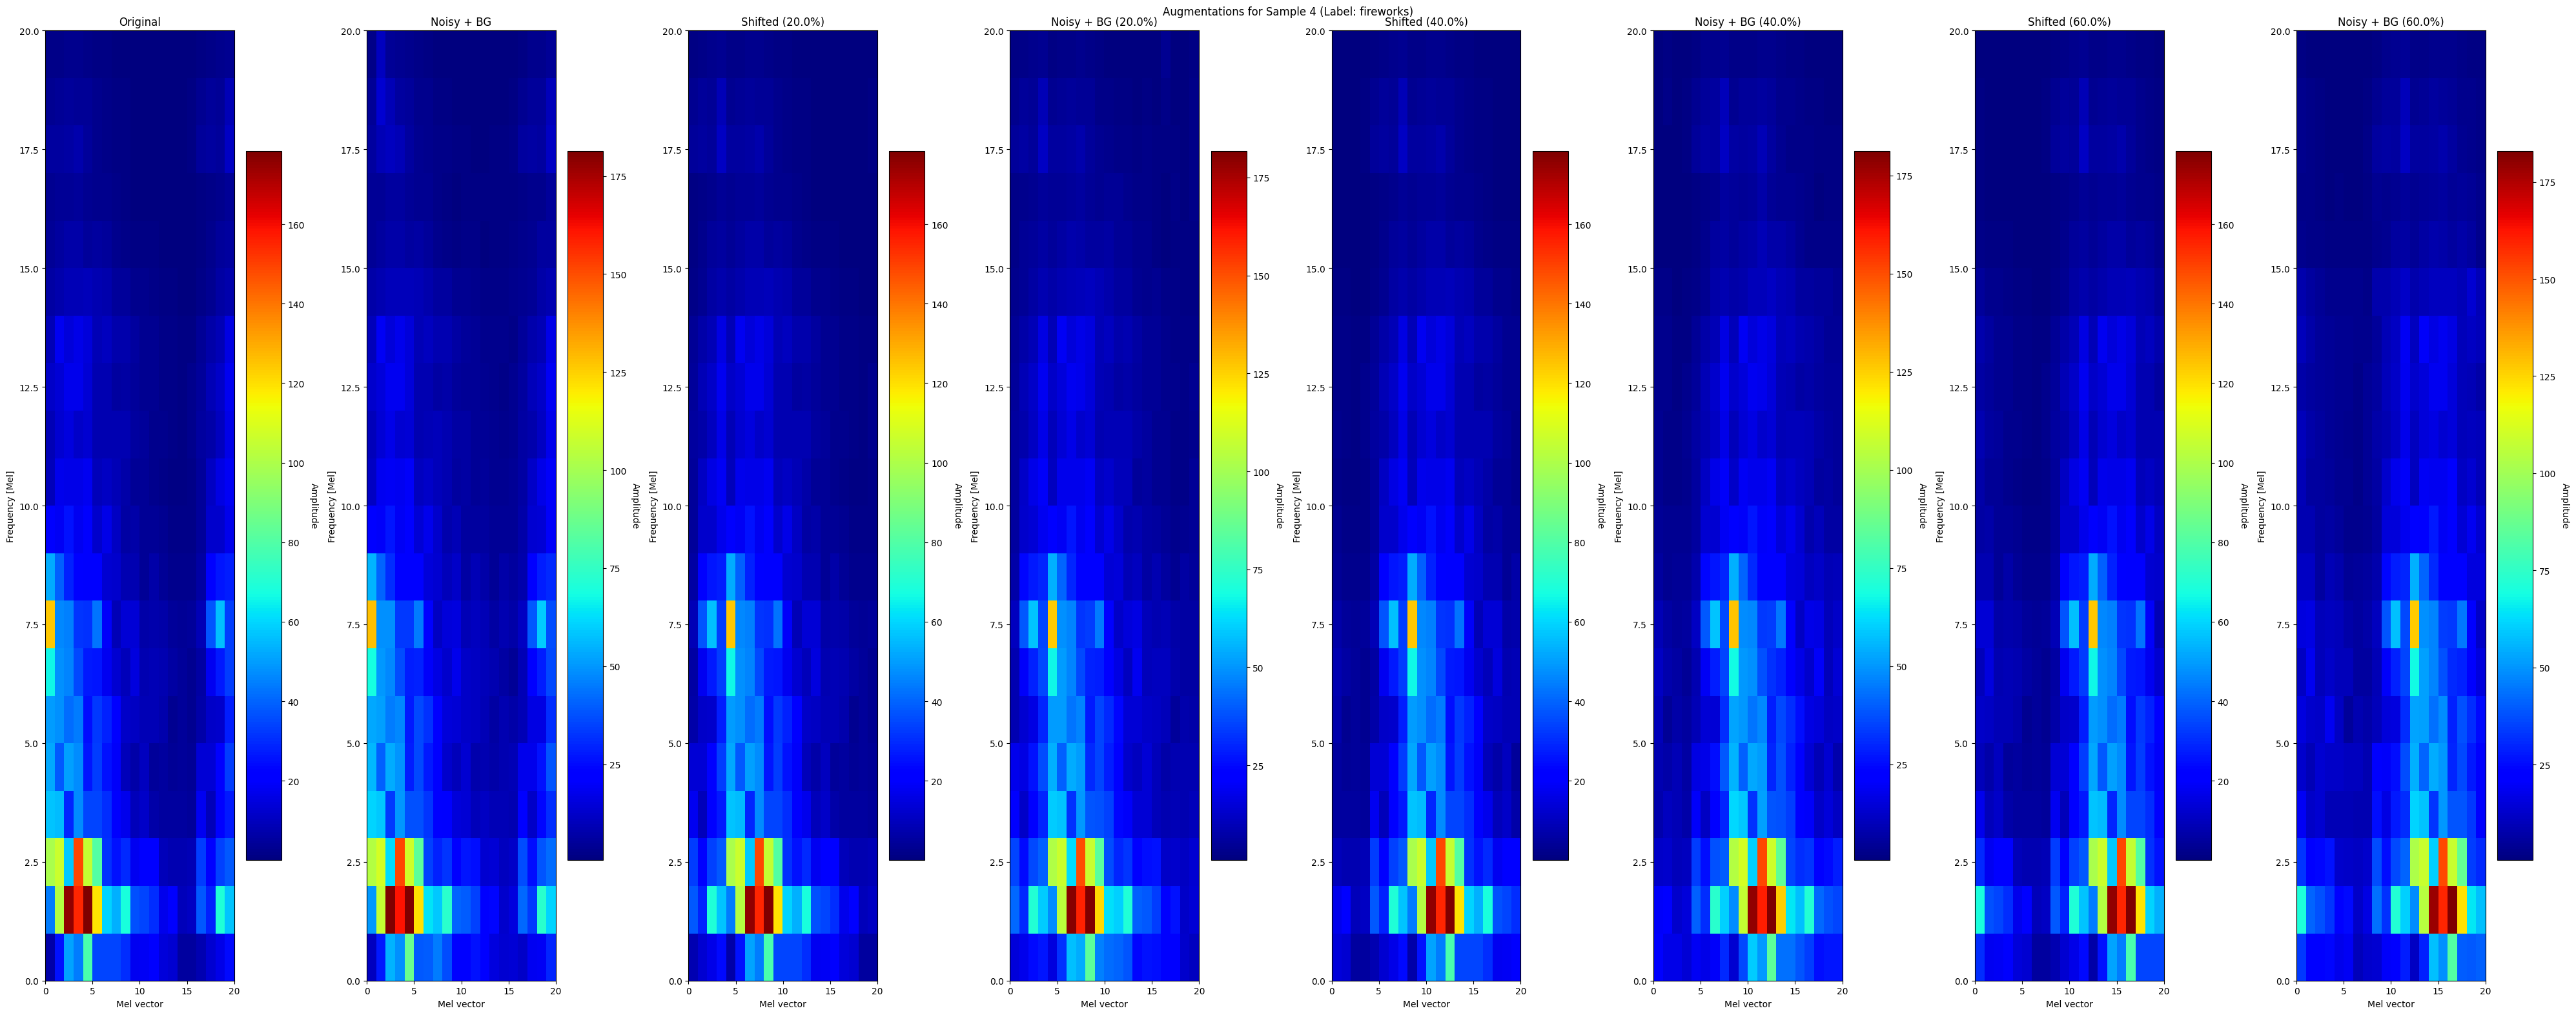

Augmentation du training set:   4%|▍         | 5/112 [00:37<12:49,  7.19s/it]

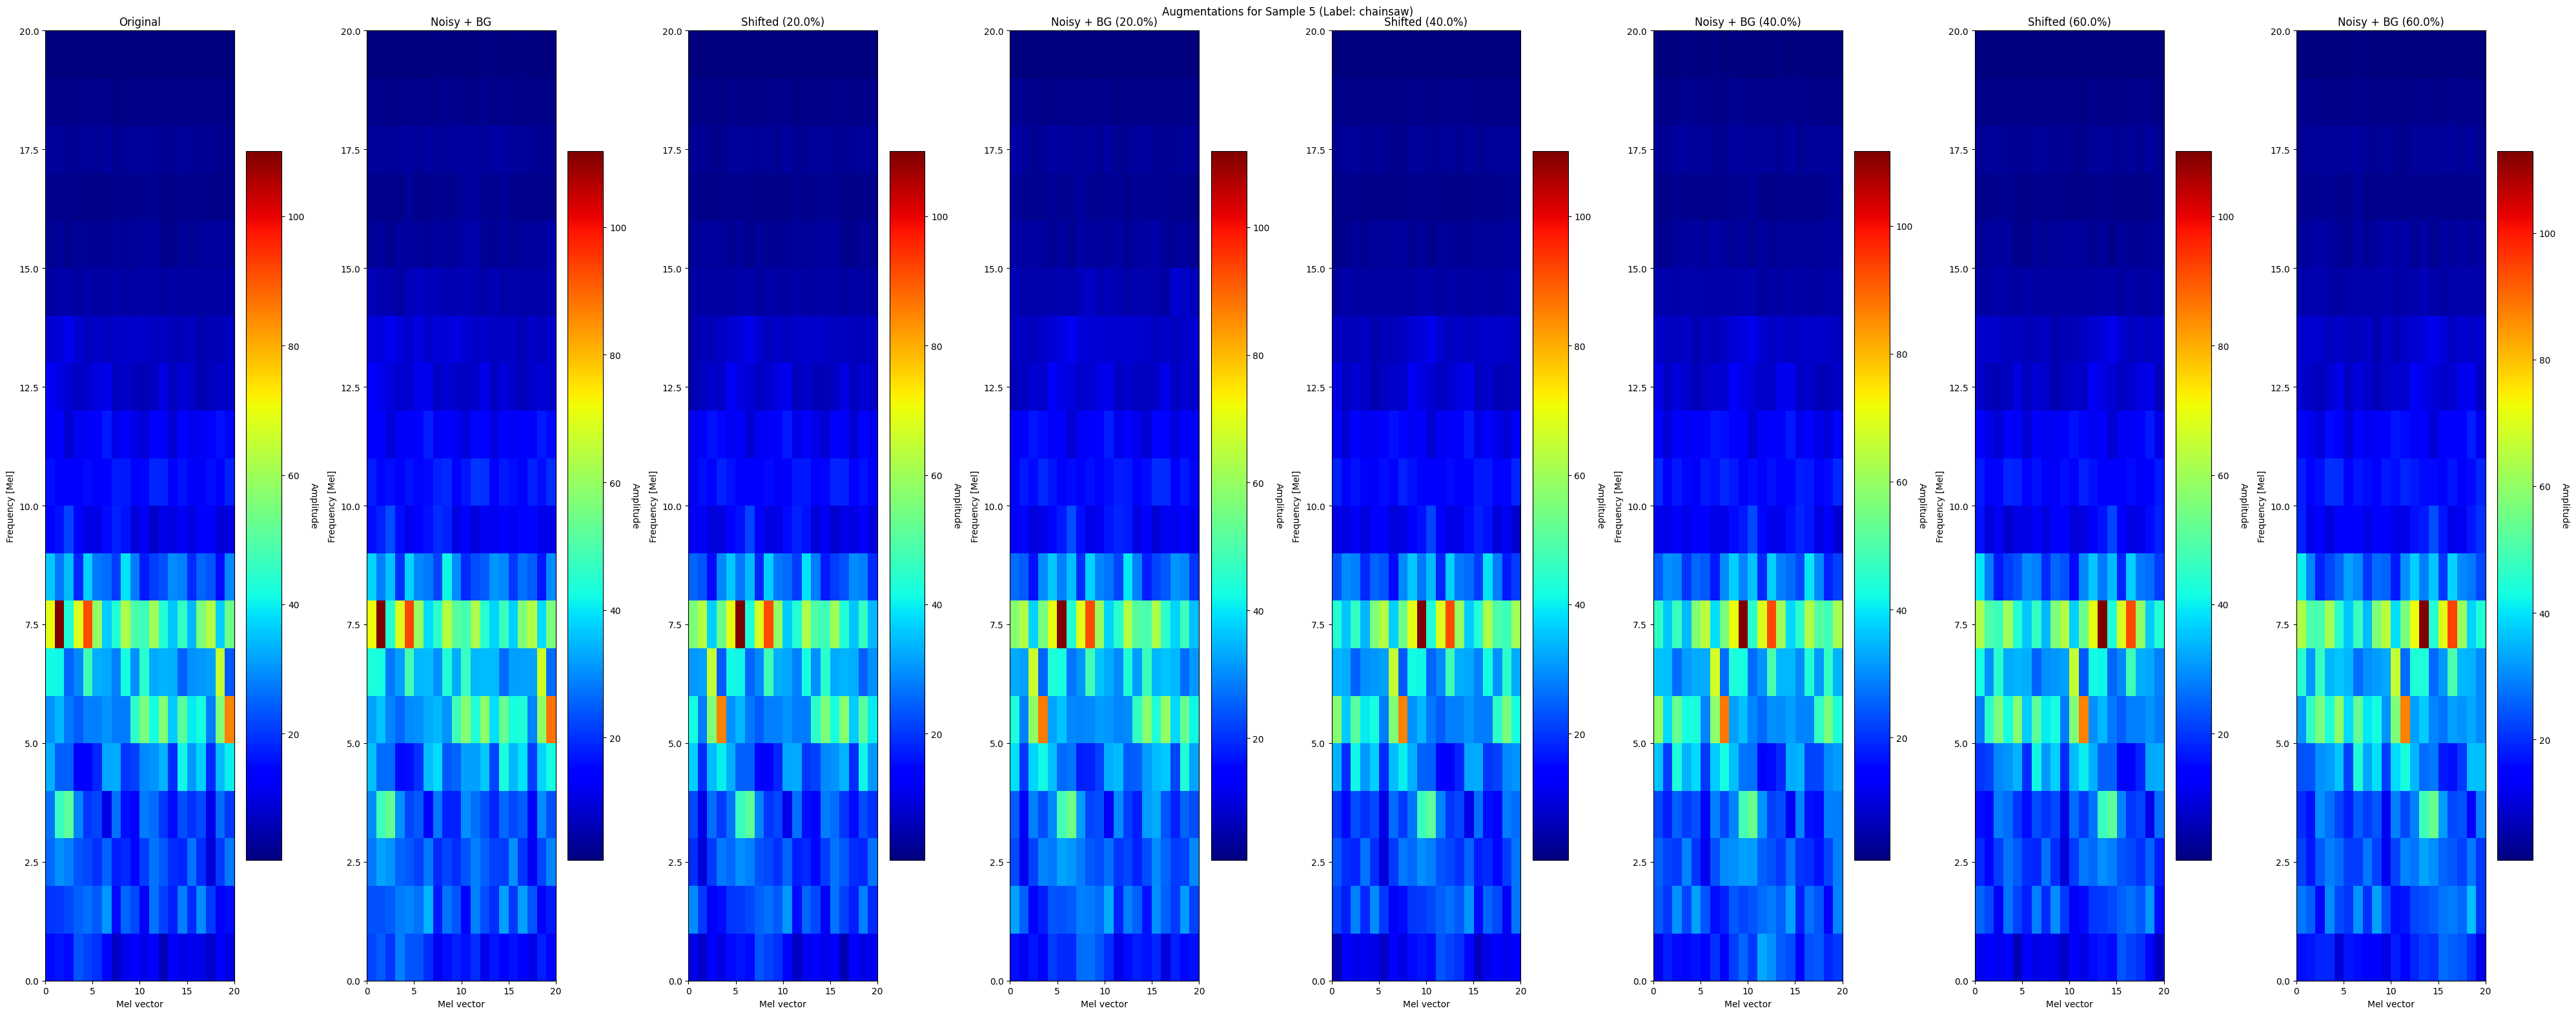

Augmentation du training set:   5%|▌         | 6/112 [00:44<12:24,  7.02s/it]

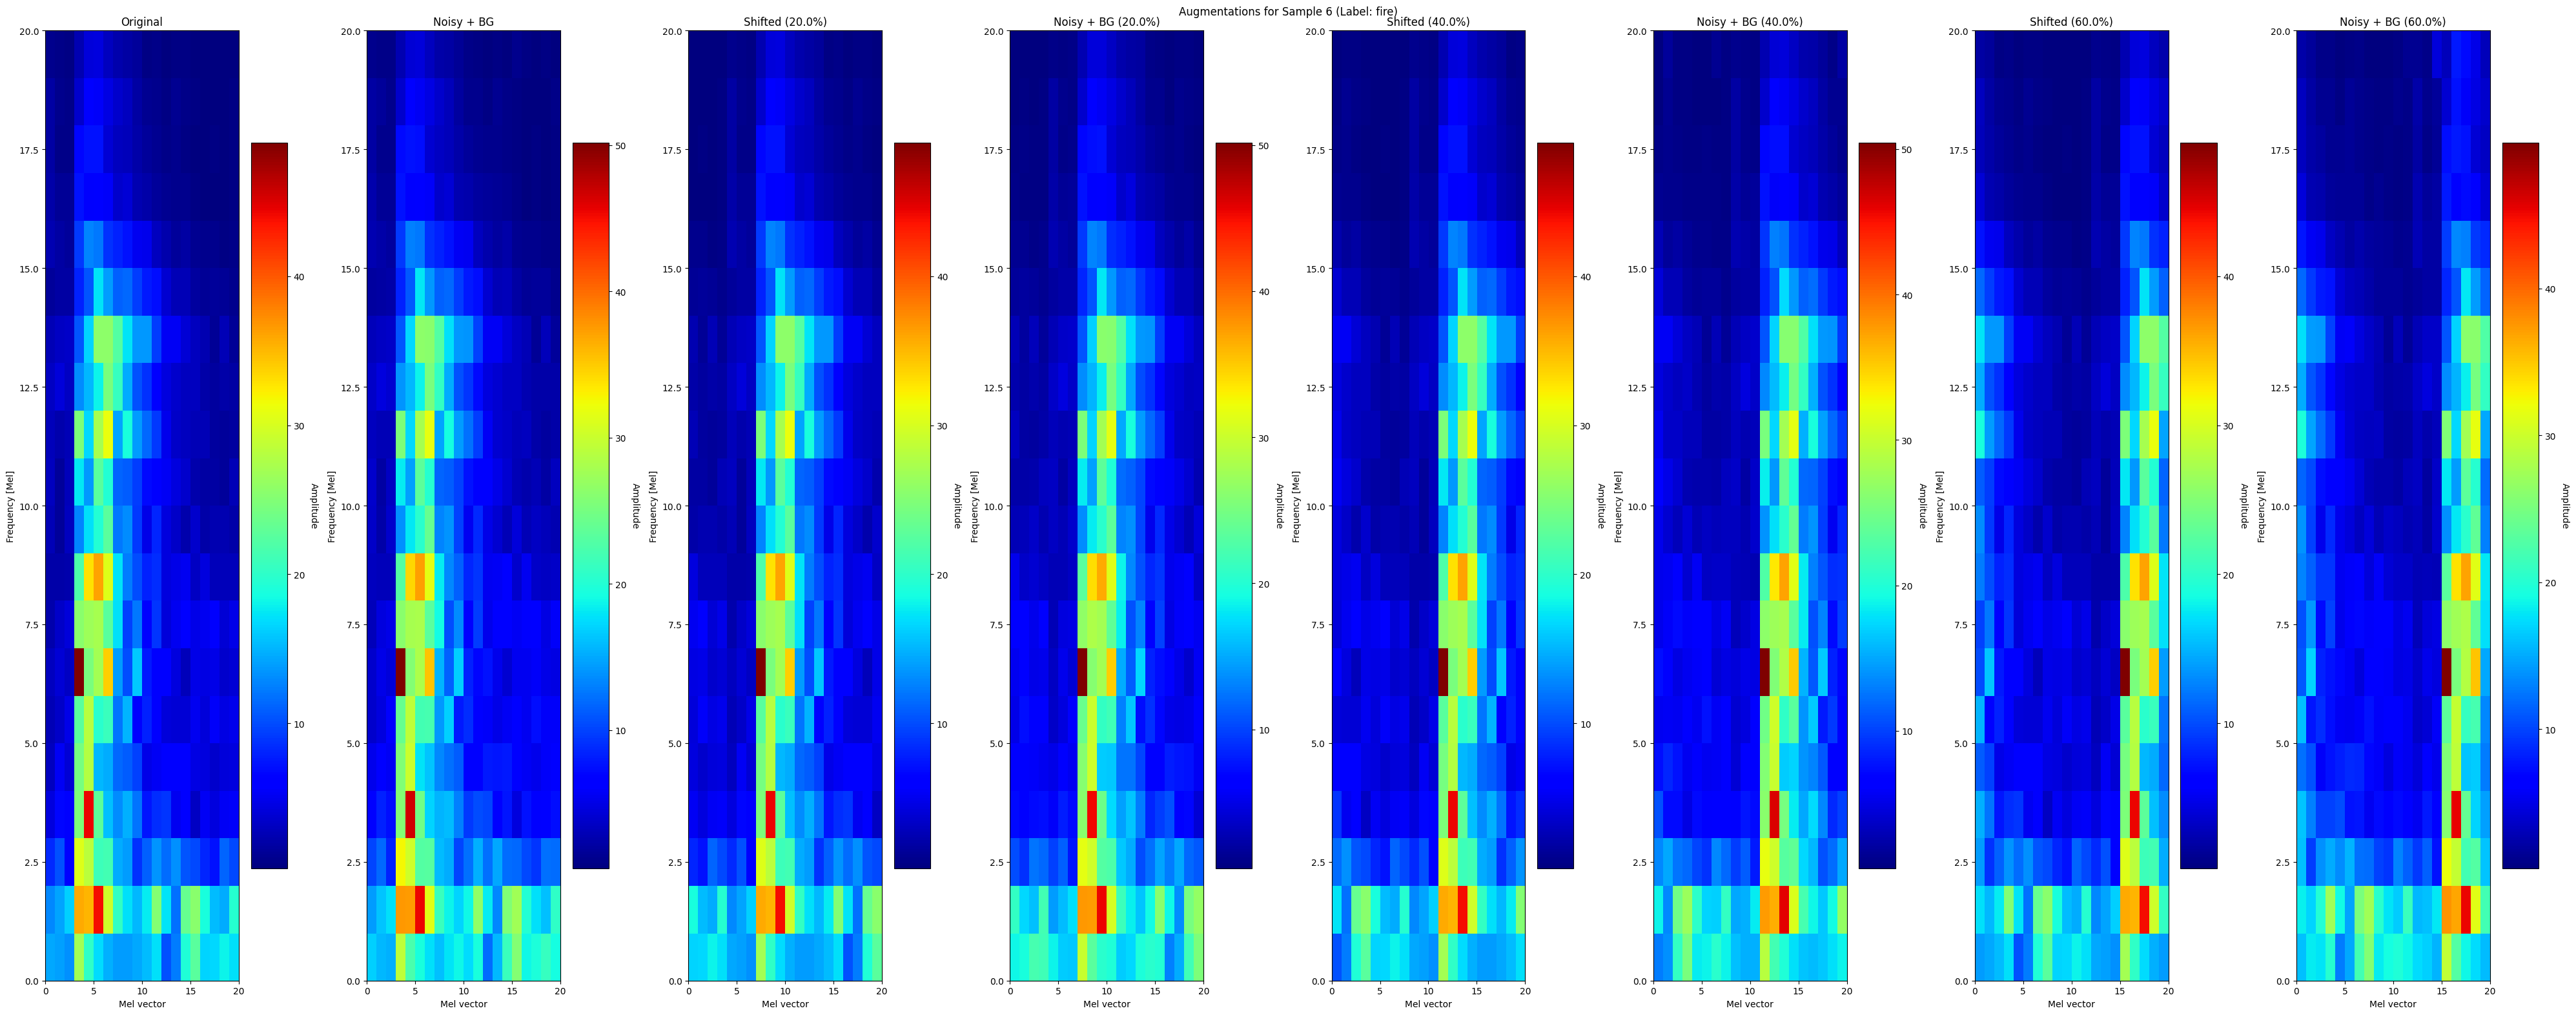

Augmentation du training set:   6%|▋         | 7/112 [00:50<12:07,  6.93s/it]

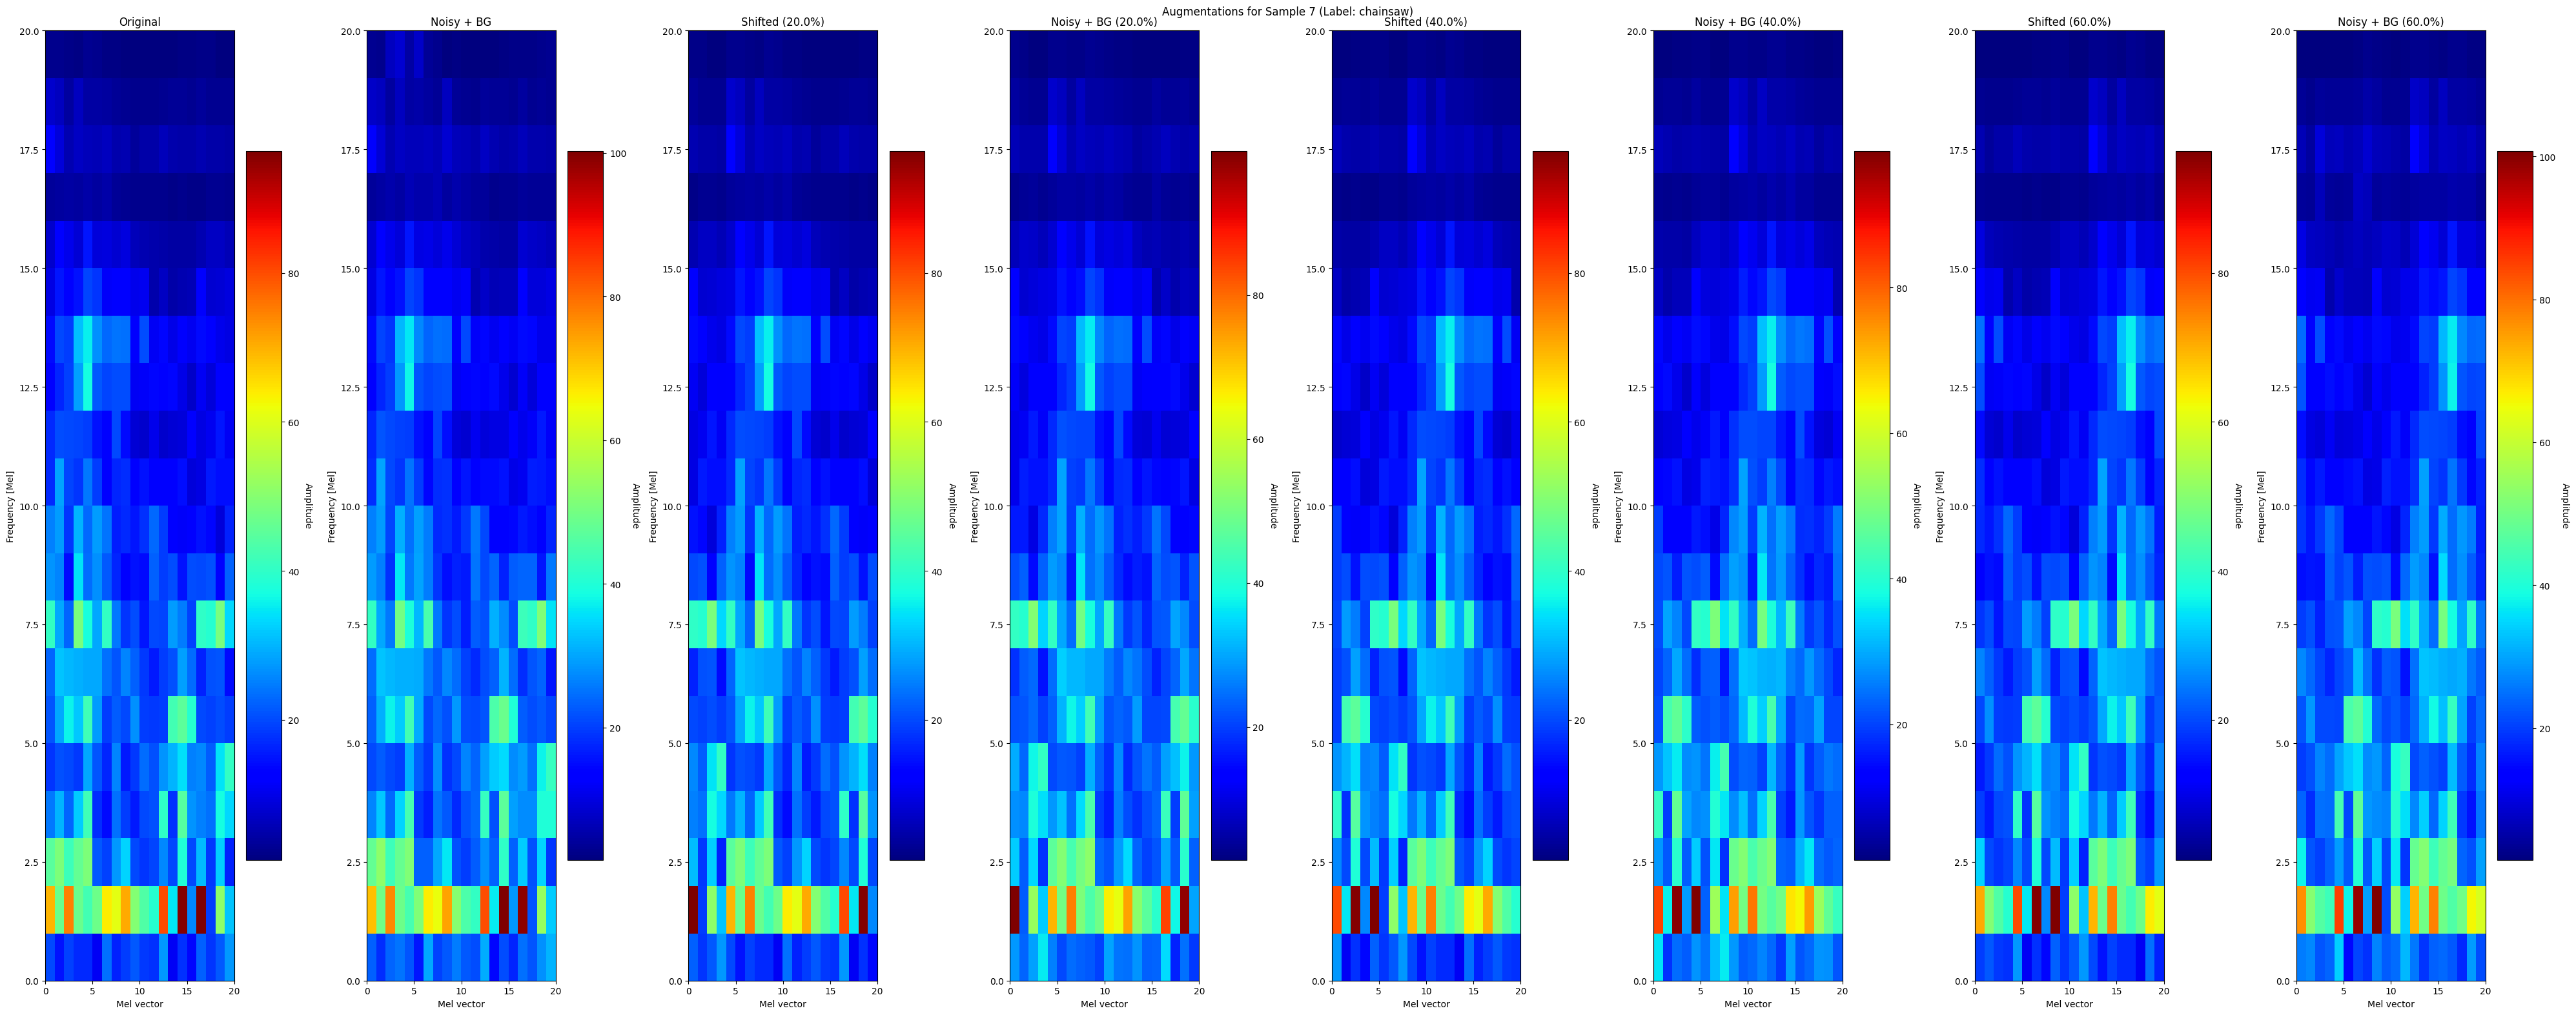

Augmentation du training set:   7%|▋         | 8/112 [01:01<13:13,  7.63s/it]


KeyboardInterrupt: 

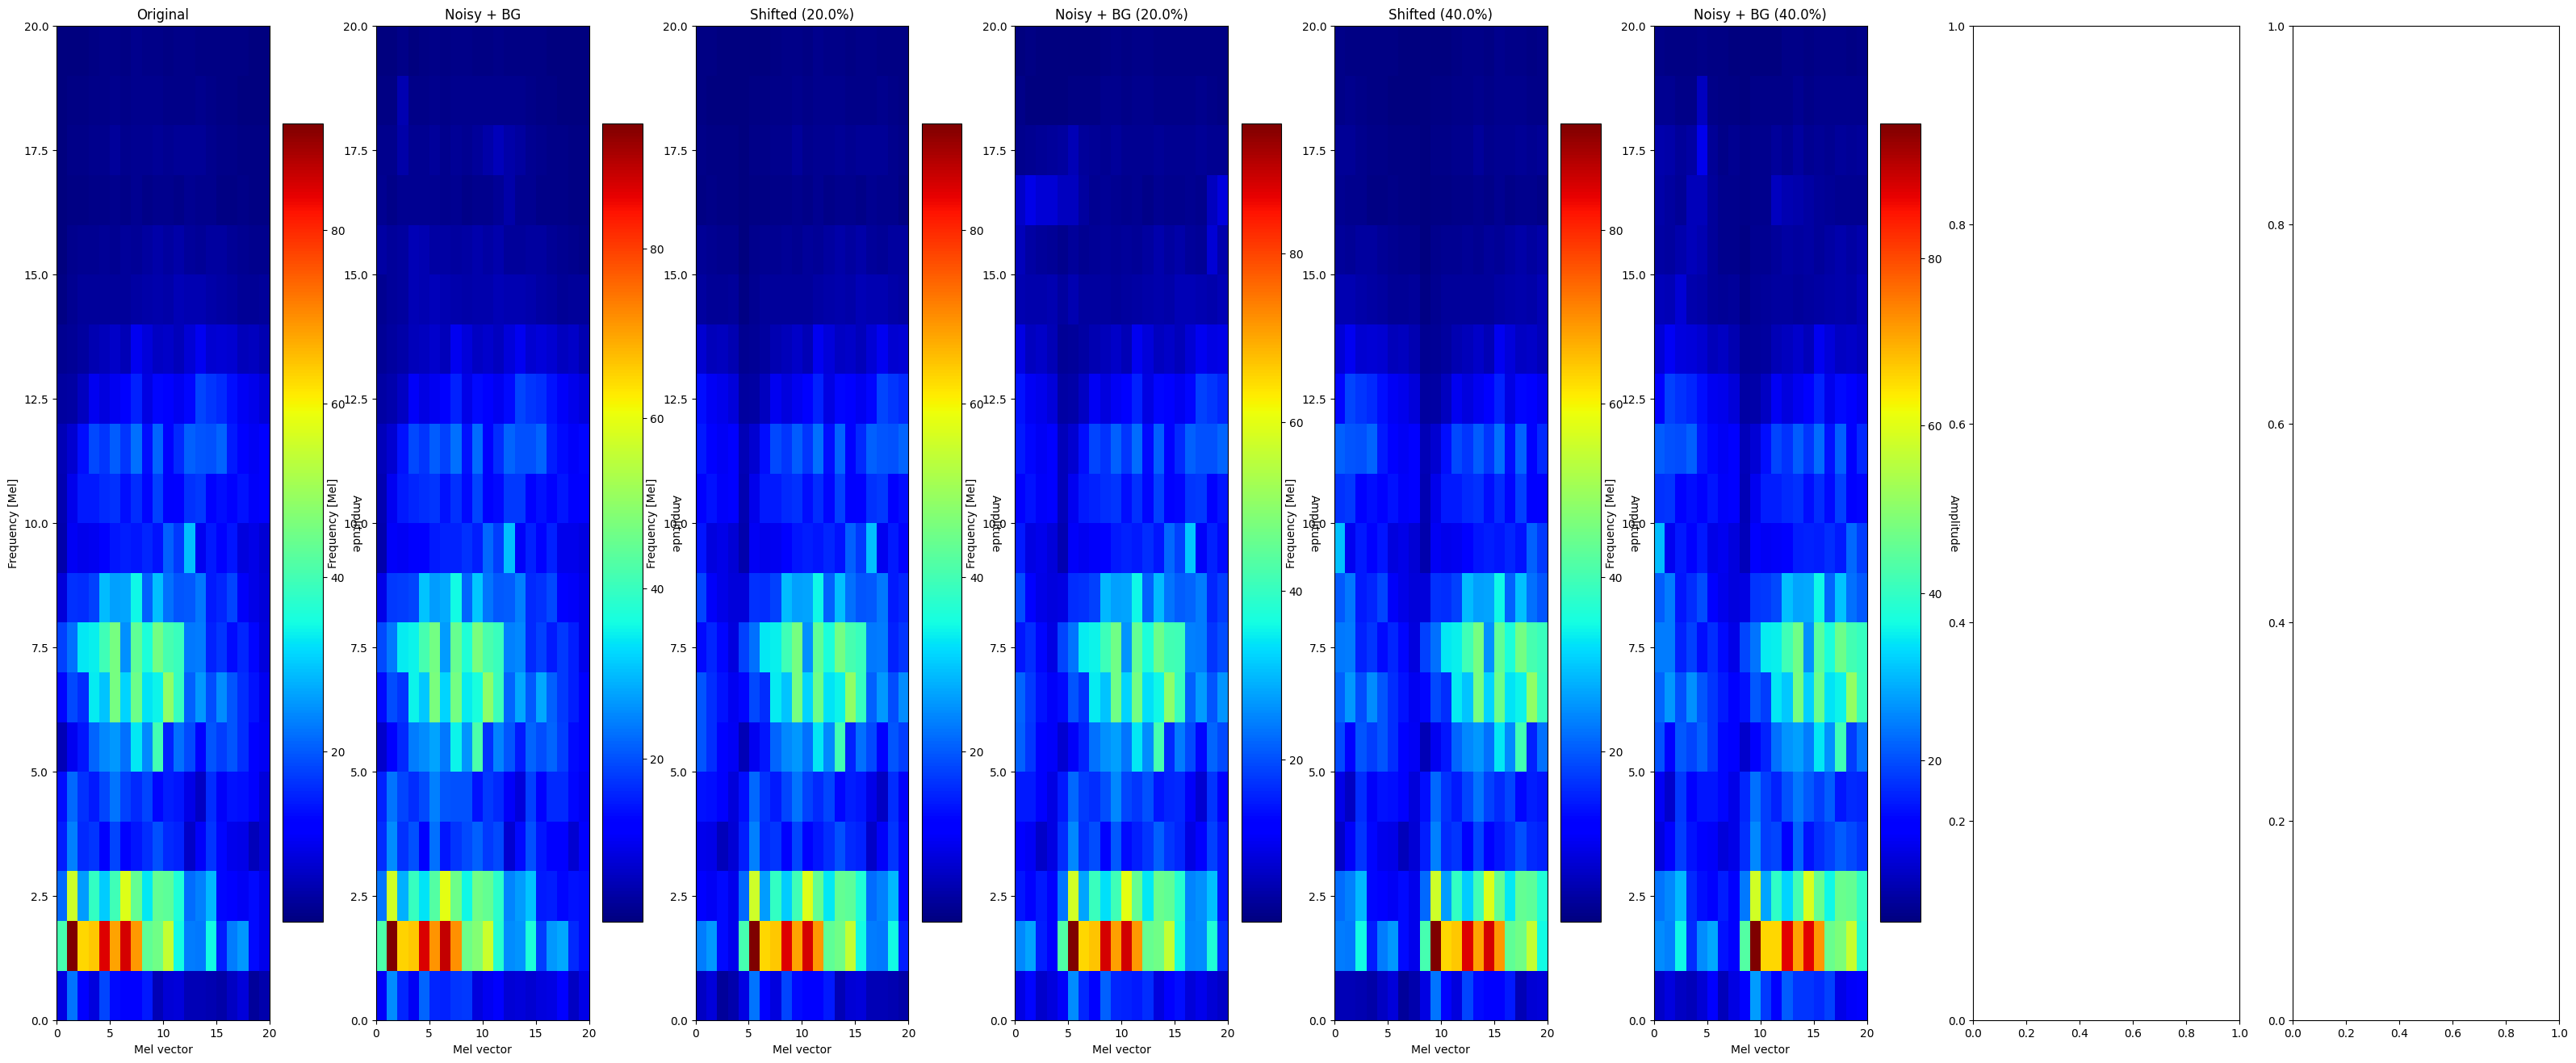

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt

index = 0
for i, (vector, label) in enumerate(tqdm(zip(X_train_aug[:10], y_train_aug[:10]), total=len(X_train), desc="Augmentation du training set")):
    fig, axes = plt.subplots(1, 8, figsize=(40, 16))  # Créez une figure avec 7 sous-graphiques

    # Ajouter le vecteur original
    vector = X_train_aug[index]
    label = y_train_aug[index]
    plot_specgram(
        vector.reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1
    # Ajouter le vecteur bruité avec bruit de fond
    noisy_with_bg_vector_base = X_train_aug[index]
    label = y_train_aug[index]
    plot_specgram(
        noisy_with_bg_vector_base.reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy + BG",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1
    # Appliquer les augmentations pour chaque shift_pct
    for j, shift_pct in enumerate(shift_pcts):
        # Décalage temporel
        shifted_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            shifted_vector.reshape((20, 20)), 
            ax=axes[2 + j * 2],
            is_mel=True,
            title=f"Shifted ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1



        # Bruit de fond
        noisy_with_bg_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            noisy_with_bg_vector.reshape((20, 20)), 
            ax=axes[3 + j * 2],
            is_mel=True,
            title=f"Noisy + BG ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1

    plt.suptitle(f"Augmentations for Sample {i} (Label: {label})")
    plt.tight_layout()
    plt.show()

    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

In [15]:
# Calculer la taille totale des augmentations pour le test set
n_augmentations_test = len(X_test) * 2  # Original + Noise + Background noise
X_test_aug = np.zeros((n_augmentations_test, X_test.shape[1]))
y_test_aug = np.zeros(n_augmentations_test, dtype=y_test.dtype)

# Remplir les tableaux préalloués pour le test set
index = 0
for vector, label in tqdm(zip(X_test, y_test), total=len(X_test), desc="Augmentation du test set"):
    # Ajouter le vecteur original
    X_test_aug[index] = vector
    y_test_aug[index] = label
    index += 1

    # Ajouter le bruit de fond
    noisy_with_bg_vector = add_background_noise_vector(vector, desired_snr_db=20)
    X_test_aug[index] = noisy_with_bg_vector
    y_test_aug[index] = label
    index += 1

# Afficher les dimensions des matrices augmentées
print(f"Shape of the training feature matrix : {X_train_aug.shape}")
print(f"Number of training labels : {len(y_train_aug)}")
print(f"Shape of the test feature matrix : {X_test_aug.shape}")
print(f"Number of test labels : {len(y_test_aug)}")

Augmentation du test set: 100%|██████████| 48/48 [01:38<00:00,  2.05s/it]

Shape of the training feature matrix : (896, 400)
Number of training labels : 896
Shape of the test feature matrix : (96, 400)
Number of test labels : 96


Affichage des augmentations du test set:   0%|          | 0/5 [00:00<?, ?it/s]

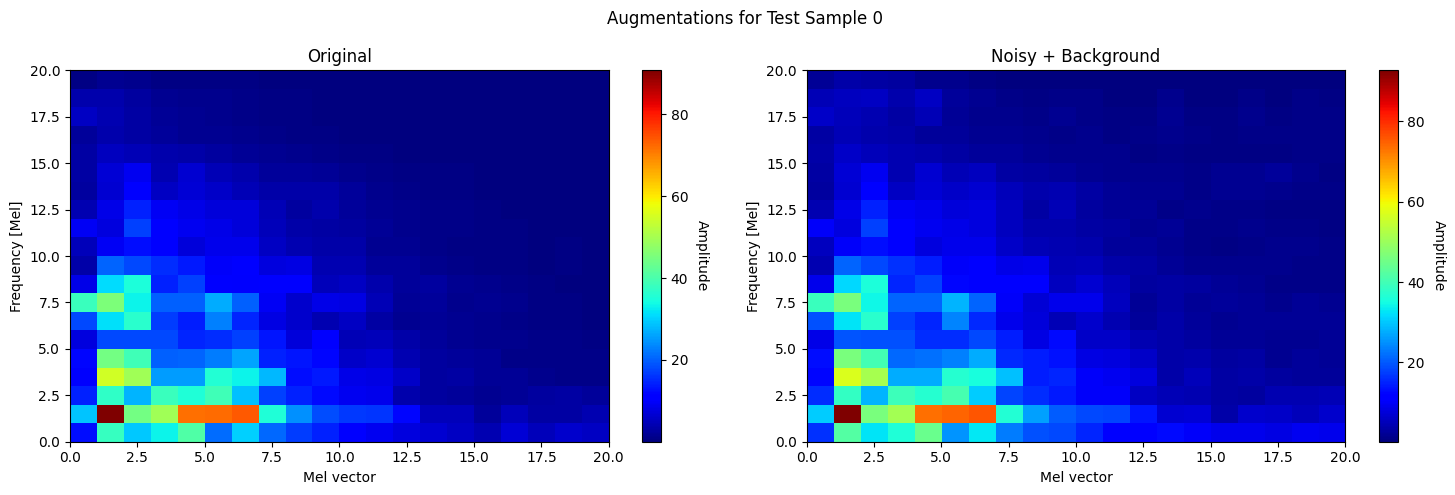

Affichage des augmentations du test set:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Label: gun


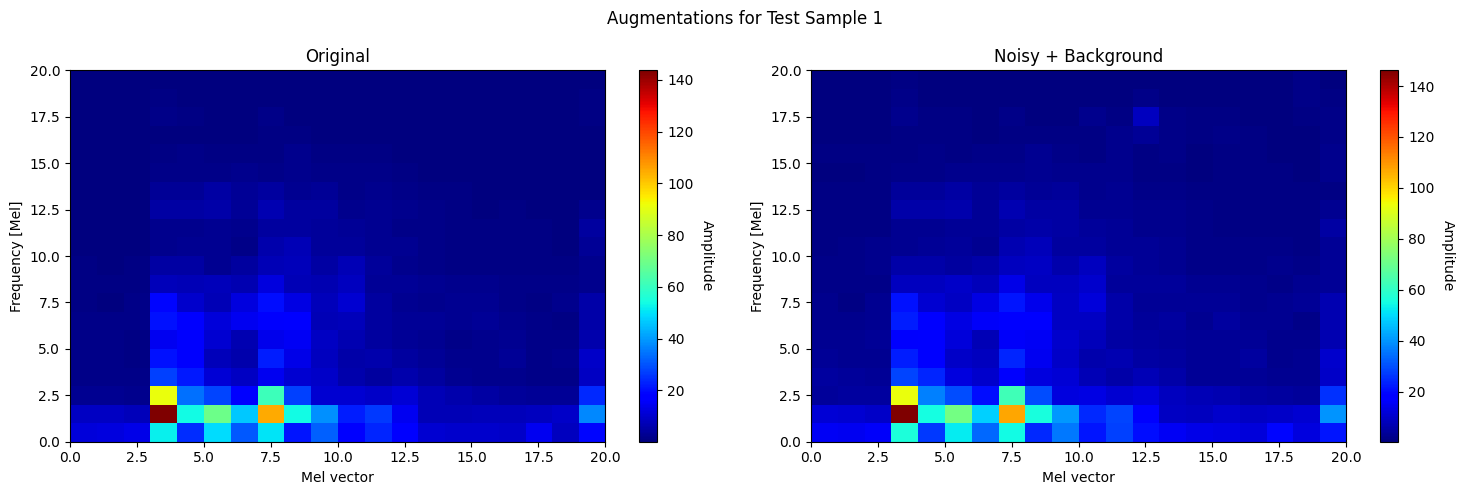

Affichage des augmentations du test set:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Label: gun


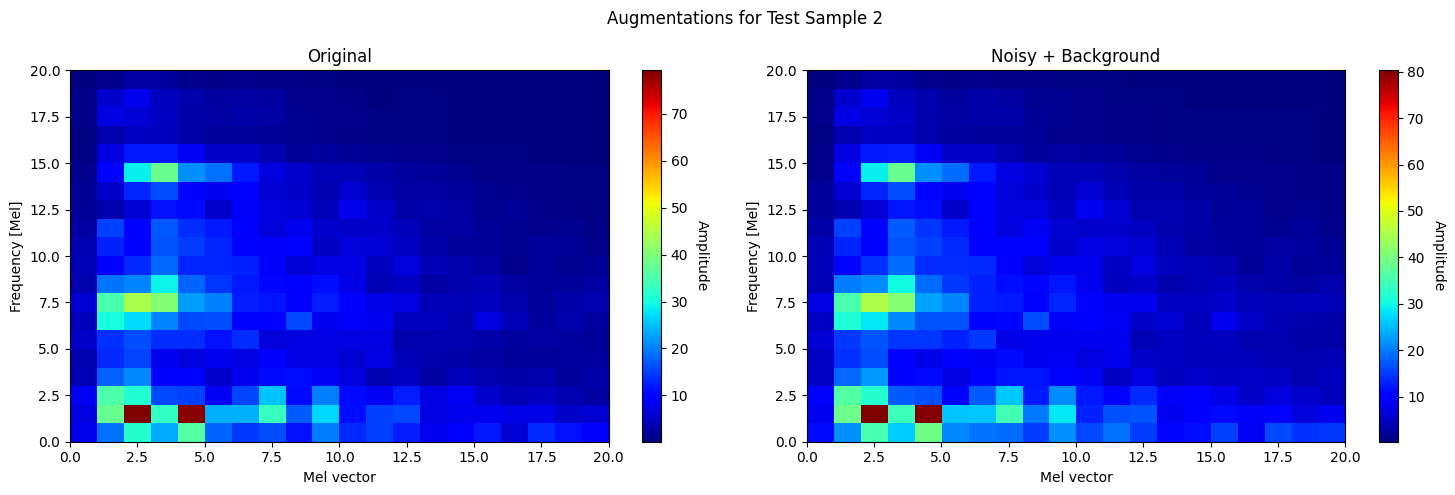

Affichage des augmentations du test set:  60%|██████    | 3/5 [00:02<00:01,  1.50it/s]

Label: fireworks


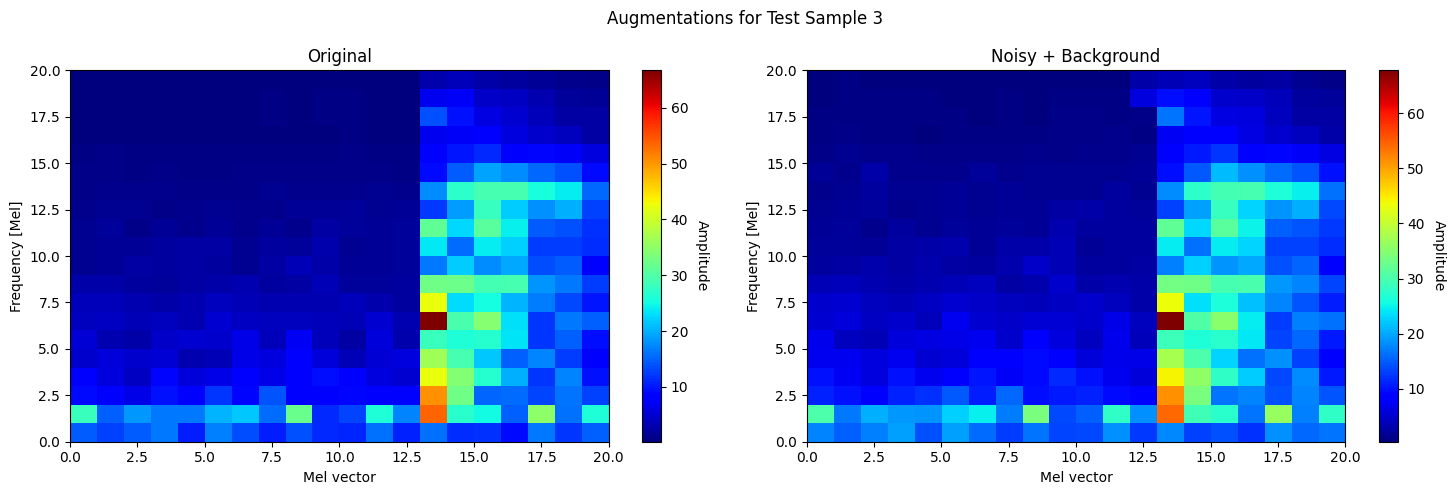

Affichage des augmentations du test set:  80%|████████  | 4/5 [00:02<00:00,  1.51it/s]

Label: fireworks


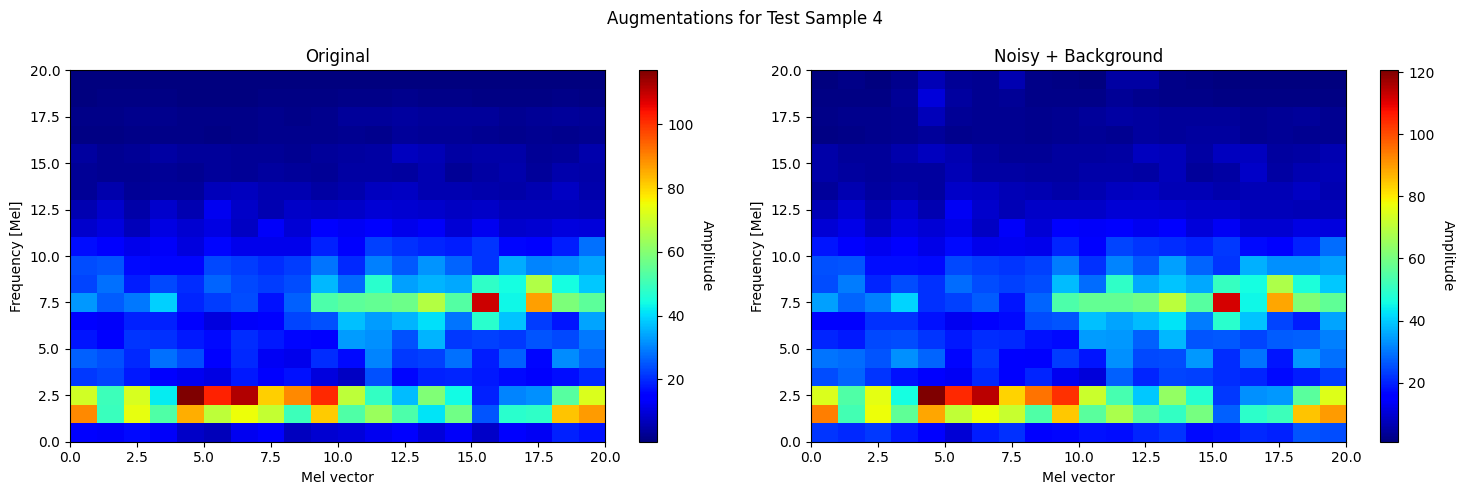

Affichage des augmentations du test set:  80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

Label: gun


In [16]:
index = 0
for i, vector in enumerate(tqdm(X_test[:5], desc="Affichage des augmentations du test set")):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Créez une figure avec 3 sous-graphiques

    # Afficher le vecteur original depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1



    # Afficher le vecteur avec bruit de fond depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy + Background",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    plt.suptitle(f"Augmentations for Test Sample {i}")
    plt.tight_layout()
    plt.show()
    print(f"Label: {y_test_aug[i]}")
    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 4:
        break

In [55]:
# Résumé des augmentations effectuées :
# Train set :
# 1. Vecteur original
# 2. Décalage temporel (time shift) avec plusieurs pourcentages (shift_pcts)
# 3. Ajout de bruit gaussien (SNR = 20 dB)
# 4. Ajout de bruit de fond (SNR = 20 dB)

# Test set :
# 1. Vecteur original
# 2. Ajout de bruit gaussien (SNR = 20 dB)
# 3. Ajout de bruit de fond (SNR = 20 dB)


# à la toute fin pour le modèle final
# 4. Décalage temporel (time shift) avec plusieurs pourcentages (shift_pcts)
# sur le test set

In [17]:
mean_x_train = np.mean(X_train_aug, axis=1, keepdims=True)
norm_x_train = np.linalg.norm(X_train_aug, axis=1, keepdims=True)

X_train_aug_centered_normalized = (X_train_aug - mean_x_train) / norm_x_train

mean_x_test = np.mean(X_test_aug, axis=1, keepdims=True)
norm_x_test = np.linalg.norm(X_test_aug, axis=1, keepdims=True)

X_test_aug_centered_normalized = (X_test_aug - mean_x_test) / norm_x_test

np.save(fm_dir + "feature_matrix_train_balanced.npy", X_train_aug_centered_normalized)
np.save(fm_dir + "label_train_balanced.npy", y_train_aug)
np.save(fm_dir + "feature_matrix_test_balanced.npy", X_test_aug_centered_normalized)
np.save(fm_dir + "label_test_balanced.npy", y_test_aug)

X_train_aug = np.load(fm_dir + "feature_matrix_train_balanced.npy")
y_train_aug = np.load(fm_dir + "label_train_balanced.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_test_balanced.npy")
y_test_aug = np.load(fm_dir + "label_test_balanced.npy", allow_pickle=True)


print(f"Shape of the training feature matrix : {X_train_aug.shape}")
print(f"Number of training labels : {y_train_aug.shape}")
print(f"Shape of the test feature matrix : {X_test_aug.shape}")
print(f"Number of test labels : {y_test_aug.shape}")


Shape of the training feature matrix : (896, 400)
Number of training labels : (896,)
Shape of the test feature matrix : (96, 400)
Number of test labels : (96,)


Augmentation du training set:   0%|          | 0/112 [00:00<?, ?it/s]

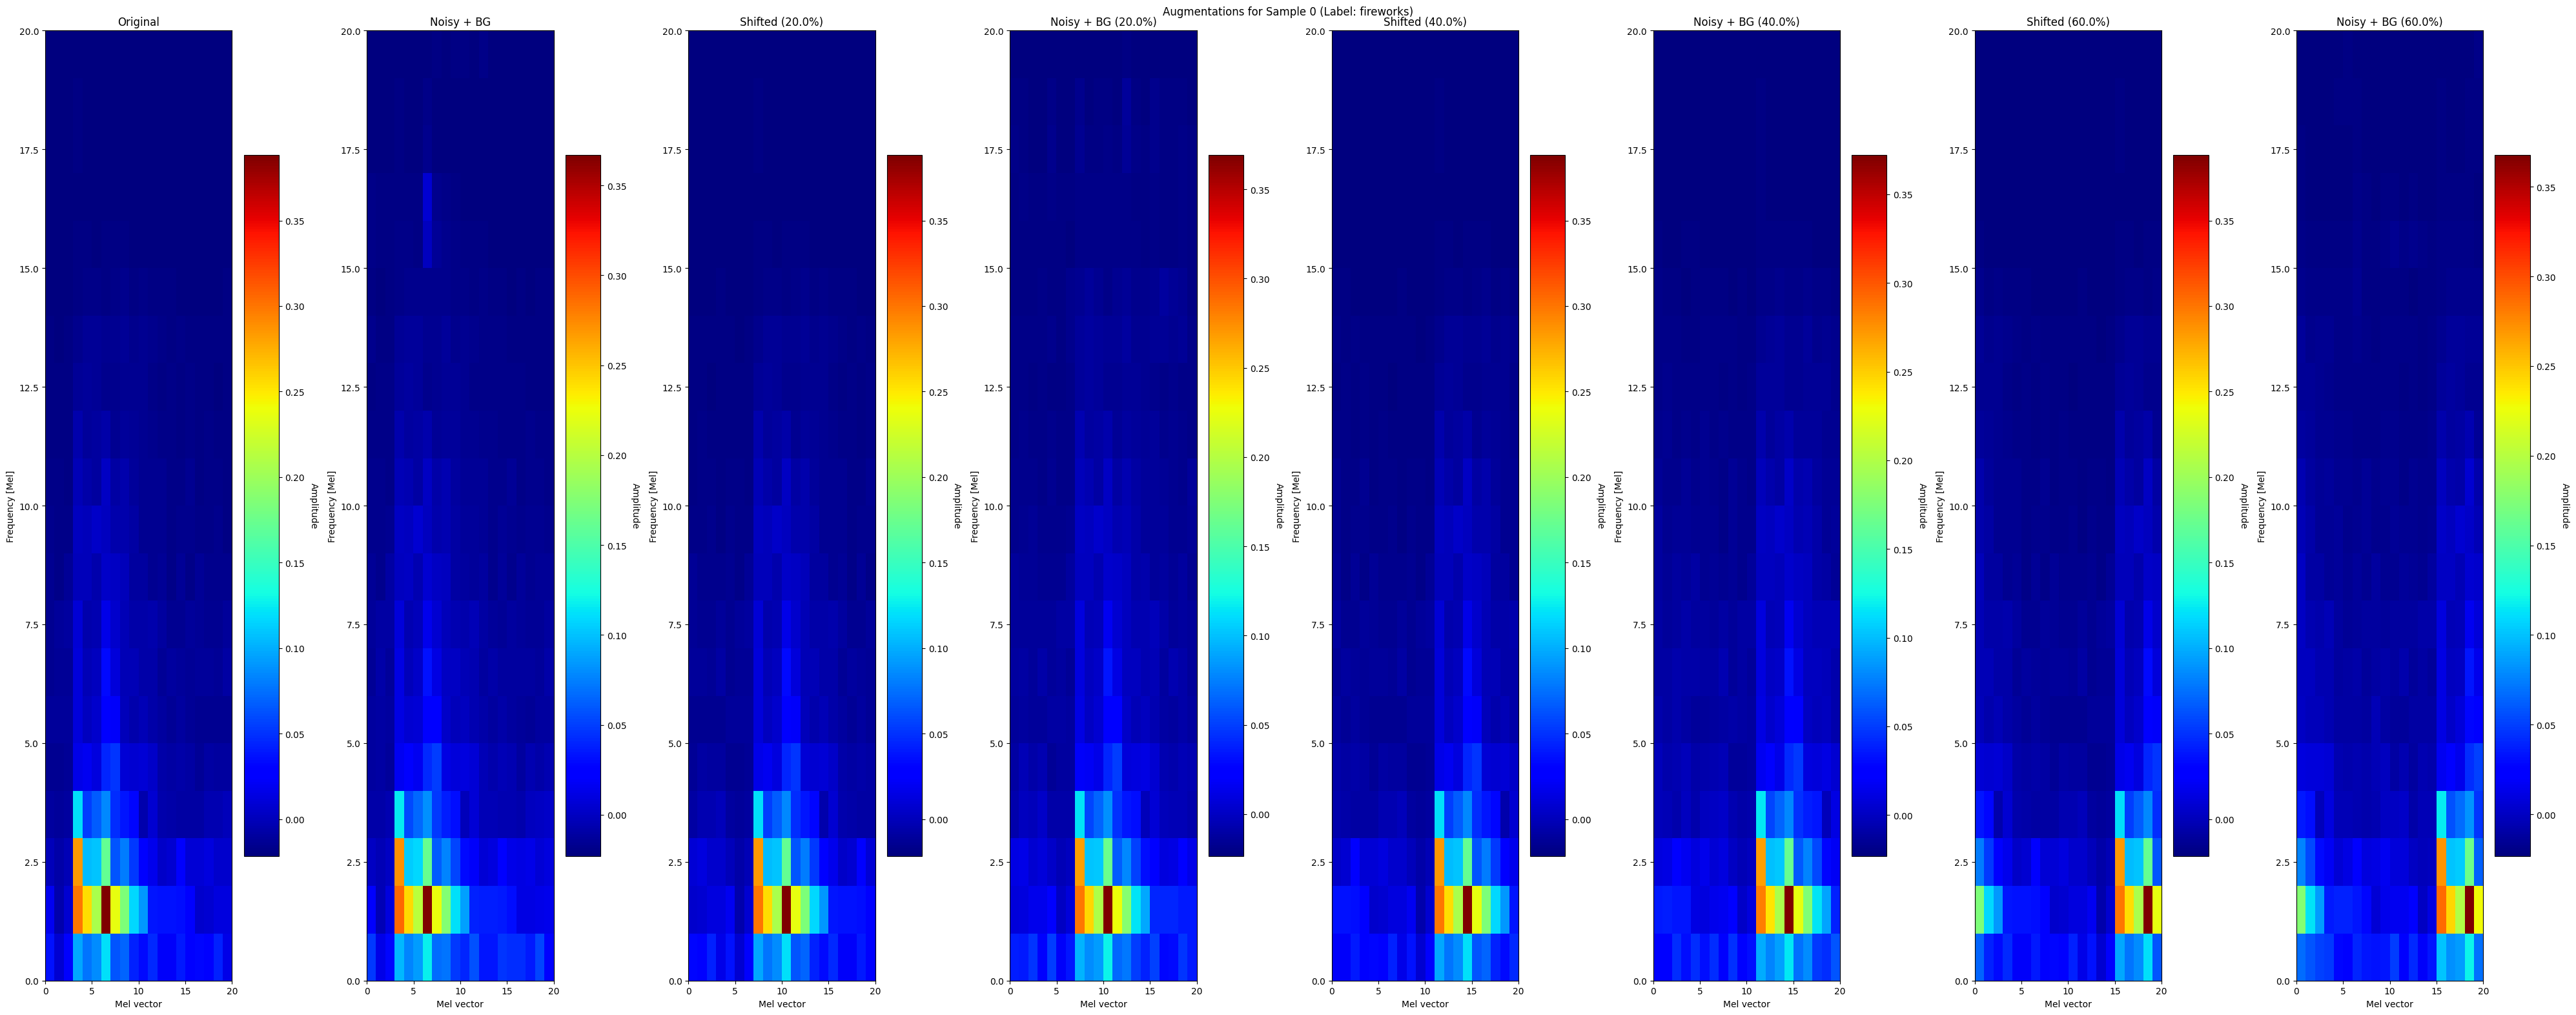

Augmentation du training set:   1%|          | 1/112 [00:07<13:03,  7.06s/it]

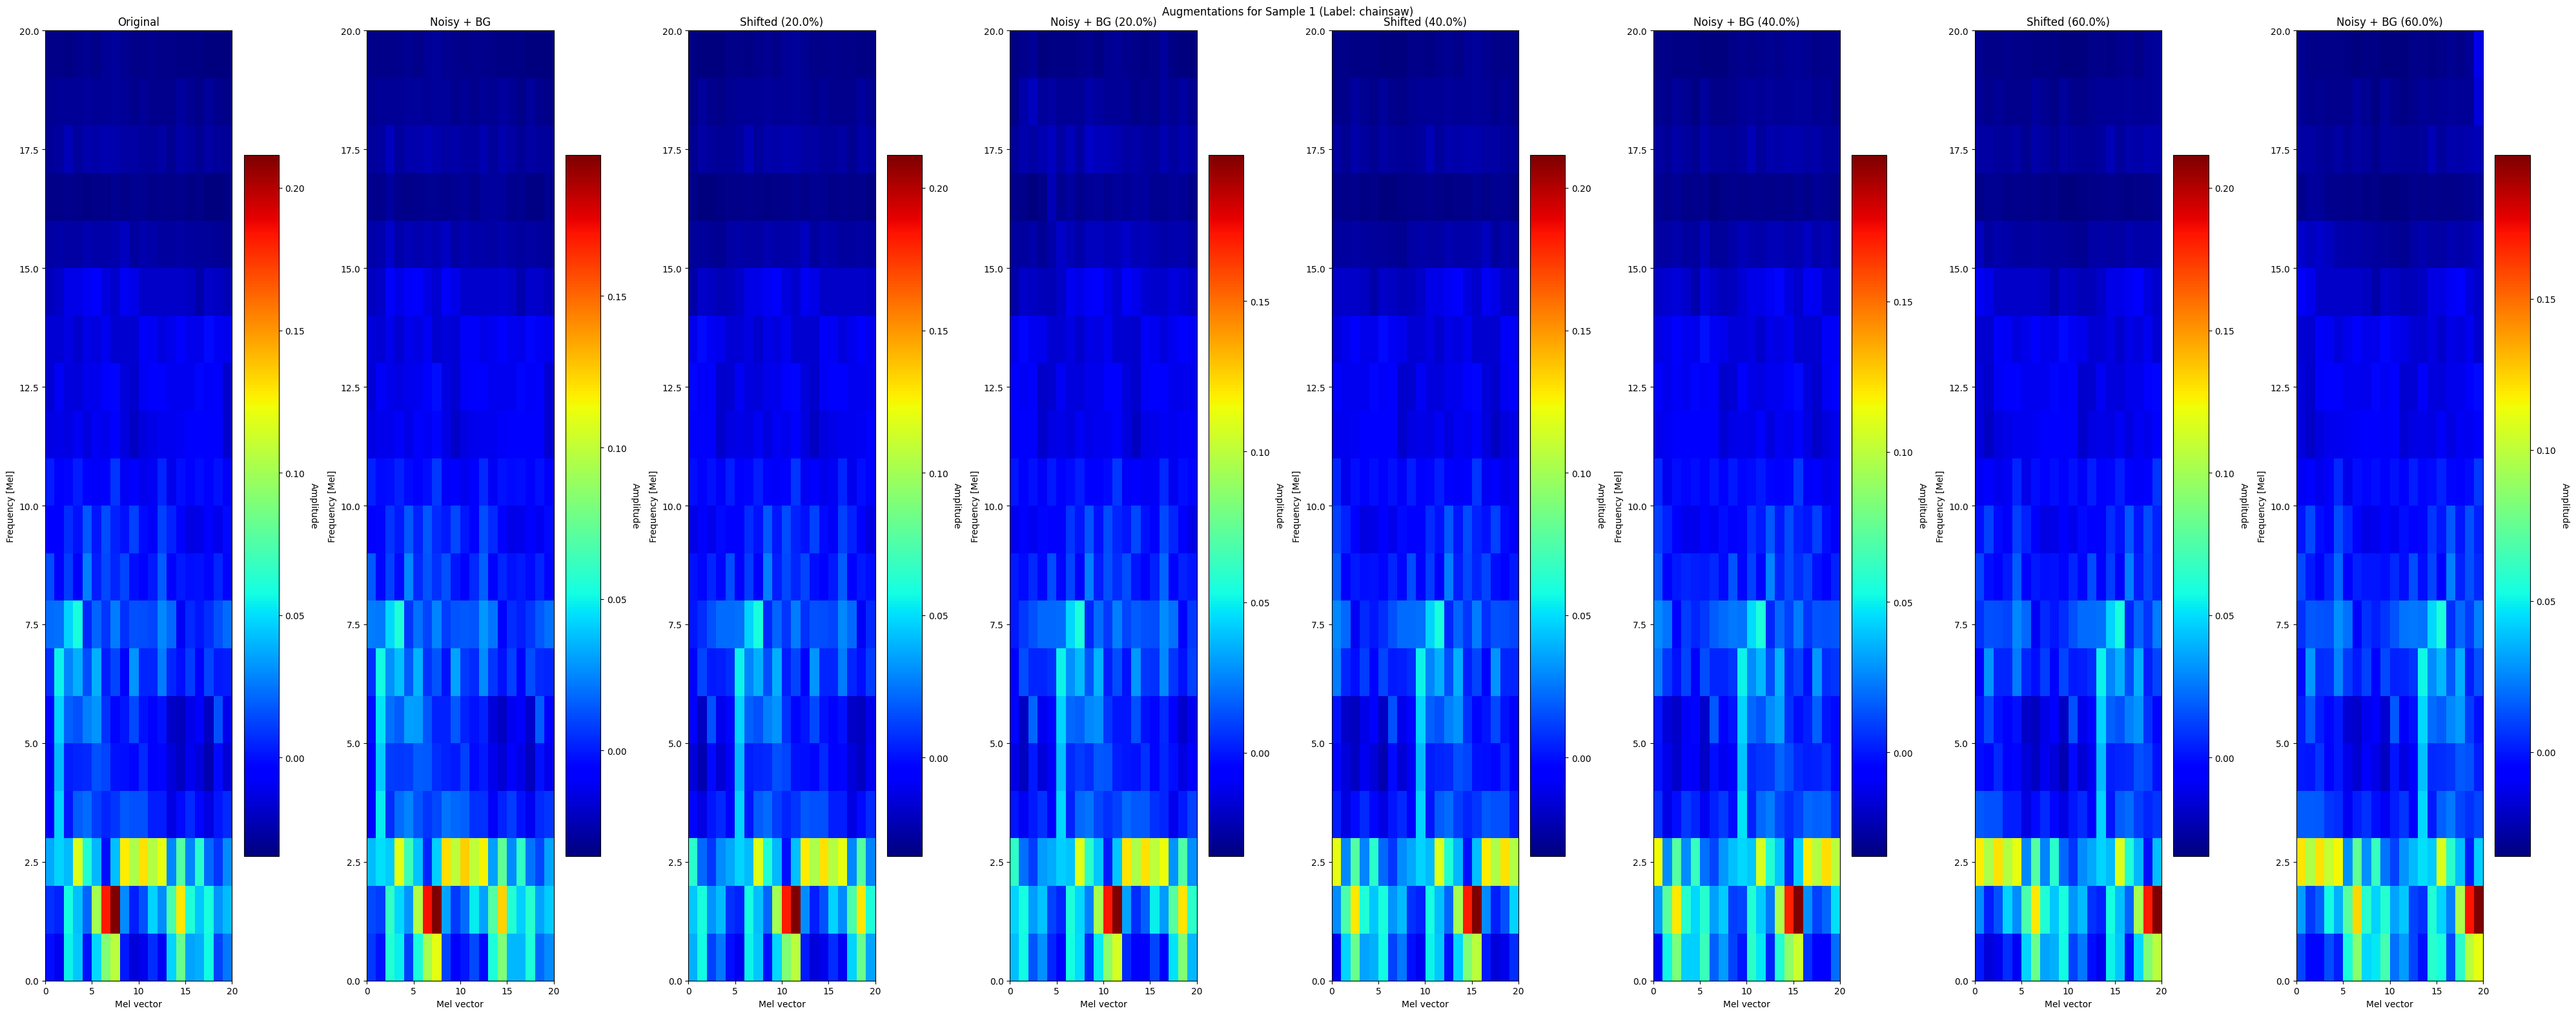

Augmentation du training set:   2%|▏         | 2/112 [00:13<12:23,  6.76s/it]

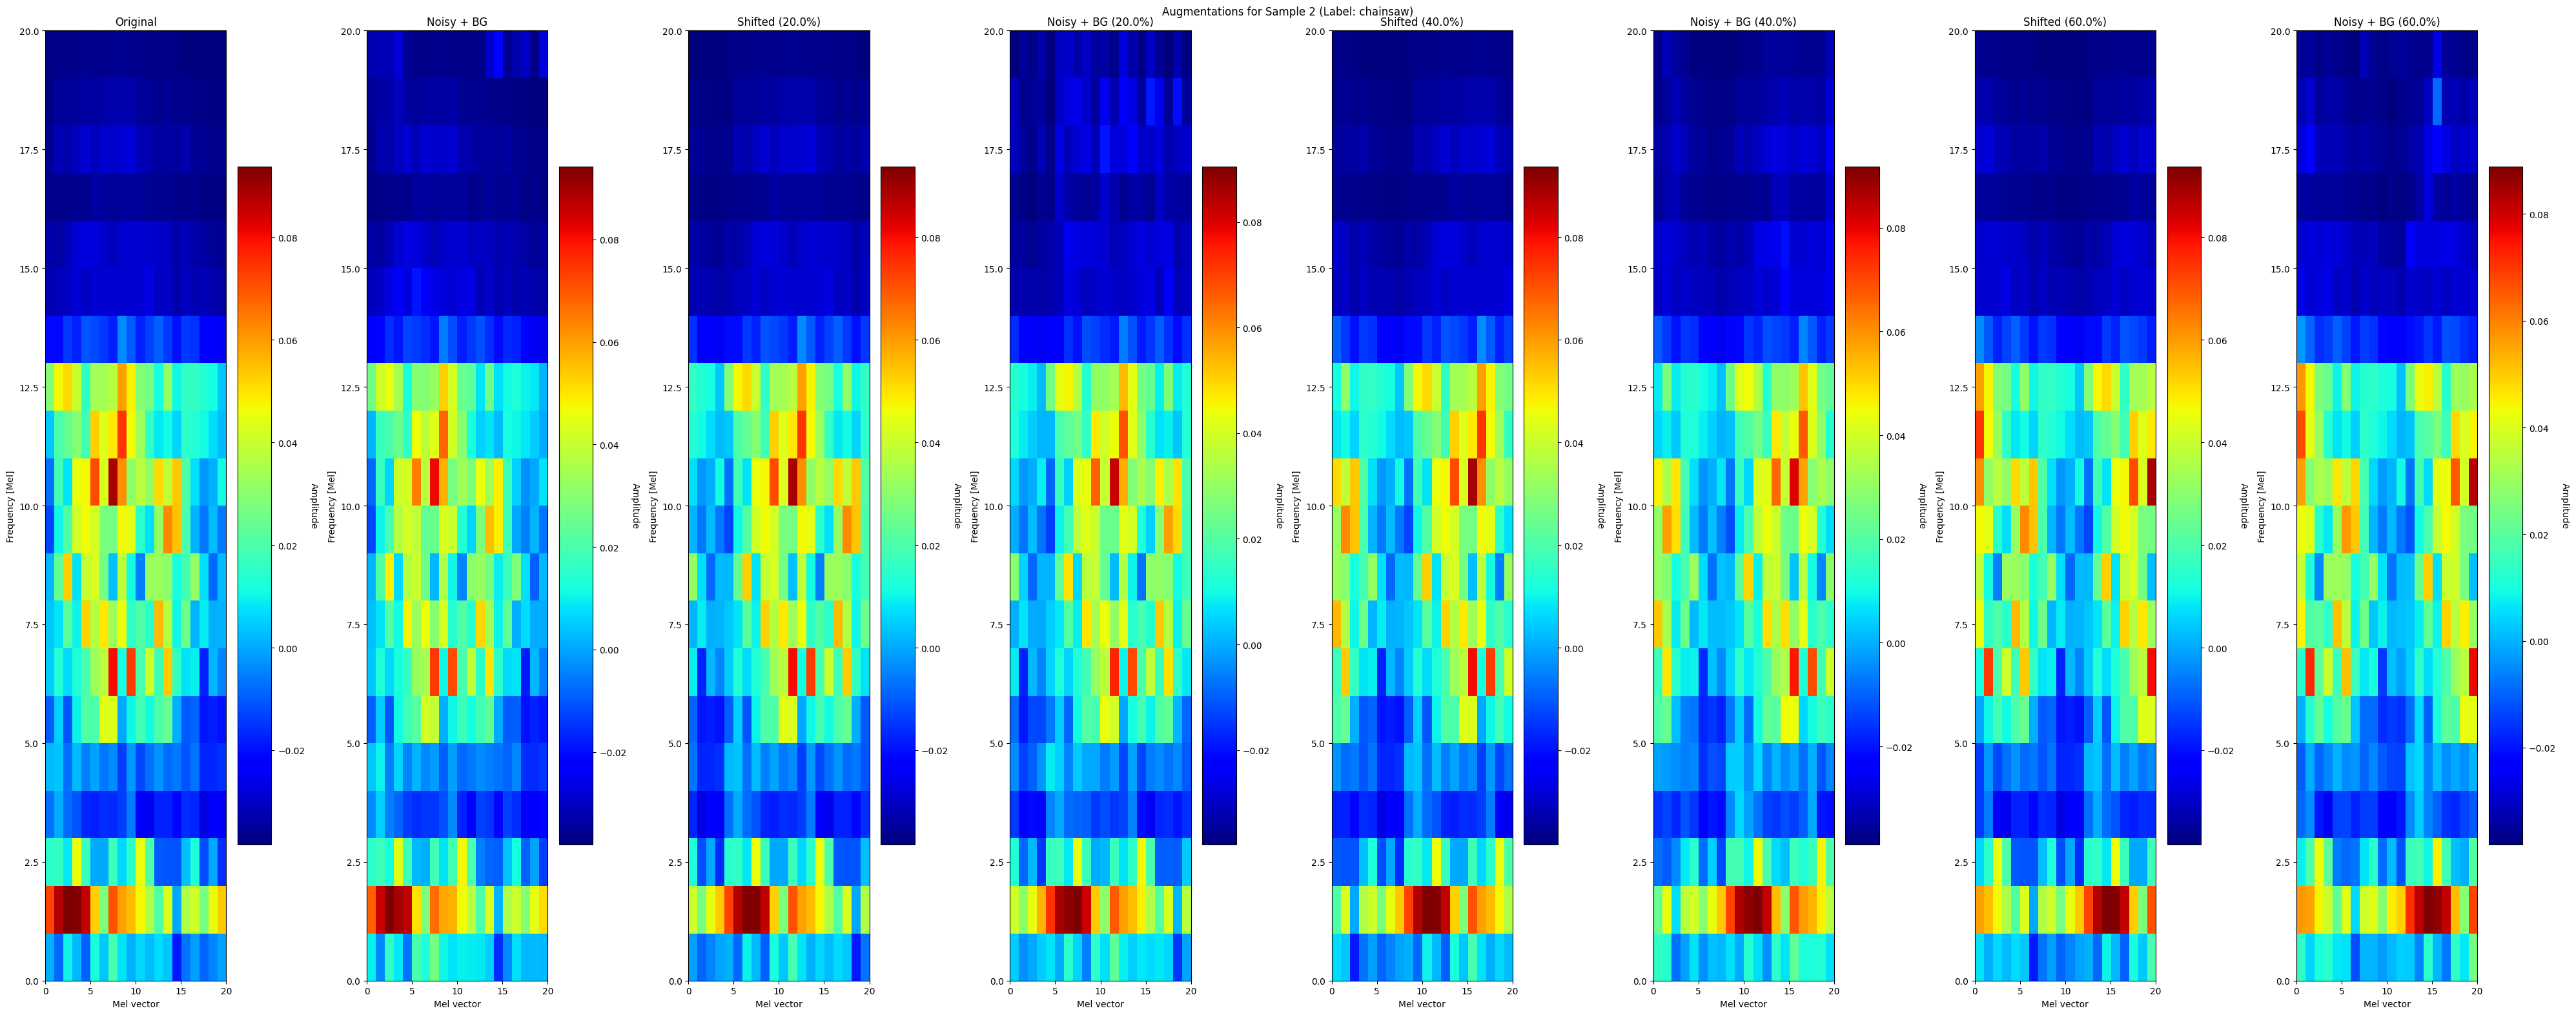

Augmentation du training set:   3%|▎         | 3/112 [00:21<13:01,  7.17s/it]


KeyboardInterrupt: 

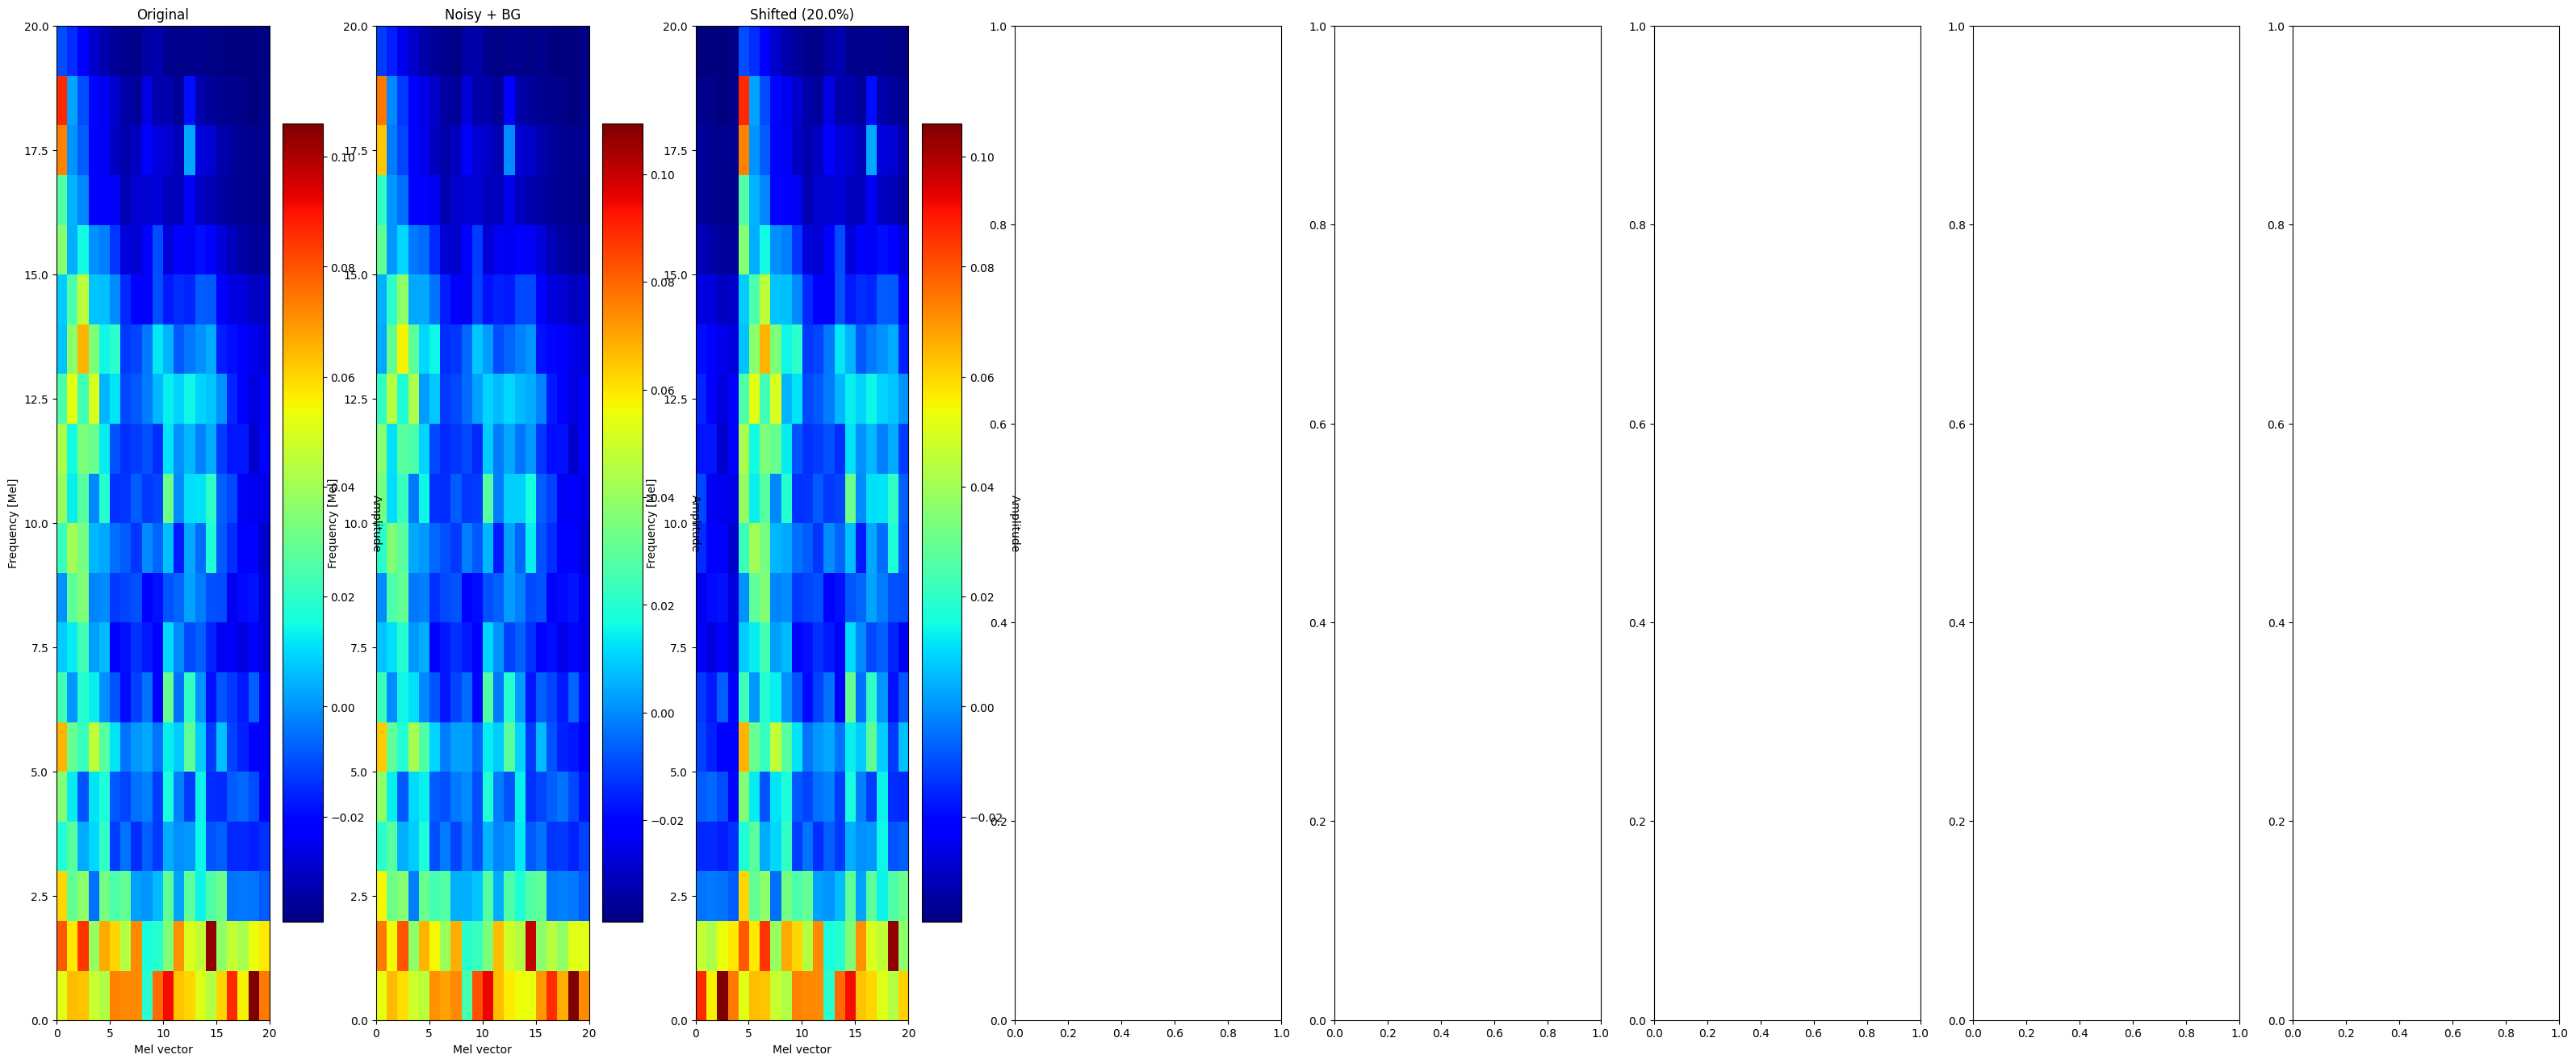

In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt

index = 0
for i, (vector, label) in enumerate(tqdm(zip(X_train [:10], y_train[:10]), total=len(X_train), desc="Augmentation du training set")):
    fig, axes = plt.subplots(1, 8, figsize=(40, 16))  # Créez une figure avec 7 sous-graphiques

    # Ajouter le vecteur original
    vector = X_train_aug[index]
    label = y_train_aug[index]
    plot_specgram(
        vector.reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1
    # Ajouter le vecteur bruité avec bruit de fond
    noisy_with_bg_vector_base = X_train_aug[index]
    label = y_train_aug[index]
    plot_specgram(
        noisy_with_bg_vector_base.reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy + BG",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Appliquer les augmentations pour chaque shift_pct
    for j, shift_pct in enumerate(shift_pcts):
        # Décalage temporel
        shifted_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            shifted_vector.reshape((20, 20)), 
            ax=axes[2 + j * 2],
            is_mel=True,
            title=f"Shifted ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1


        # Bruit de fond
        noisy_with_bg_vector = X_train_aug[index]
        label = y_train_aug[index]
        plot_specgram(
            noisy_with_bg_vector.reshape((20, 20)), 
            ax=axes[3 + j * 2],
            is_mel=True,
            title=f"Noisy + BG ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
        index += 1

    plt.suptitle(f"Augmentations for Sample {i} (Label: {label})")
    plt.tight_layout()
    plt.show()

    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

Affichage des augmentations du test set:   0%|          | 0/10 [00:00<?, ?it/s]

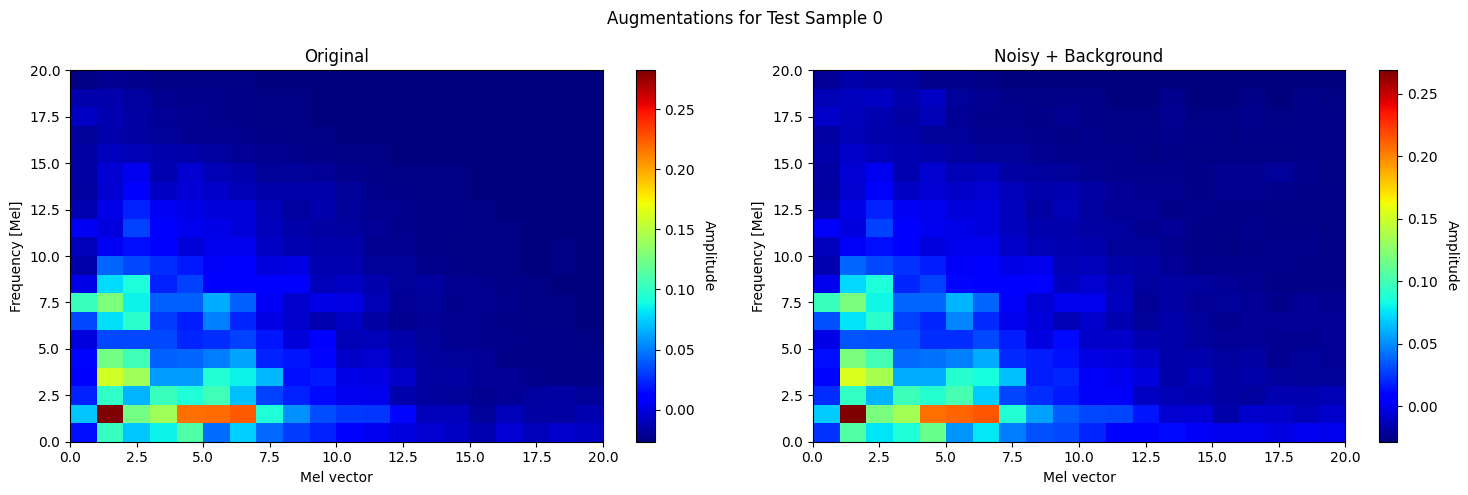

Affichage des augmentations du test set:  10%|█         | 1/10 [00:00<00:06,  1.43it/s]

Label: gun


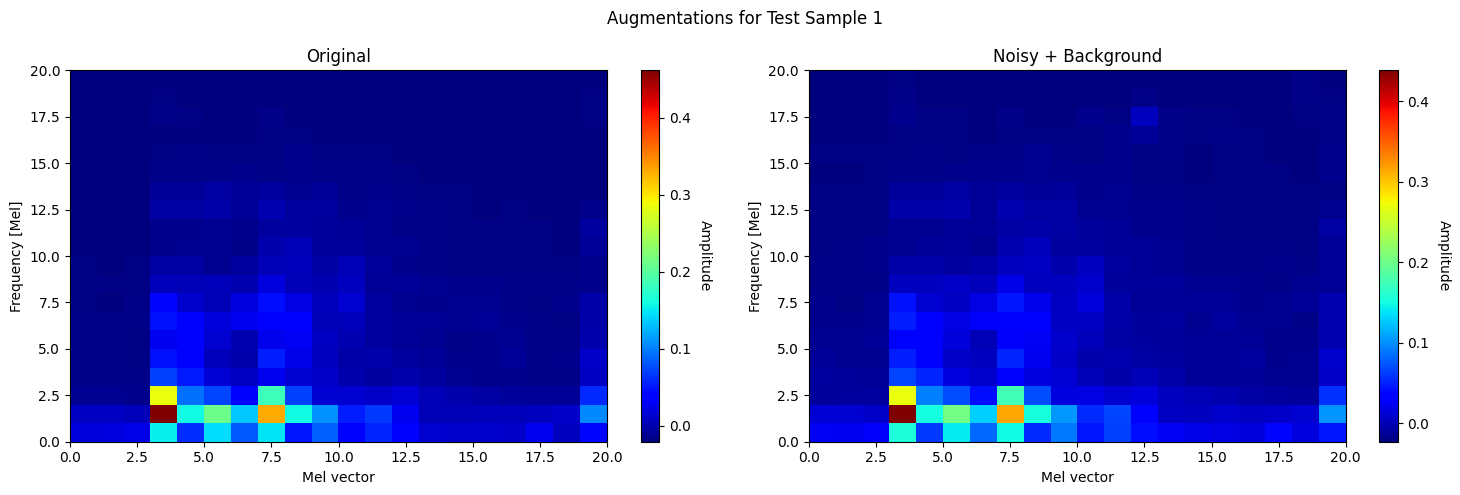

Affichage des augmentations du test set:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Label: gun


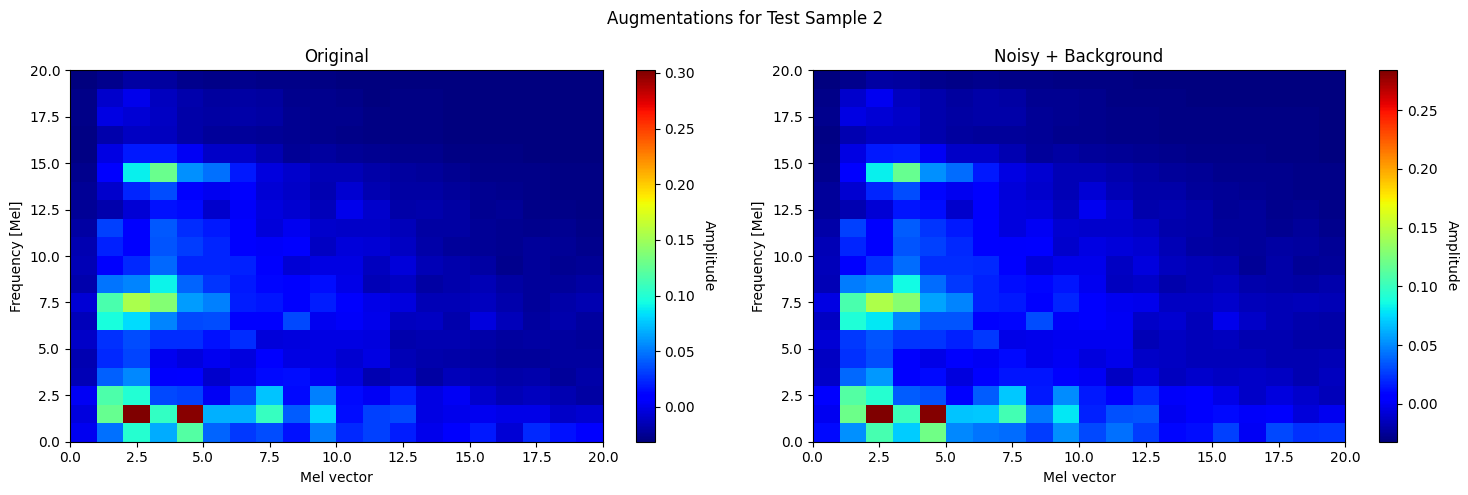

Affichage des augmentations du test set:  30%|███       | 3/10 [00:02<00:04,  1.48it/s]

Label: fireworks


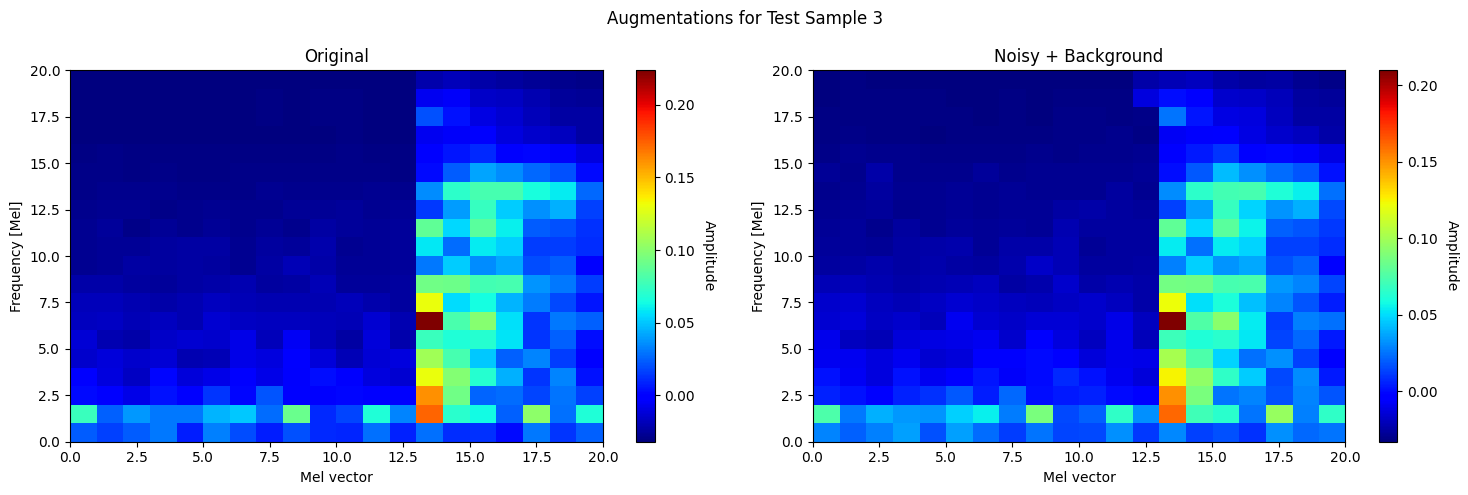

Affichage des augmentations du test set:  40%|████      | 4/10 [00:02<00:03,  1.50it/s]

Label: fireworks


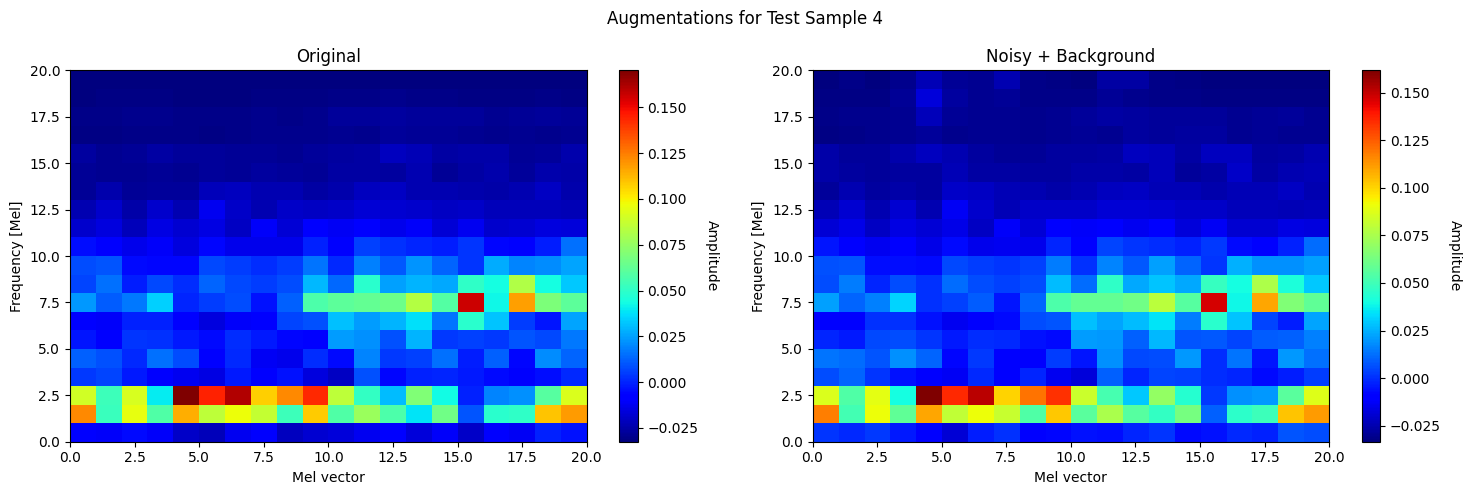

Affichage des augmentations du test set:  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

Label: gun


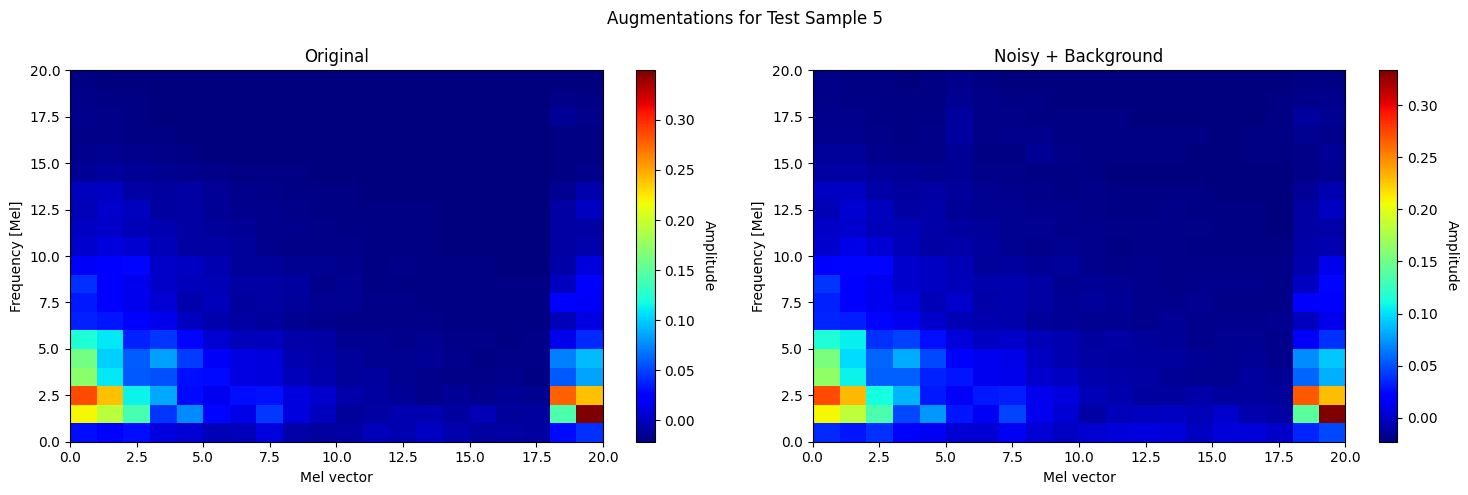

Affichage des augmentations du test set:  60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

Label: gun


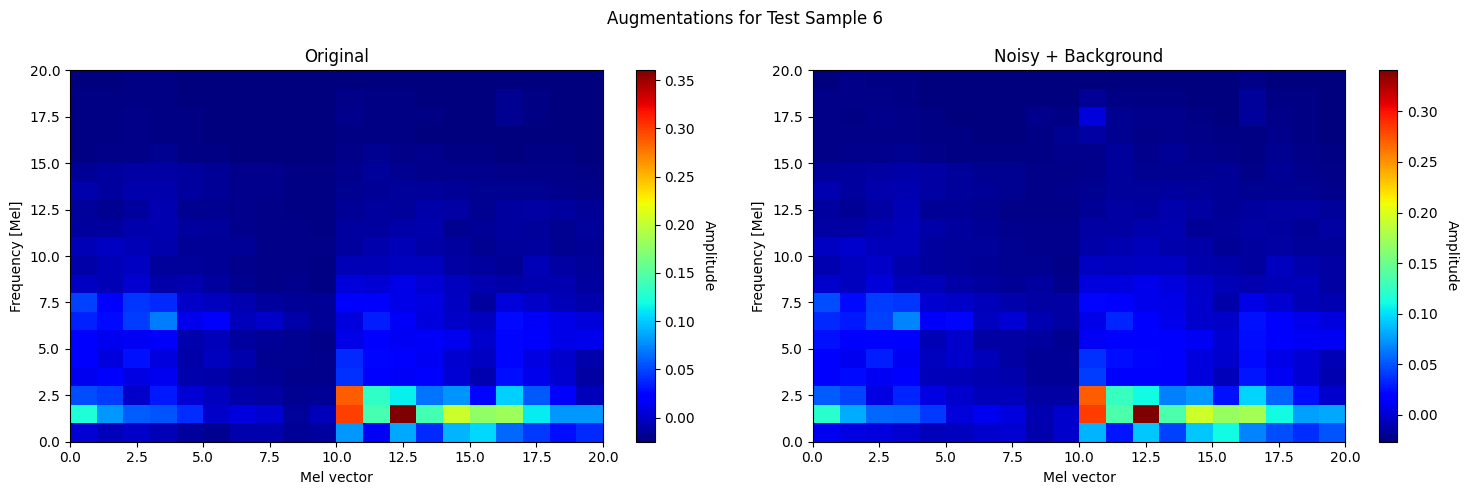

Affichage des augmentations du test set:  70%|███████   | 7/10 [00:04<00:02,  1.42it/s]

Label: fire


KeyboardInterrupt: 

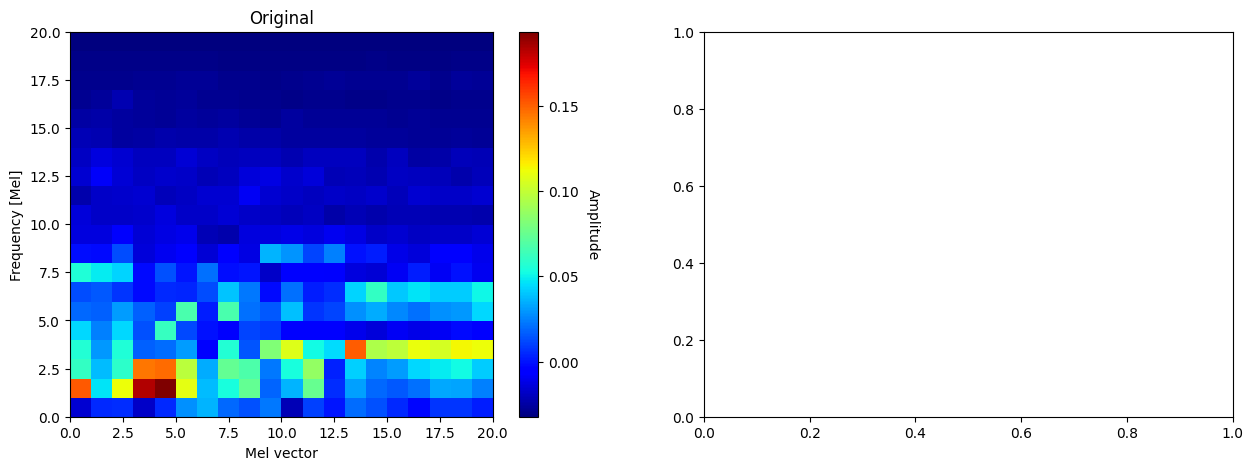

In [20]:
index = 0
for i, vector in enumerate(tqdm(X_test[:10], desc="Affichage des augmentations du test set")):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Créez une figure avec 3 sous-graphiques

    # Afficher le vecteur original depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    # Afficher le vecteur avec bruit de fond depuis X_test_aug
    plot_specgram(
        X_test_aug[index].reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy + Background",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    index += 1

    plt.suptitle(f"Augmentations for Test Sample {i}")
    plt.tight_layout()
    plt.show()
    print(f"Label: {y_test_aug[i]}")
    # Limiter à un certain nombre d'exemples pour éviter trop de graphiques
    if i >= 9:
        break

In [26]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

# Définir la fonction objectif pour Optuna
def objective(trial):
    # Définir les hyperparamètres à optimiser
    n_estimators = trial.suggest_int("n_estimators",100, 500, step=100)
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.001, step=0.0025)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Créer le modèle avec les hyperparamètres suggérés
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        max_features=max_features,
        random_state=42,
    )

    # Évaluer le modèle avec une validation croisée
    scores = cross_val_score(
        rf, X_train_aug, y_train_aug, cv=4, scoring=make_scorer(accuracy)
    )
    return np.mean(scores)

# # Créer une étude Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
study = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_impurity_decrease': 0.0,
    'max_features': 'sqrt'
}

# Créer le modèle Random Forest avec les paramètres optimaux
rf_model = RandomForestClassifier(**study)



In [28]:
# Entraîner le modèle final avec les meilleurs hyperparamètres
rf_model = RandomForestClassifier(**study, random_state=42)
rf_model.fit(X_train_aug, y_train_aug)


RandomForestClassifier(max_depth=20, random_state=42)

In [29]:

# Évaluer le modèle sur le test set
y_test_pred = rf_model.predict(X_test_aug)
test_score = accuracy(y_test_aug, y_test_pred)
print(f"accuracy on the test set: {test_score:.4f}")

accuracy on the test set: 0.8229


In [ ]:
X_train_aug = np.load(fm_dir + "feature_matrix_train_balanced.npy")
y_train_aug = np.load(fm_dir + "label_train_balanced.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_test_balanced.npy")
y_test_aug = np.load(fm_dir + "label_test_balanced.npy", allow_pickle=True)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm  


# Entraîner le modèle Random Forest sans PCA
best_rf = RandomForestClassifier(**study, random_state=42)

best_rf.fit(X_train_aug, y_train_aug)

# Évaluer le modèle sur le test set sans PCA
y_test_pred_no_pca = best_rf.predict(X_test_aug)
test_accuracy_no_pca = accuracy(y_test_aug, y_test_pred_no_pca)

# Stocker la précision sans PCA
accuracies_with_pca = []
pca_components = list(range(1, 51,2))
best_score = 0
best_n_components = None

# Appliquer PCA et évaluer le modèle avec PCA
for n_components in tqdm(pca_components, desc="Evaluating PCA components"):
    pca = PCA(n_components=n_components, whiten=True)
    X_train_pca = pca.fit_transform(X_train_aug)
    X_test_pca = pca.transform(X_test_aug)

    # Entraîner le modèle Random Forest avec PCA
    best_rf.fit(X_train_pca, y_train_aug)

    # Évaluer le modèle sur le test set avec PCA
    y_test_pred_with_pca = best_rf.predict(X_test_pca)
    test_accuracy_with_pca = accuracy(y_test_aug, y_test_pred_with_pca)
    accuracies_with_pca.append(test_accuracy_with_pca)
    # Mettre à jour la meilleure valeur si nécessaire
    if test_accuracy_with_pca > best_score:
        best_score = test_accuracy_with_pca
        best_n_components = n_components
    
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [test_accuracy_no_pca] * len(pca_components), label="Without PCA", linestyle="--")
plt.plot(pca_components, accuracies_with_pca, label="With PCA", marker="o")
plt.title("Accuracy with and without PCA (Augmented Training Set)")
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy [%]")
plt.legend()
plt.grid(True)

# Sauvegarder le graphique en PDF
pdf_filename = "accuracy_with_without_pca_augmented.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Sauvegarder la figure actuelle
    plt.close()

print(f"Plot saved as {pdf_filename}")

Evaluating PCA components: 100%|██████████| 25/25 [02:02<00:00,  4.90s/it]

Plot saved as balanced_accuracy_with_without_pca_augmented.pdf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


X_train_aug = np.load(fm_dir + "feature_matrix_train_balanced.npy")
y_train_aug = np.load(fm_dir + "label_train_balanced.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_test_balanced.npy")
y_test_aug = np.load(fm_dir + "label_test_balanced.npy", allow_pickle=True)
# Charger les données originales
X = np.load(fm_dir + "feature_matrix_400.npy")
y = np.load(fm_dir + "labels_400.npy", allow_pickle=True)

# Initialiser les listes pour stocker les scores de précision équilibrée
original_scores = []
augmented_scores = []

# Effectuer l'évaluation 10 fois
for _ in range(10):
    # Diviser les données originales en training et test sets
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    rf_model = RandomForestClassifier(**study, random_state=42)

    pca = PCA(n_components=n_components, whiten=True)

    # Entraîner et évaluer sur le dataset original
    rf_model.fit(X_train_orig, y_train_orig)
    y_pred_orig = rf_model.predict(X_test_orig)
    accuracy_orig = accuracy(y_test_orig, y_pred_orig)
    original_scores.append(accuracy_orig)

    X_train_aug_pca = pca.fit_transform(X_train_aug)
    rf_model.fit(X_train_aug_pca, y_train_aug)
    X_test_aug_pca = pca.transform(X_test_aug)

    y_pred_aug = rf_model.predict(X_test_aug_pca)
    
    accuracy_aug = accuracy(y_test_aug, y_pred_aug)
    augmented_scores.append(accuracy_aug)

# Créer un box plot pour comparer les résultats
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of Accuracy Scores for Random Forest Model")
plt.ylabel("Accuracy Score")
plt.grid(True)

# Sauvegarder le graphique en PDF
pdf_filename = "rf_accuracy_comparison.pdf"
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()  # Sauvegarder la figure actuelle
    plt.close()

# Afficher les résultats
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")
print(f"Box plot saved as {pdf_filename}")

Original Dataset: Mean = 0.8667, Std = 0.0000
Augmented Dataset: Mean = 0.8980, Std = 0.0100
Box plot saved as rf_balanced_accuracy_comparison.pdf


/tmp/ipykernel_7892/709154289.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


In [31]:
from sklearn.model_selection import cross_val_score
X_train_aug = np.load(fm_dir + "feature_matrix_train_balanced.npy")
y_train_aug = np.load(fm_dir + "label_train_balanced.npy", allow_pickle=True)
X_test_aug = np.load(fm_dir + "feature_matrix_test_balanced.npy")
y_test_aug = np.load(fm_dir + "label_test_balanced.npy", allow_pickle=True)
# Définir le modèle Random Forest
rf_model = RandomForestClassifier(**study, random_state=42)

# from sklearn.decomposition import PCA

# # Define the PCA model
# pca_model = PCA(n_components=best_n_components, whiten=True)
# X_train_aug = pca_model.fit_transform(X_train_aug)
# X_test_aug = pca_model.transform(X_test_aug)
## count the occurences of each class in the training set
from collections import Counter
class_occurrences = Counter(y_train_aug)
print("Class occurrences in the training set:")
for class_name, count in class_occurrences.items():
    print(f"{class_name}: {count}")
print("Performing cross-validation...")
cv_scores = cross_val_score(
    rf_model, X_train_aug, y_train_aug, cv=5, scoring=make_scorer(accuracy)
)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")

print("Training the final model on the full augmented training set...")
rf_model.fit(X_train_aug, y_train_aug)
model_filename = model_dir + "rf_test_balanced.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(rf_model, model_file)
print(f"Final model saved to {model_filename}")
print("Evaluating the final model on the test set...")
y_test_pred = rf_model.predict(X_test_aug)
test_score = accuracy(y_test_aug, y_test_pred)
print(f"accuracy on the test set: {test_score:.4f}")


Class occurrences in the training set:
fireworks: 224
chainsaw: 224
fire: 224
gun: 224
Performing cross-validation...
Cross-validation scores: [0.86111111 0.80446927 0.80446927 0.90502793 0.81005587]
Mean CV score: 0.8370, Std: 0.0401
Training the final model on the full augmented training set...
Final model saved to data/models/rf_test_balanced.pkl
Evaluating the final model on the test set...
accuracy on the test set: 0.8229


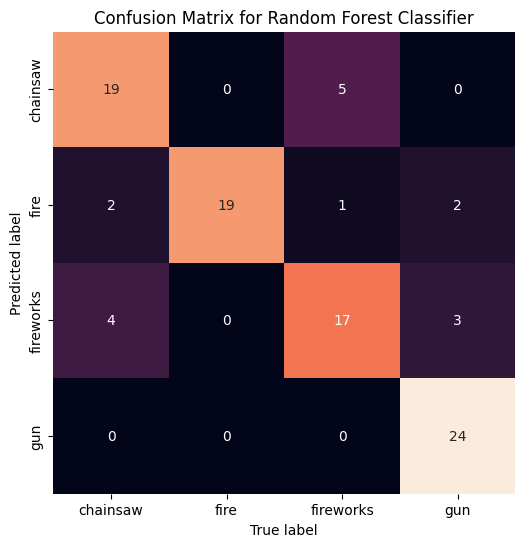

In [32]:

show_confusion_matrix(
    y_test_aug,
    y_test_pred,
    classnames,
    title="Confusion Matrix for Random Forest Classifier"
)

In [ ]:
# import pickle
# import numpy as np
# from tqdm import tqdm

# X = np.load(fm_dir + "feature_matrix_400.npy")
# y = np.load(fm_dir + "labels_400.npy")

# shift_pcts = [0.2,0.4,0.6]

# n_augmentations_per_vector = 1 + 2 + len(shift_pcts) * 3  # Original + (shift + noise + background noise) par shift_pct
# total_aug = len(X) * n_augmentations_per_vector
# print(n_augmentations_per_vector)
# # Préallouer les tableaux pour le training set
# X_aug = np.zeros((total_aug, X.shape[1]))
# y_aug = np.zeros(total_aug, dtype=y.dtype)

# # Remplir les tableaux préalloués pour le training set
# index = 0
# for vector, label in tqdm(zip(X, y), total=len(X), desc="Augmentation du training set"):
#     # Ajouter le vecteur original
#     X_aug[index] = vector
#     y_aug[index] = label
#     # print(f"Index {index}: Original")

#     index += 1
    
#     # Ajouter le vecteur bruité
#     noisy_vector_base = add_noise_vector(vector, desired_snr_db=20)
#     X_aug[index] = noisy_vector_base
#     y_aug[index] = label
    
#     # print(f"Index {index}: Noisy")
#     index += 1
    
#     # Ajouter le vecteur bruité avec bruit de fond
#     noisy_with_bg_vector_base = add_background_noise_vector(noisy_vector_base, desired_snr_db=20)
#     X_aug[index] = noisy_with_bg_vector_base
#     y_aug[index] = label
#     # print(f"Index {index}: Noisy + Background")
#     index += 1
    

#     # Appliquer les augmentations
#     for shift_pct in shift_pcts:
#         shifted_vector = time_shift_vector(vector, shift_pct=shift_pct)
#         X_aug[index] = shifted_vector
#         y_aug[index] = label
#         # print(f"Index {index}: Shifted ({shift_pct*100}%)")
#         index += 1

#         noisy_vector = add_noise_vector(shifted_vector, desired_snr_db=20)
#         X_aug[index] = noisy_vector
#         y_aug[index] = label
#         # print(f"Index {index}: Noisy")
#         index += 1

#         noisy_with_bg_vector = add_background_noise_vector(noisy_vector, desired_snr_db=20)
#         X_aug[index] = noisy_with_bg_vector
#         y_aug[index] = label
#         # print(f"Index {index}: Noisy + Background")
#         index += 1
# # Sauvegarder les données augmentées du test set
# np.save(fm_dir + "feature_matrix_400_test_aug_extended_12.npy", X_aug)
# np.save(fm_dir + "labels_400_test_aug_extended_12.npy", y_aug)


12


Augmentation du training set: 100%|██████████| 475/475 [1:03:23<00:00,  8.01s/it]


Training the final model on the full dataset (train + test augmented)...
Final model saved to data/models/random_forest_model_final_with_pca.pkl
PCA model saved to data/models/pca_model_final.pkl


In [88]:

# Combiner les données d'entraînement et de test augmentées
X_aug = np.load(fm_dir + "feature_matrix_400_test_aug_extended_12.npy")
y_aug = np.load(fm_dir + "labels_400_test_aug_extended_12.npy", allow_pickle=True)

# # Définir le modèle Random Forest
# rf_model = RandomForestClassifier(**study, random_state=42)
# pca = PCA(n_components=best_n_components, whiten=True)
# X_aug_PCA = pca.fit_transform(X_aug)


# Entraîner le modèle final sur toutes les données disponibles
print("Training the final model on the full dataset (train + test augmented)...")
rf_model.fit(X_aug, y_aug)

# Sauvegarder le modèle au format pickle
model_filename = model_dir + "random_forest_model_final_with_pca.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(rf_model, model_file)
print(f"Final model saved to {model_filename}")
# pca_filename = model_dir + "pca_model_final.pkl"
# with open(pca_filename, "wb") as pca_file:
#     pickle.dump(pca, pca_file)
# print(f"PCA model saved to {pca_filename}")

Training the final model on the full dataset (train + test augmented)...
Final model saved to data/models/random_forest_model_final_with_pca.pkl


Augmentation du training set:   0%|          | 0/10 [00:00<?, ?it/s]

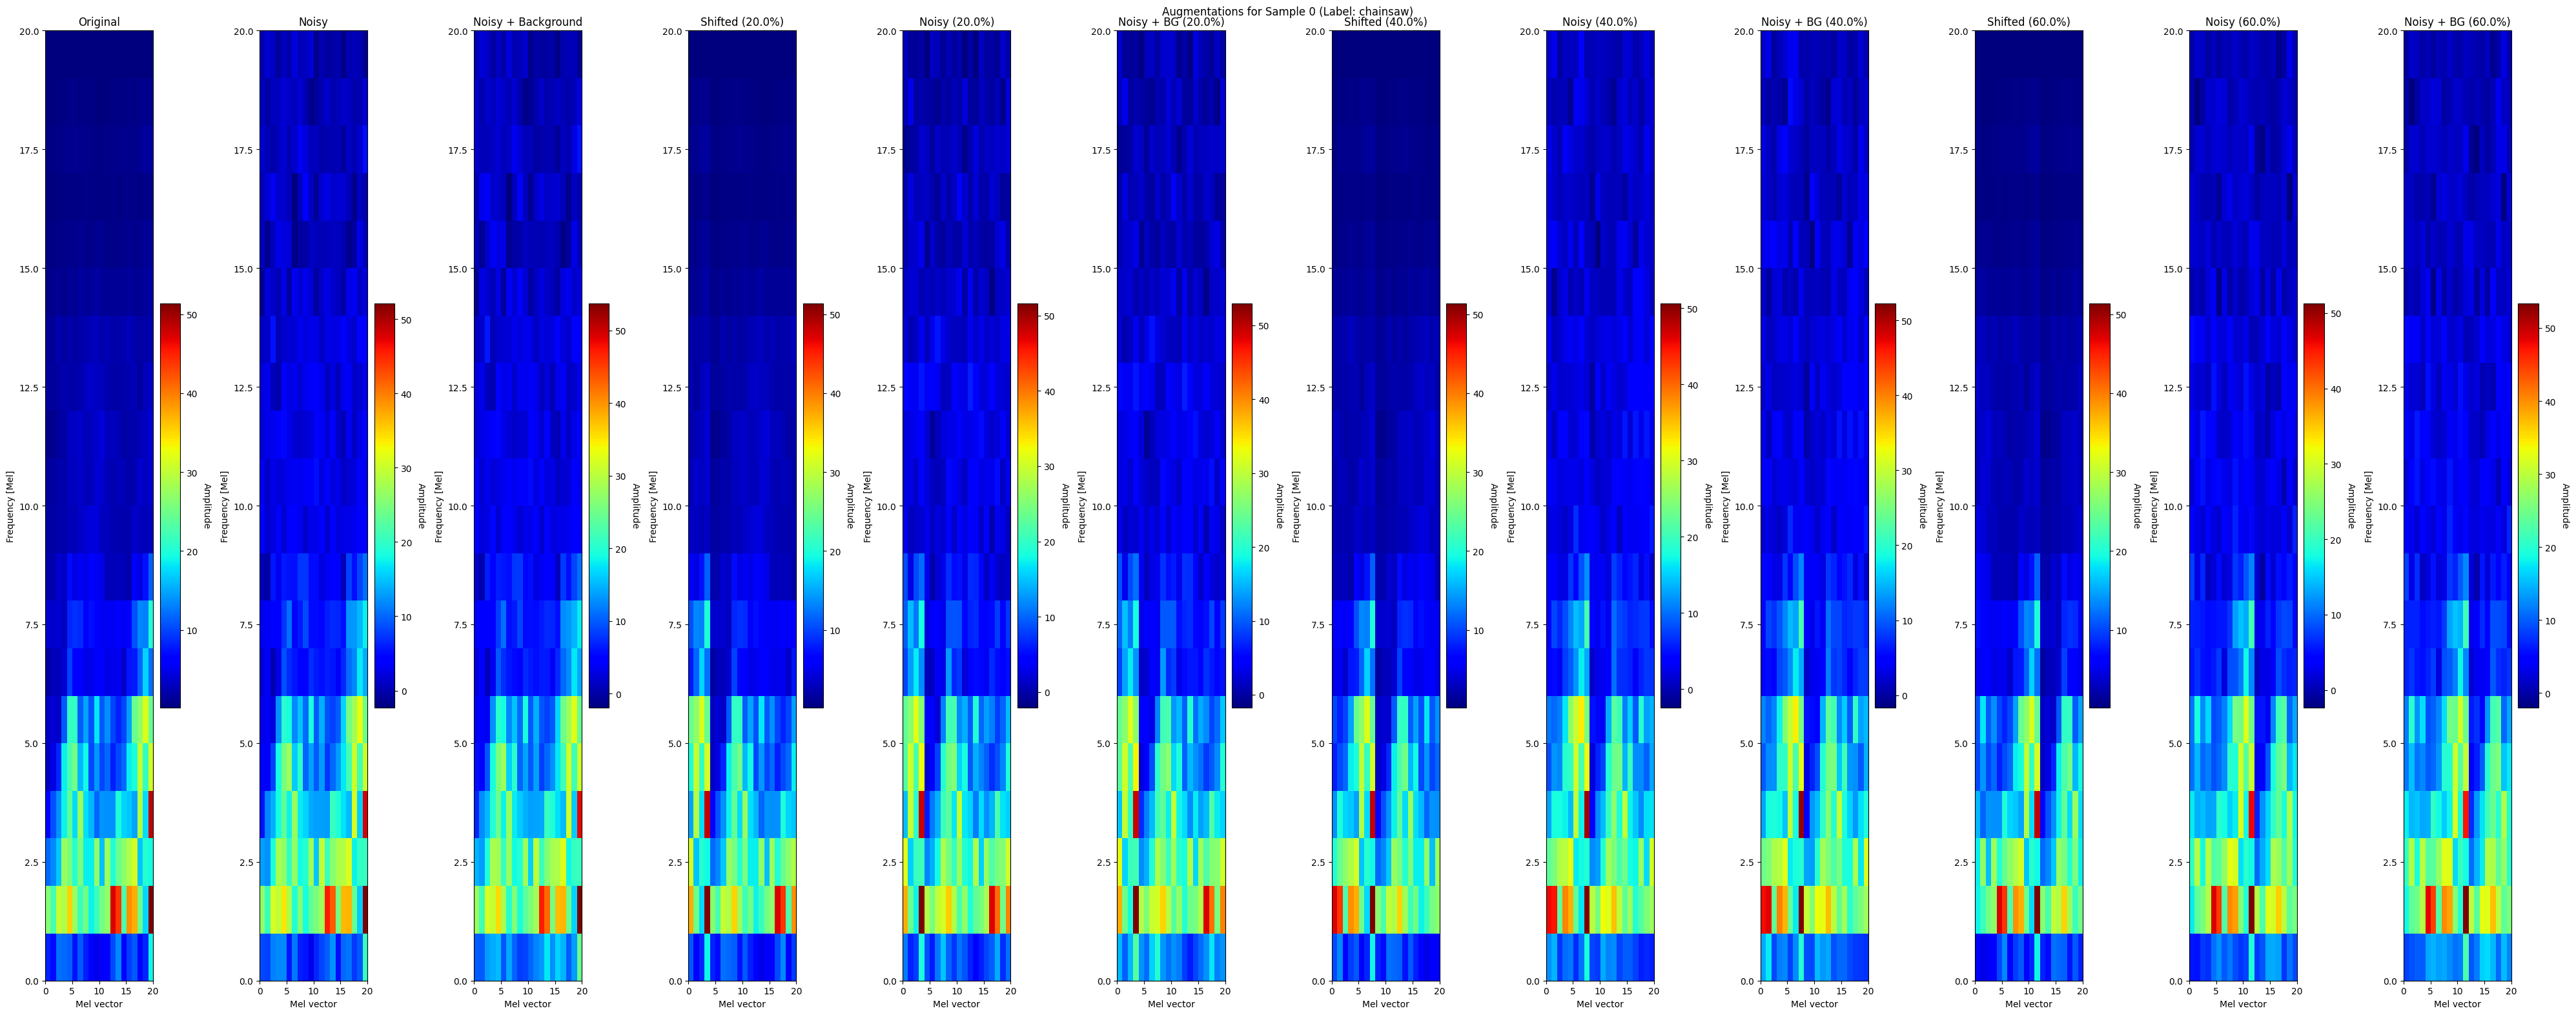

Augmentation du training set:  10%|█         | 1/10 [00:13<02:04, 13.80s/it]

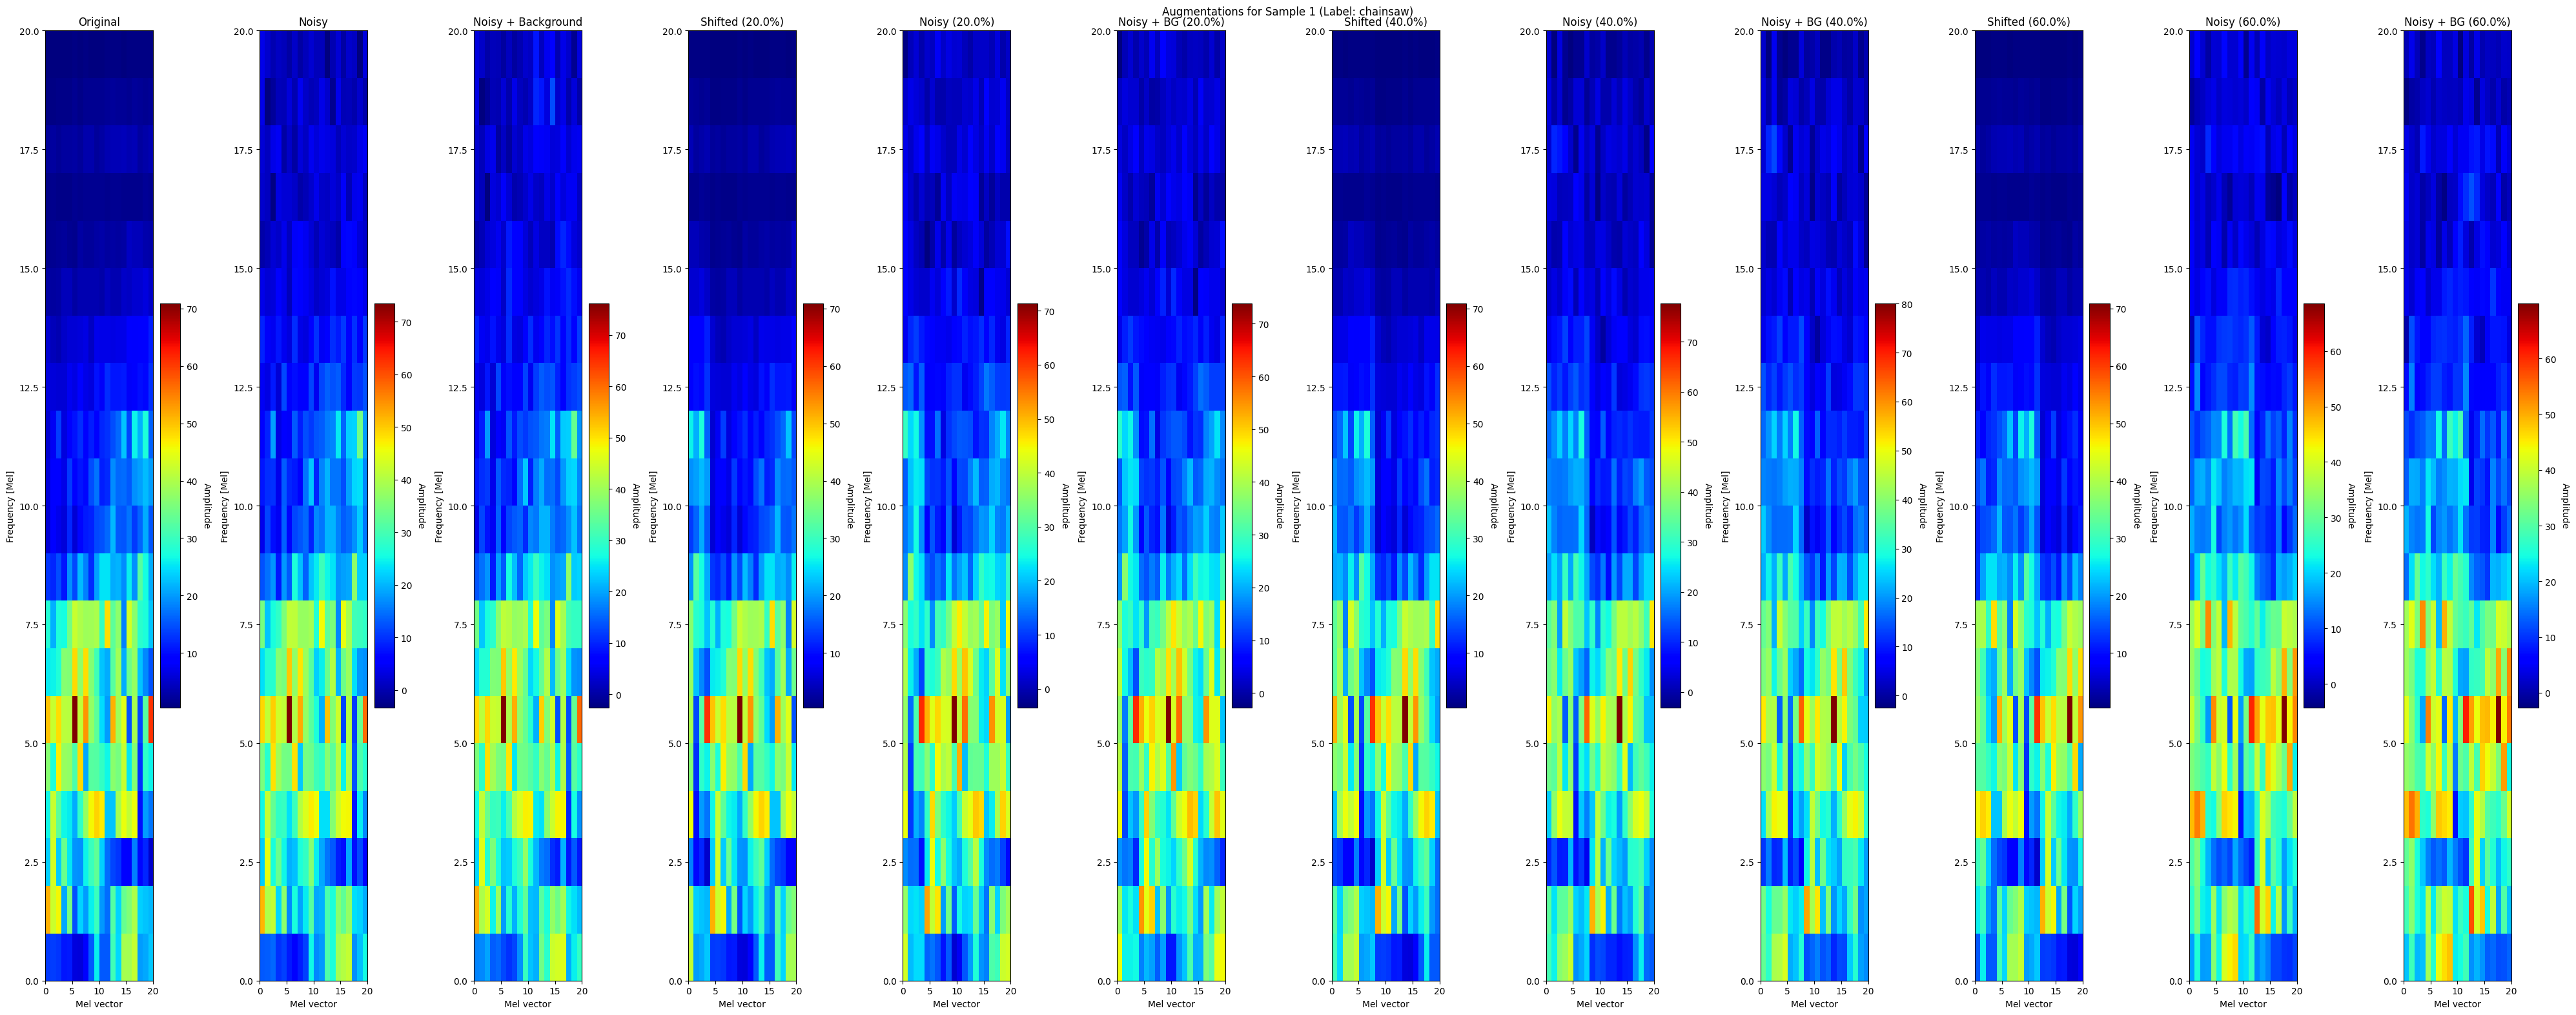

Augmentation du training set:  20%|██        | 2/10 [00:26<01:45, 13.13s/it]

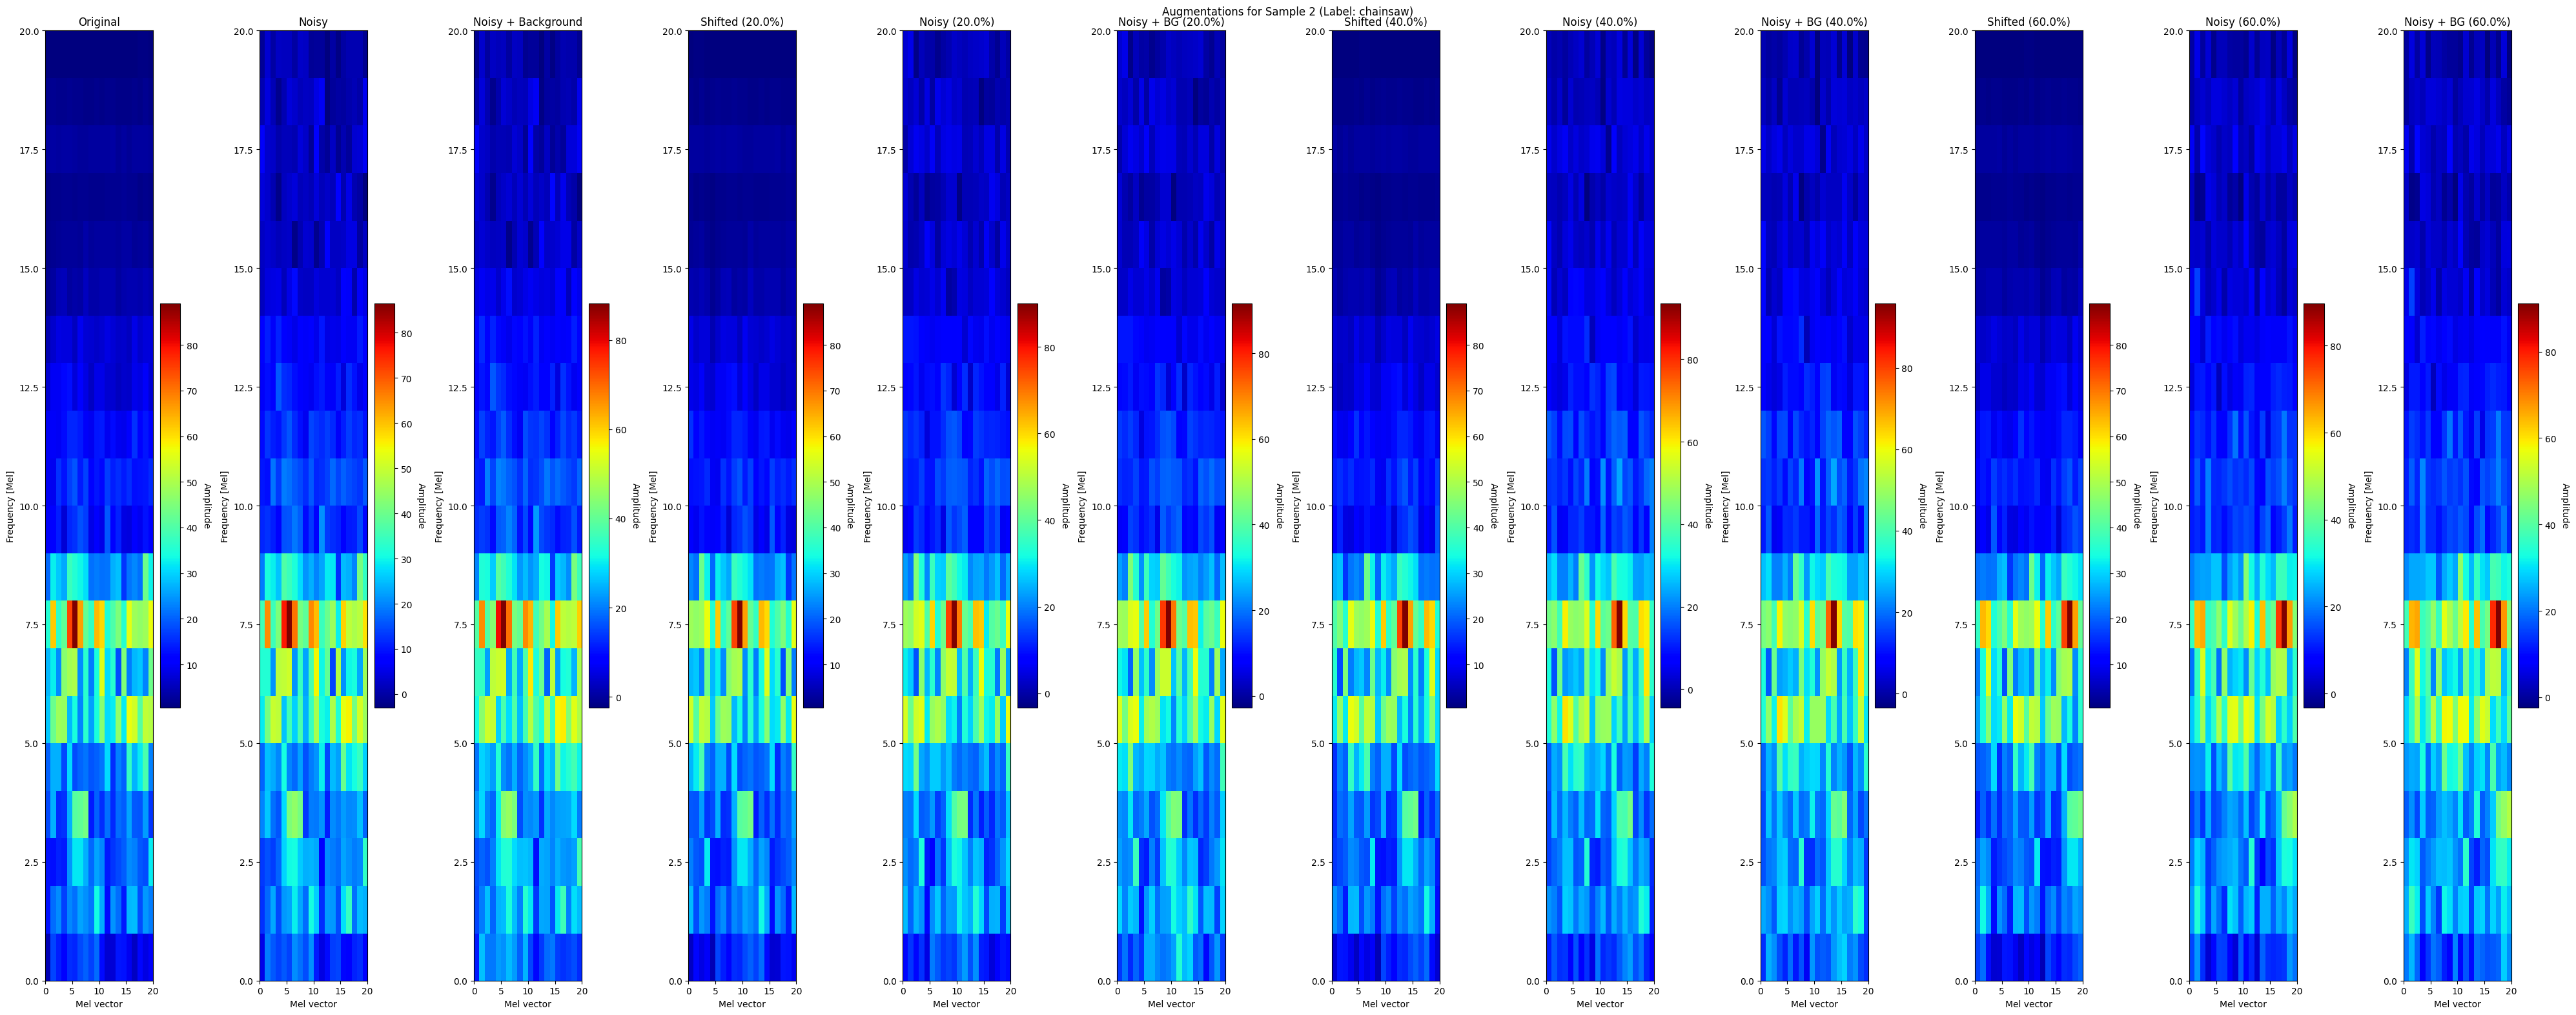

Augmentation du training set:  30%|███       | 3/10 [00:38<01:28, 12.67s/it]

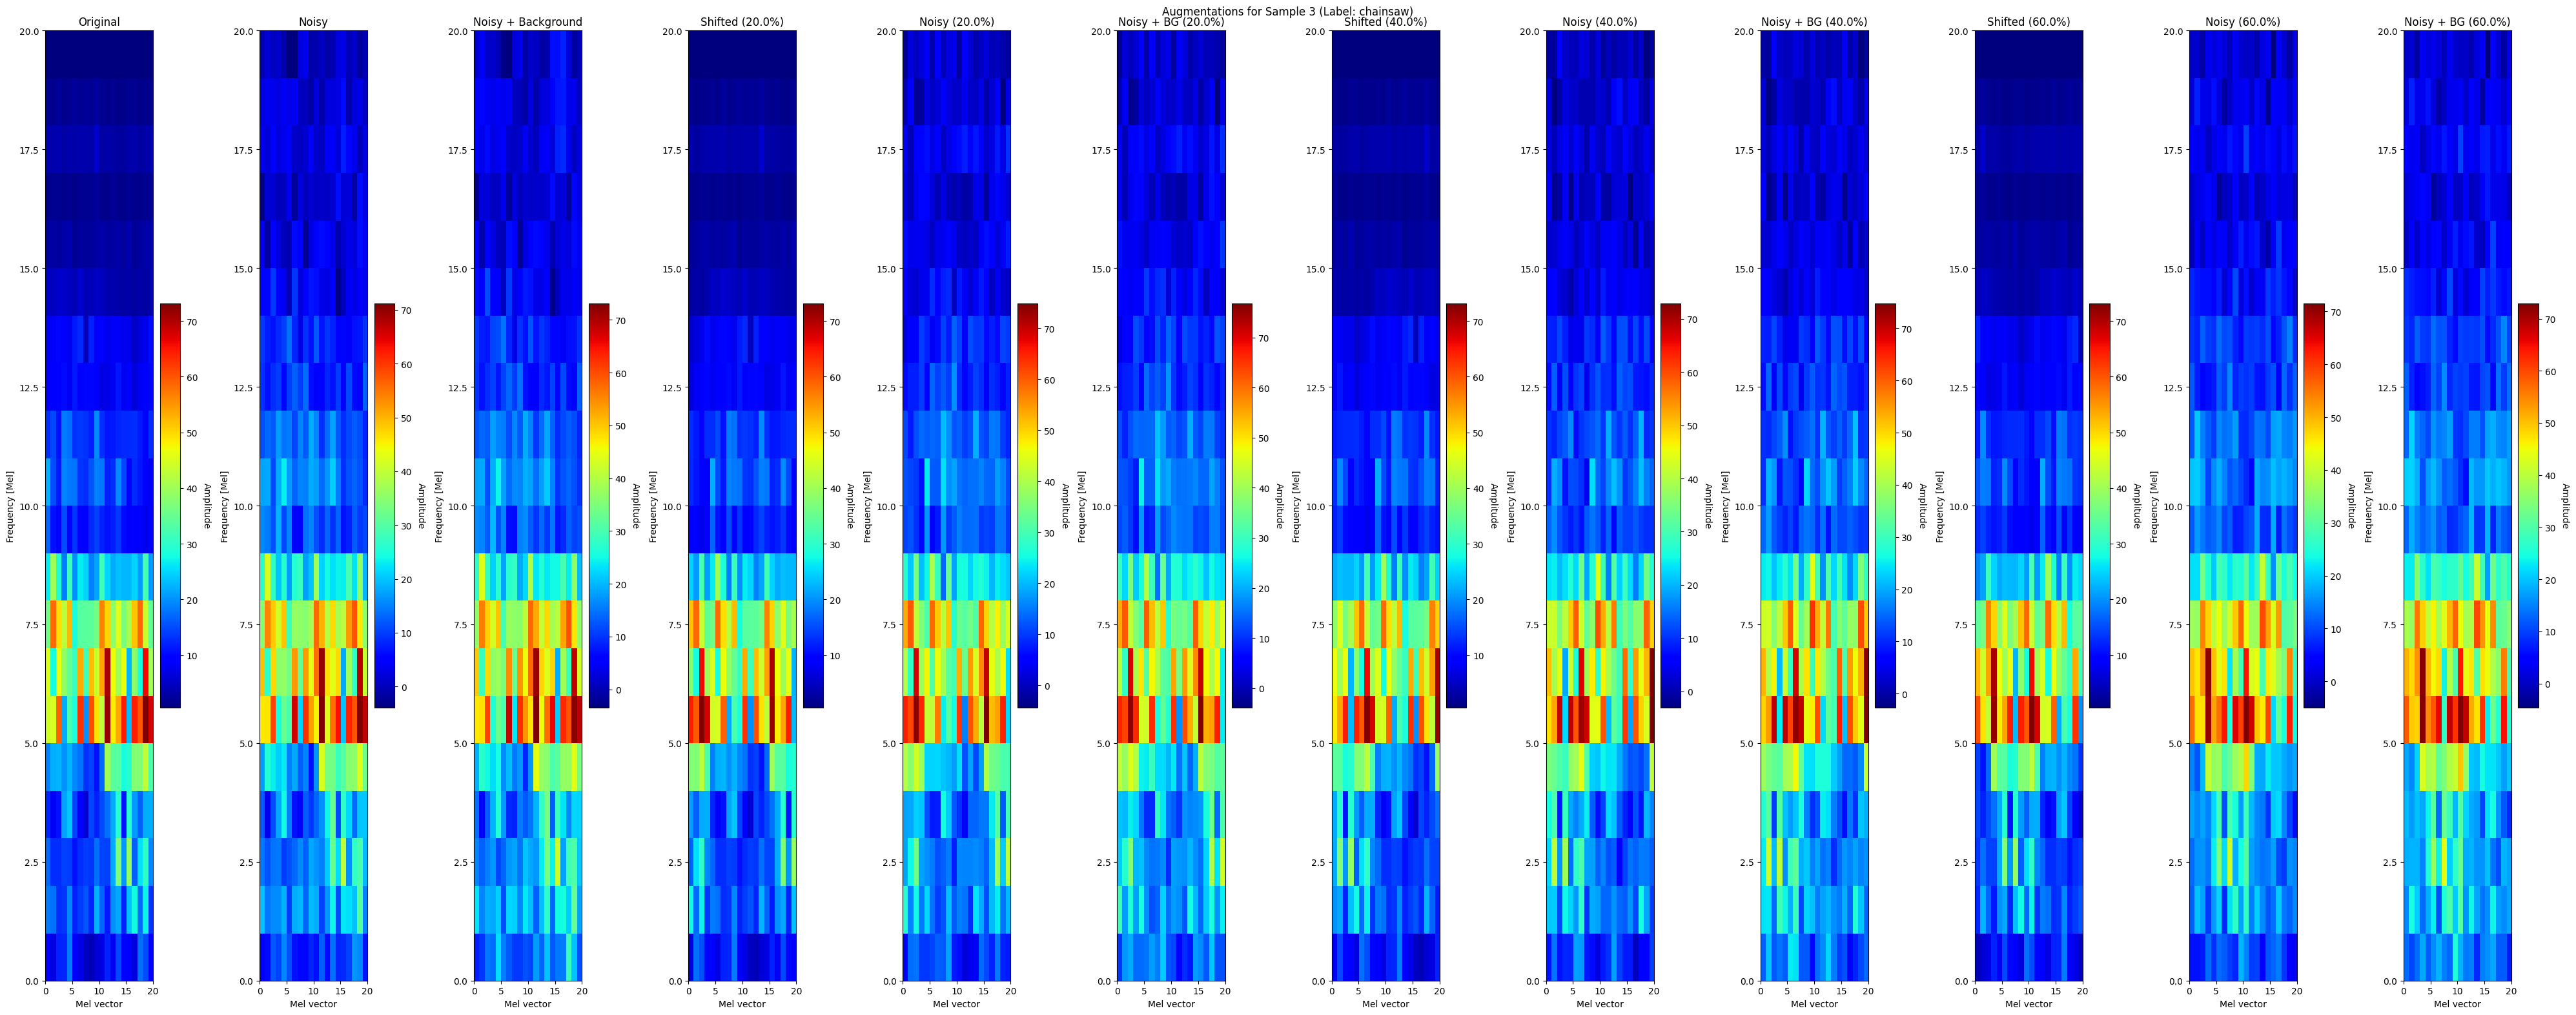

Augmentation du training set:  40%|████      | 4/10 [00:51<01:15, 12.65s/it]

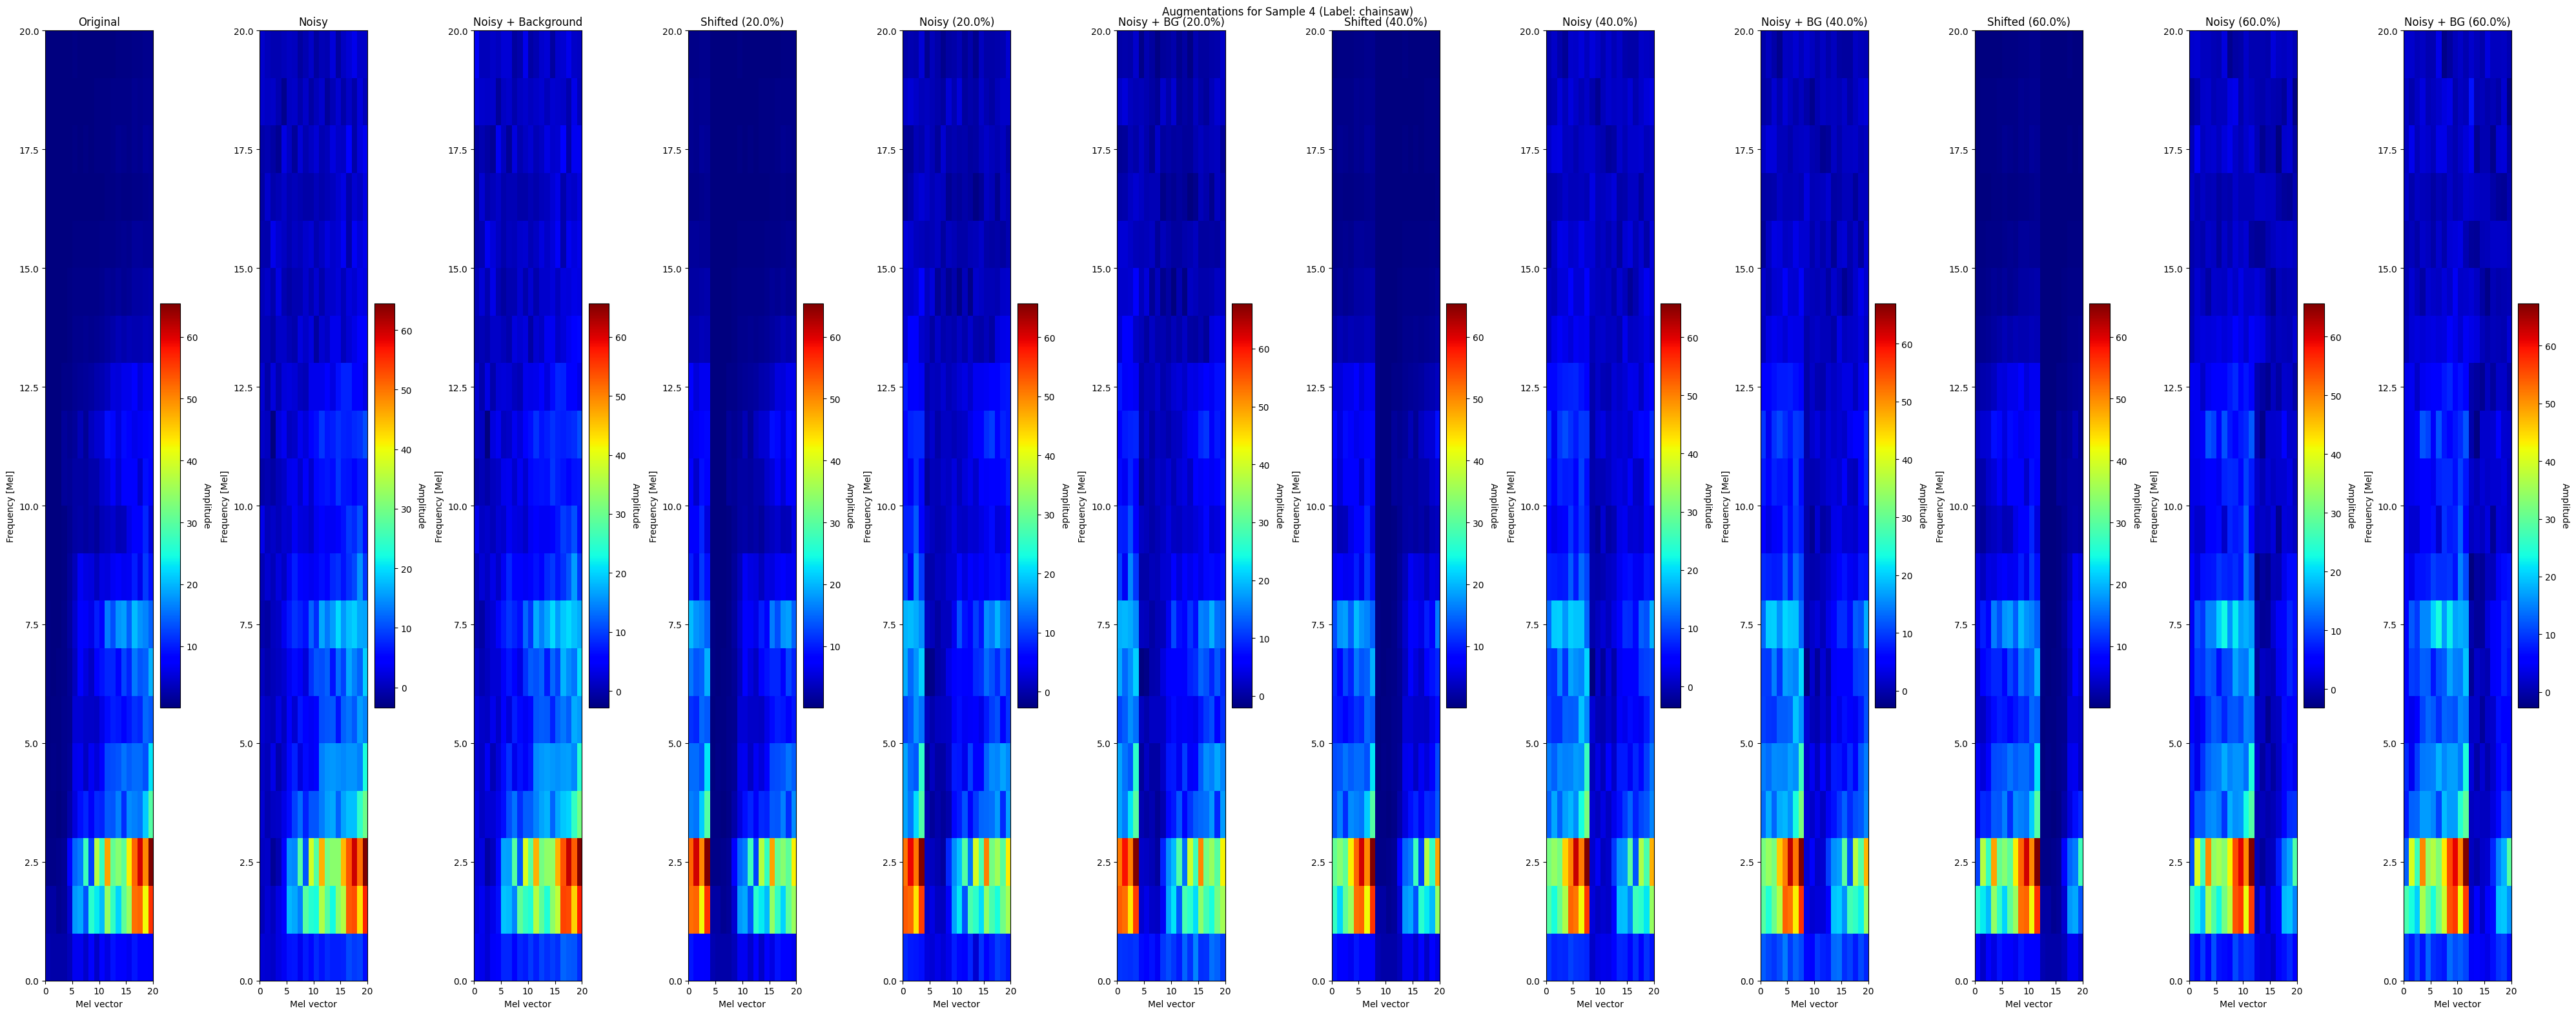

Augmentation du training set:  50%|█████     | 5/10 [01:03<01:02, 12.42s/it]

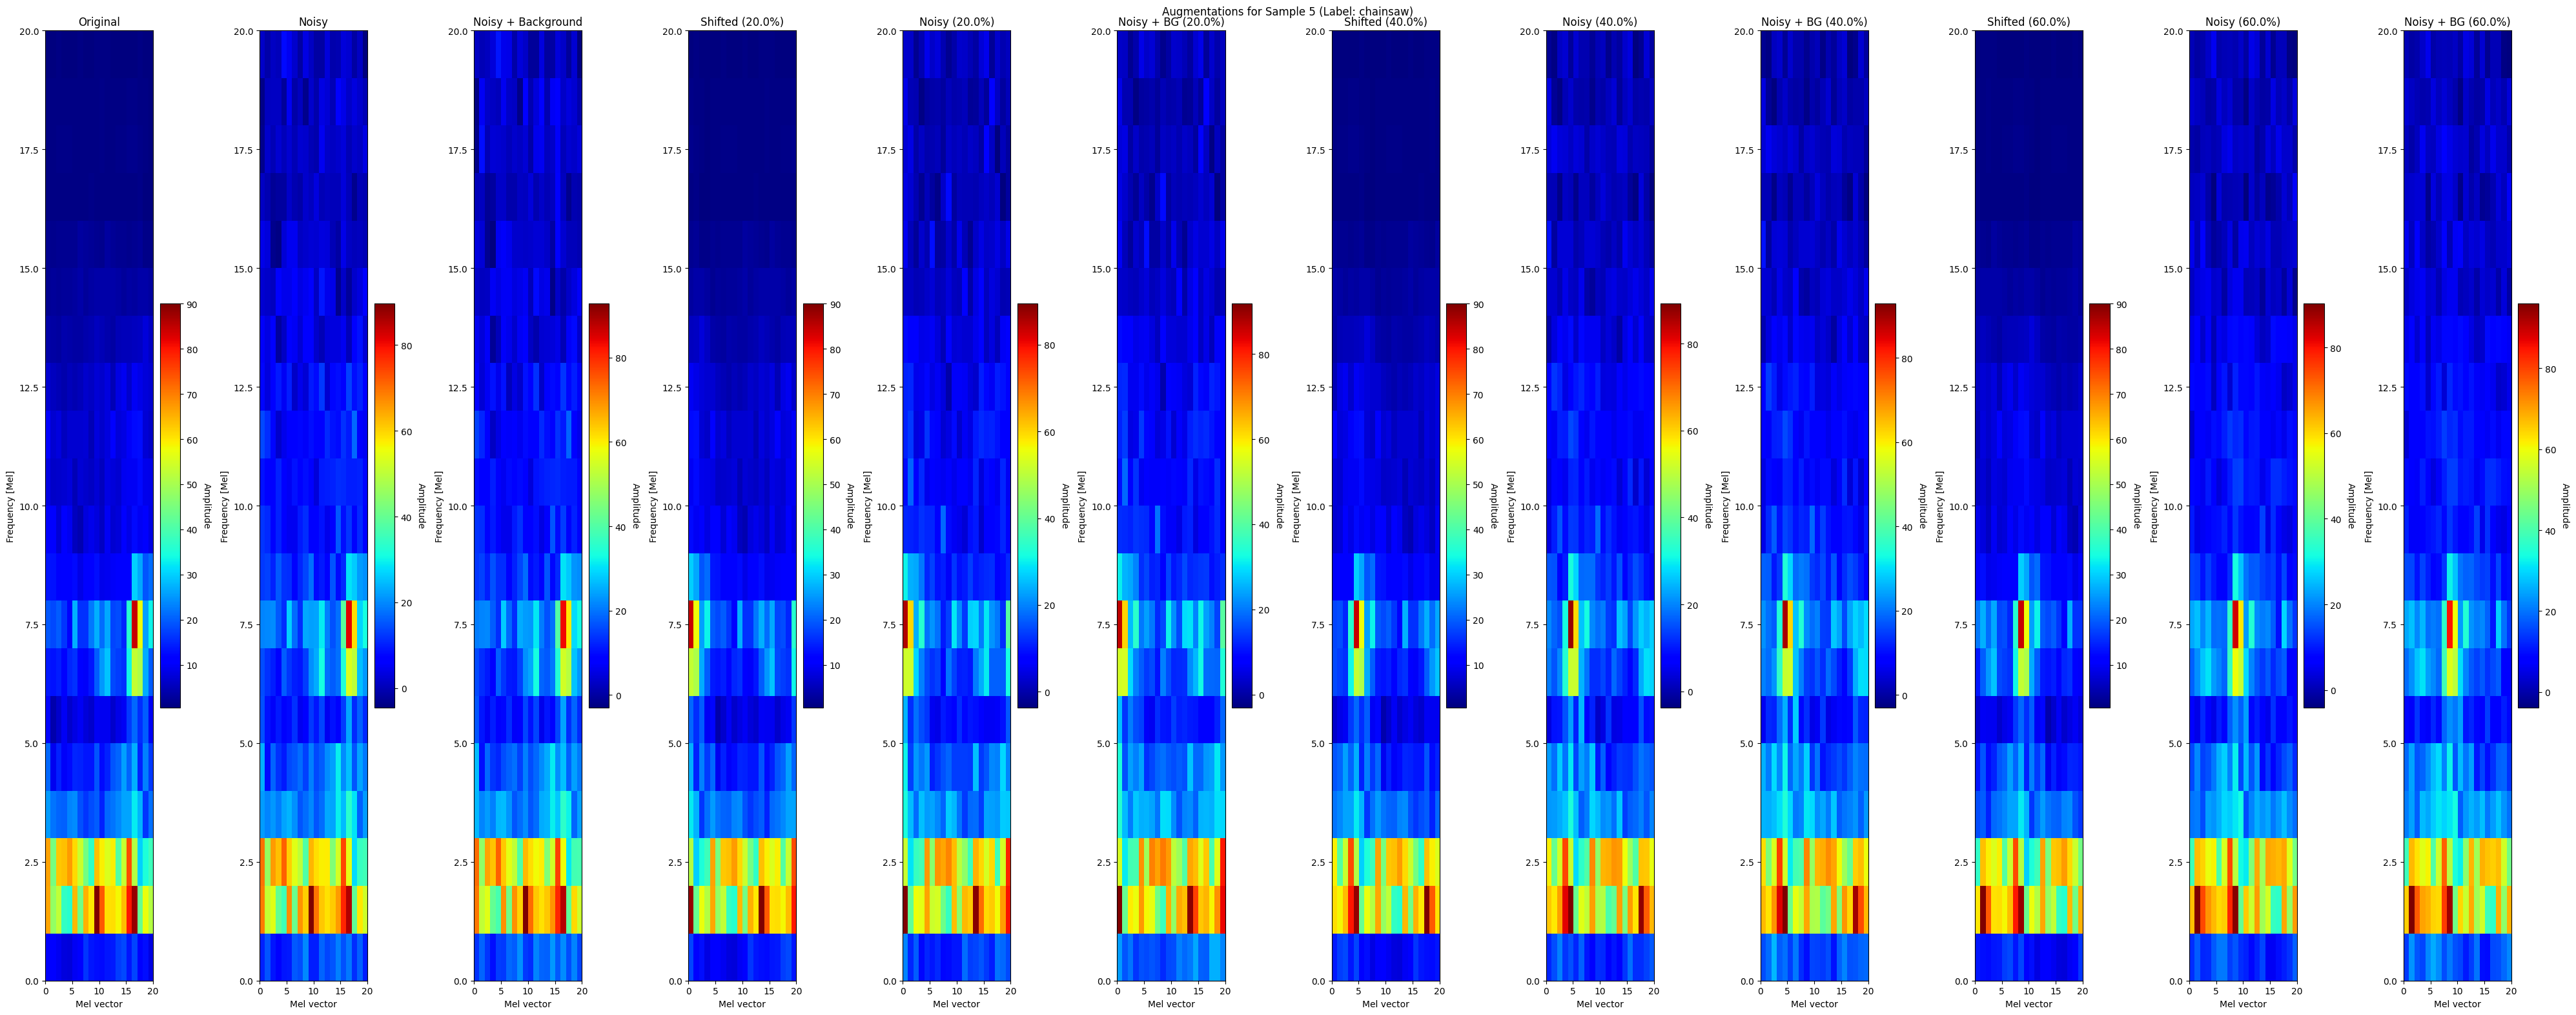

Augmentation du training set:  60%|██████    | 6/10 [01:15<00:49, 12.41s/it]

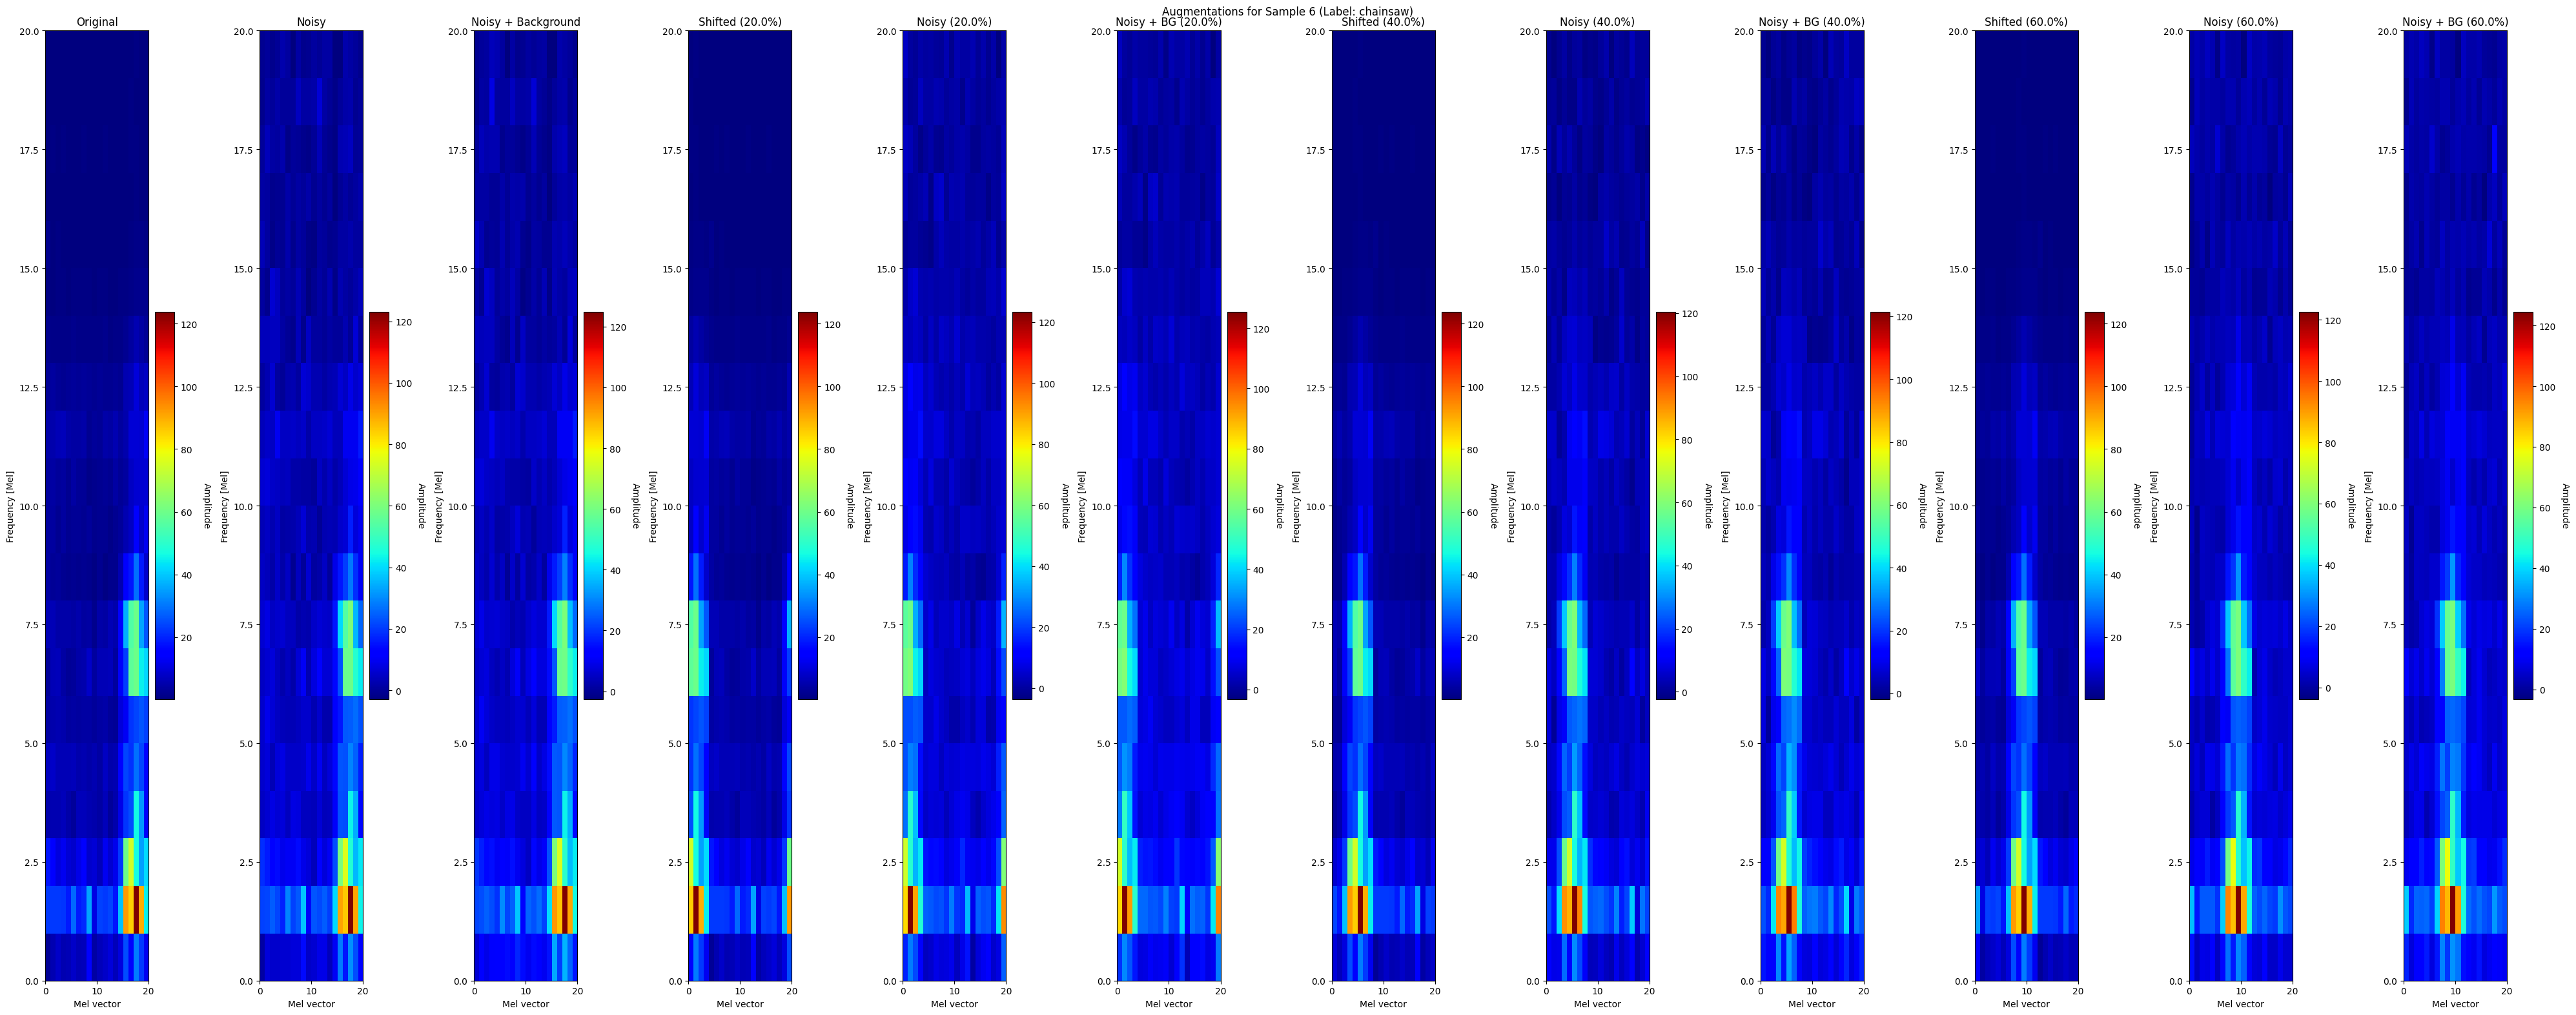

Augmentation du training set:  70%|███████   | 7/10 [01:34<00:40, 13.50s/it]


KeyboardInterrupt: 

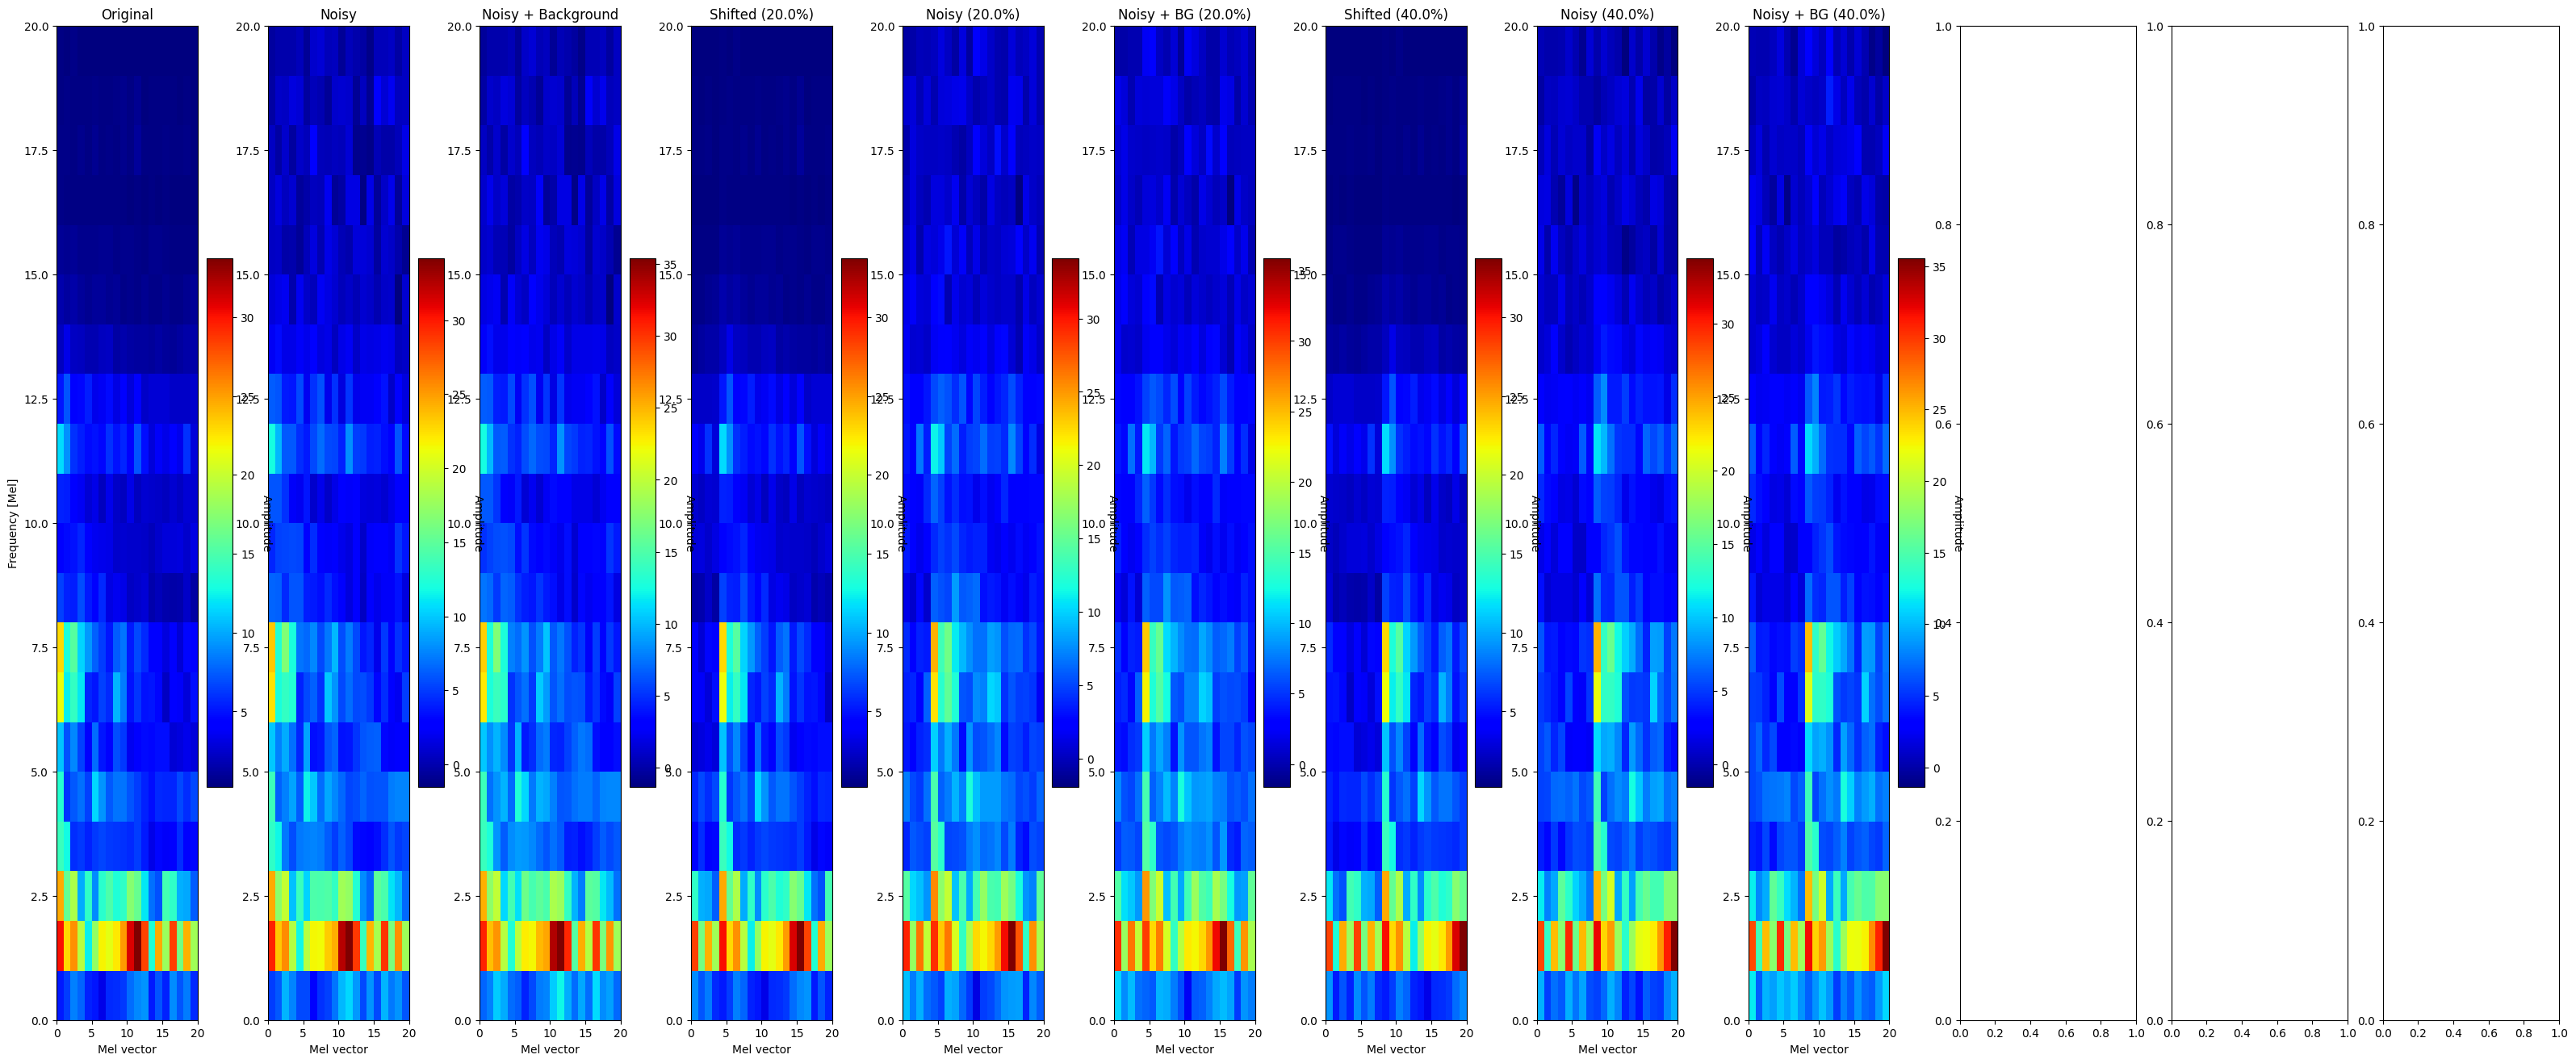

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
X_aug = np.load(fm_dir + "feature_matrix_400_test_aug_extended_12.npy")
y_aug = np.load(fm_dir + "labels_400_test_aug_extended_12.npy", allow_pickle=True)
index =0
shift_pcts = [0.2,0.4,0.6]
for i, (vector, label) in enumerate(tqdm(zip(X_aug[:10], y_aug[:10]), total=10, desc="Augmentation du training set")):
    fig, axes = plt.subplots(1, 12, figsize=(40, 16))  # Créez une figure avec 12 sous-graphiques

    # Ajouter le vecteur original
    plot_specgram(
        X_aug[index].reshape((20, 20)), 
        ax=axes[0],
        is_mel=True,
        title="Original",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    
    # Ajouter le vecteur bruité
    noisy_vector_base = X_aug[index + 1]
    plot_specgram(
        noisy_vector_base.reshape((20, 20)), 
        ax=axes[1],
        is_mel=True,
        title="Noisy",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    
    # Ajouter le vecteur bruité avec bruit de fond
    noisy_with_bg_vector_base = X_aug[index + 2]
    plot_specgram(
        noisy_with_bg_vector_base.reshape((20, 20)), 
        ax=axes[2],
        is_mel=True,
        title="Noisy + Background",
        xlabel="Mel vector",
        amplitude_label="Amplitude"
    )
    
    # Appliquer les augmentations pour chaque shift_pct
    for j, shift_pct in enumerate(shift_pcts):
        # Décalage temporel
        shifted_vector = X_aug[index + 3 + j * 3]
        plot_specgram(
            shifted_vector.reshape((20, 20)), 
            ax=axes[3 + j * 3],
            is_mel=True,
            title=f"Shifted ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )

        # Bruit gaussien
        noisy_vector = X_aug[index + 4 + j * 3]
        plot_specgram(
            noisy_vector.reshape((20, 20)), 
            ax=axes[4 + j * 3],
            is_mel=True,
            title=f"Noisy ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )

        # Bruit de fond
        noisy_with_bg_vector = X_aug[index + 5 + j * 3]
        plot_specgram(
            noisy_with_bg_vector.reshape((20, 20)), 
            ax=axes[5 + j * 3],
            is_mel=True,
            title=f"Noisy + BG ({shift_pct*100}%)",
            xlabel="Mel vector",
            amplitude_label="Amplitude"
        )
    
    plt.suptitle(f"Augmentations for Sample {i} (Label: {label})")
    plt.tight_layout()
    plt.show()
    index += 12  # Mettre à jour l'index pour le prochain exemple
